<a href="https://colab.research.google.com/github/yqqvxxvi/Sri_Aman_Landmark_OB/blob/main/YOLOv11_model_CIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jul 29 15:40:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics torch matplotlib pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/data

In [ ]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # For Colab's notebook environment

def split_yolo_dataset(data_dir, val_split=0.2, seed=42):
    """
    Split an existing YOLO dataset into train and validation sets.

    Args:
        data_dir: Directory containing your YOLO dataset
        val_split: Proportion of data to use for validation
        seed: Random seed for reproducibility
    """
    # Set random seed for reproducibility
    random.seed(seed)

    # Convert to Path object
    data_dir = Path(data_dir)

    # Create necessary directories
    images_dir = data_dir / 'images'
    labels_dir = data_dir / 'labels'

    (data_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (data_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (data_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (data_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Get all image files
    image_files = list(images_dir.glob('*.*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    # Get corresponding label files
    image_names = [f.stem for f in image_files]
    label_files = [(labels_dir / f"{name}.txt") for name in image_names]

    # Filter out images without labels
    valid_pairs = []
    for img_file, lbl_file in zip(image_files, label_files):
        if lbl_file.exists():
            valid_pairs.append((img_file, lbl_file))

    print(f"Found {len(valid_pairs)} valid image-label pairs")

    # Split into train and validation sets
    train_pairs, val_pairs = train_test_split(
        valid_pairs, test_size=val_split, random_state=seed
    )

    print(f"Training set: {len(train_pairs)} pairs")
    print(f"Validation set: {len(val_pairs)} pairs")

    # Move files to train directory
    for img_file, lbl_file in tqdm(train_pairs, desc="Moving training files"):
        shutil.copy(img_file, data_dir / 'train' / 'images' / img_file.name)
        shutil.copy(lbl_file, data_dir / 'train' / 'labels' / lbl_file.name)

    # Move files to validation directory
    for img_file, lbl_file in tqdm(val_pairs, desc="Moving validation files"):
        shutil.copy(img_file, data_dir / 'val' / 'images' / img_file.name)
        shutil.copy(lbl_file, data_dir / 'val' / 'labels' / lbl_file.name)

    print("Dataset splitting complete!")
    return {
        'total': len(valid_pairs),
        'train': len(train_pairs),
        'val': len(val_pairs)
    }

# Alternative version if your dataset is already in class folders
def split_class_folders_dataset(data_dir, output_dir, val_split=0.2, seed=42):
    """
    Split a dataset organized by class folders into YOLO train and validation sets.

    Args:
        data_dir: Directory containing class folders with images
        output_dir: Directory to save the processed YOLO dataset
        val_split: Proportion of data to use for validation
        seed: Random seed for reproducibility
    """
    random.seed(seed)
    data_dir = Path(data_dir)
    output_dir = Path(output_dir)

    # Create output directories
    (output_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (output_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (output_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Get all class directories
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    class_mapping = {d.name: idx for idx, d in enumerate(class_dirs)}

    all_files = []
    for class_dir in class_dirs:
        class_id = class_mapping[class_dir.name]
        image_files = []
        for ext in ['.jpg', '.jpeg', '.png']:
            image_files.extend(list(class_dir.glob(f'*{ext}')))
            image_files.extend(list(class_dir.glob(f'*{ext.upper()}')))

        all_files.extend([(img_path, class_id) for img_path in image_files])

    # Split into train and validation sets
    train_files, val_files = train_test_split(
        all_files, test_size=val_split, random_state=seed
    )

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Process training images
    for idx, (img_path, class_id) in enumerate(tqdm(train_files, desc="Processing training files")):
        # Copy image with class info in filename
        new_filename = f"class_{class_id}_{img_path.stem}_{idx}{img_path.suffix}"
        shutil.copy(img_path, output_dir / 'train' / 'images' / new_filename)

        # Create label file
        label_filename = new_filename.replace(img_path.suffix, '.txt')
        with open(output_dir / 'train' / 'labels' / label_filename, 'w') as f:
            # Class ID + centered bounding box
            f.write(f"{class_id} 0.5 0.5 0.8 0.8\n")

    # Process validation images
    for idx, (img_path, class_id) in enumerate(tqdm(val_files, desc="Processing validation files")):
        # Copy image with class info in filename
        new_filename = f"class_{class_id}_{img_path.stem}_{idx}{img_path.suffix}"
        shutil.copy(img_path, output_dir / 'val' / 'images' / new_filename)

        # Create label file
        label_filename = new_filename.replace(img_path.suffix, '.txt')
        with open(output_dir / 'val' / 'labels' / label_filename, 'w') as f:
            # Class ID + centered bounding box
            f.write(f"{class_id} 0.5 0.5 0.8 0.8\n")

    print("Dataset splitting complete!")
    return {
        'total': len(all_files),
        'train': len(train_files),
        'val': len(val_files),
        'classes': class_mapping
    }

# Example usage in Colab
if __name__ == "__main__":
    # If your dataset is already in YOLO format with images/ and labels/ folders
    data_dir = "/content/data/data_ver2_(include_null)/train"
    result = split_yolo_dataset(data_dir, val_split=0.3)

    # OR if your dataset is organized by class folders
    # data_dir = "/content/class_folders_dataset"
    # output_dir = "/content/yolo_dataset"
    # result = split_class_folders_dataset(data_dir, output_dir, val_split=0.2)

    print(f"Total images: {result['total']}")
    print(f"Training set: {result['train']} images")
    print(f"Validation set: {result['val']} images")

Found 300 valid image-label pairs
Training set: 210 pairs
Validation set: 90 pairs


Moving training files:   0%|          | 0/210 [00:00<?, ?it/s]

Moving validation files:   0%|          | 0/90 [00:00<?, ?it/s]

Dataset splitting complete!
Total images: 300
Training set: 210 images
Validation set: 90 images


Track memory

In [ ]:
import os
import random
import numpy as np
import torch
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import shutil

seed = 18

# For reproducibility with CUDA and CPU
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print("CUDA is available. Using GPU for training.")
    device = 0  # Use GPU
else:
    print("CUDA is not available. Using CPU for training.")
    device = 'cpu'  # Use CPU


class IncrementalYOLO:
    def __init__(self, model_name='yolov8n.pt', data_yaml_path='data.yaml', pretrained=True, memory_size=1, device=None):
        """
        Initialize the Incremental YOLO model

        Args:
            model_name: YOLO model variant
            data_yaml_path: Path to your data.yaml file
            pretrained: Whether to use pretrained weights
            memory_size: Number of exemplars per class to keep
        """

        # Set device (0 for GPU if available, otherwise CPU)
        if device is None:
            self.device = 0 if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Load original data.yaml
        with open(data_yaml_path, 'r') as f:
            self.original_data_yaml = yaml.safe_load(f)

        self.data_yaml_path = data_yaml_path
        self.dataset_dir = os.path.dirname(data_yaml_path)
        self.memory_size = memory_size
        self.memory_buffer = {}  # Class ID -> list of sample paths
        self.seen_classes = set()
        self.results = defaultdict(list)  # To store metrics for each case

        # Extract class information
        self.class_names = self.original_data_yaml['names']
        if isinstance(self.class_names, list):
            self.class_mapping = {i: name for i, name in enumerate(self.class_names)}
        else:
            self.class_mapping = self.class_names

        self.num_classes = self.original_data_yaml['nc']
        print(f"Loaded dataset with {self.num_classes} classes:")
        for i, name in list(self.class_mapping.items())[:self.num_classes]:
            print(f"  Class {i}: {name}")

        # Initialize model
        try:
            self.model = YOLO(model_name)
            if pretrained:
                print(f"Loaded pretrained {model_name} model")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def get_train_images_dir(self):
        """Get the training images directory from data.yaml"""
        train_path = self.original_data_yaml['train']
        # Handle relative paths
        if not os.path.isabs(train_path):
            train_path = os.path.join(self.dataset_dir, train_path)
        return train_path

    def select_exemplars(self, class_id):
        """Select representative samples for memory replay"""
        train_dir = self.get_train_images_dir()

        # Get all image files
        all_files = os.listdir(train_dir)

        # Get corresponding label files
        label_dir = train_dir.replace('images', 'labels')

        # Filter files that contain the target class
        class_images = []

        for img_file in all_files:
            if not img_file.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Check corresponding label file
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(label_dir, label_file)

            if os.path.exists(label_path):
                # Read label file to check if it contains the class_id
                with open(label_path, 'r') as f:
                    labels = f.readlines()

                for label in labels:  # Changed 'lines' to 'labels'
                    parts = label.strip().split()
                    if parts and int(parts[0]) == class_id:
                        class_images.append(img_file)
                        break

        if not class_images:
            print(f"Warning: No images found for class {class_id} ({self.class_mapping.get(class_id, 'unknown')})")
            return []

        # For simplicity, randomly select samples
        selected = random.sample(class_images, min(self.memory_size, len(class_images)))
        return [os.path.join(train_dir, s) for s in selected]

    def update_memory(self, class_id):
        """Update memory buffer with exemplars from a new class"""
        self.memory_buffer[class_id] = self.select_exemplars(class_id)
        self.seen_classes.add(class_id)
        print(f"Added {len(self.memory_buffer[class_id])} memory samples for class {class_id} ({self.class_mapping.get(class_id, 'unknown')})")

    def print_memory_stats(self):
      """
      Print detailed statistics about the memory buffer and replay percentage
      """
      # Get training directory
      train_dir = self.get_train_images_dir()
      if not os.path.exists(train_dir):
          print("Training directory not found!")
          return

      # Count total training images
      all_train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
      total_train_images = len(all_train_images)

      # Count images per class
      class_counts = {}
      label_dir = train_dir.replace('images', 'labels')

      for img_file in all_train_images:
          label_file = os.path.splitext(img_file)[0] + '.txt'
          label_path = os.path.join(label_dir, label_file)

          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  labels = f.readlines()

              for label in labels:
                  parts = label.strip().split()
                  if parts:
                      class_id = int(parts[0])
                      if class_id not in class_counts:
                          class_counts[class_id] = 0
                      class_counts[class_id] += 1

      # Count memory buffer stats
      total_exemplars = sum(len(exemplars) for exemplars in self.memory_buffer.values())

      # Print statistics
      print("\n===== MEMORY BUFFER STATISTICS =====")
      print(f"Total training images: {total_train_images}")
      print(f"Number of classes: {self.num_classes}")
      print(f"Memory size parameter: {self.memory_size} exemplars per class")
      print(f"Total exemplars saved: {total_exemplars}")

      if total_train_images > 0:
          replay_percentage = (total_exemplars / total_train_images) * 100
          print(f"Percentage of training data saved for replay: {replay_percentage:.2f}%")

      print("\nClass distribution in dataset:")
      for class_id, count in sorted(class_counts.items()):
          class_name = self.class_mapping.get(class_id, f"Class {class_id}")
          print(f"  {class_name}: {count} images")

      print("\nMemory buffer contents:")
      for class_id, exemplars in sorted(self.memory_buffer.items()):
          class_name = self.class_mapping.get(class_id, f"Class {class_id}")
          print(f"  {class_name}: {len(exemplars)} exemplars")

    def prepare_class_mapping(self, current_classes):
        """
        Create a continuous class mapping for the current classes
        This is crucial for avoiding the 'class exceeds dataset class count' error
        """
        # Create a mapping from original class IDs to continuous class IDs (0, 1, 2...)
        all_classes = sorted(list(self.seen_classes) + current_classes)
        class_mapping = {original_id: new_id for new_id, original_id in enumerate(all_classes)}

        # Create a reverse mapping to convert back if needed
        reverse_mapping = {new_id: original_id for original_id, new_id in class_mapping.items()}

        return class_mapping, reverse_mapping, all_classes

    def prepare_incremental_data(self, current_classes):
        """Prepare data for the current increment"""
        # Create a continuous class mapping to avoid 'class exceeds dataset class count' error
        class_mapping, reverse_mapping, all_classes = self.prepare_class_mapping(current_classes)

        # Create a new data.yaml file for the current training step
        if isinstance(self.class_names, list):
            # Map original class names to new continuous IDs
            current_names = []
            for i in range(len(all_classes)):
                if i in reverse_mapping:
                    original_idx = reverse_mapping[i]
                    if original_idx < len(self.class_names):
                        current_names.append(self.class_names[original_idx])
                    else:
                        current_names.append(f"class_{original_idx}")
                else:
                    # Fallback for missing indices
                    current_names.append(f"class_{i}")
        else:
            # Map original class names to new continuous IDs
            current_names = {}
            for i in range(len(all_classes)):
                if i in reverse_mapping:
                    original_idx = reverse_mapping[i]
                    if str(original_idx) in self.class_names:
                        current_names[i] = self.class_names[str(original_idx)]
                    else:
                        current_names[i] = f"class_{original_idx}"
                else:
                    # Fallback for missing indices
                    current_names[i] = f"class_{i}"

        # Create a copy of the original data.yaml with updated class names
        incremental_data = self.original_data_yaml.copy()
        incremental_data['names'] = current_names
        incremental_data['nc'] = len(all_classes)

        # Create temporary dataset directories
        temp_dir = os.path.join(self.dataset_dir, f"temp_dataset_{random.randint(1000, 9999)}")
        temp_train_images = os.path.join(temp_dir, "train", "images")
        temp_train_labels = os.path.join(temp_dir, "train", "labels")
        temp_val_images = os.path.join(temp_dir, "val", "images")
        temp_val_labels = os.path.join(temp_dir, "val", "labels")

        # Create directories
        os.makedirs(temp_train_images, exist_ok=True)
        os.makedirs(temp_train_labels, exist_ok=True)
        os.makedirs(temp_val_images, exist_ok=True)
        os.makedirs(temp_val_labels, exist_ok=True)

        # Get original paths
        train_images = self.original_data_yaml['train']
        val_images = self.original_data_yaml['val']

        # Handle relative paths
        if not os.path.isabs(train_images):
            train_images = os.path.join(self.dataset_dir, train_images)
        if not os.path.isabs(val_images):
            val_images = os.path.join(self.dataset_dir, val_images)

        # Get label directories
        train_labels = train_images.replace('images', 'labels')
        val_labels = val_images.replace('images', 'labels')

        # Copy and remap training data
        self.copy_and_remap_data(
            train_images, train_labels,
            temp_train_images, temp_train_labels,
            class_mapping
        )

        # Copy and remap validation data
        self.copy_and_remap_data(
            val_images, val_labels,
            temp_val_images, temp_val_labels,
            class_mapping
        )

        # Update paths in the YAML
        incremental_data['train'] = temp_train_images
        incremental_data['val'] = temp_val_images

        # Write yaml file
        yaml_path = os.path.join(temp_dir, 'incremental_data.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(incremental_data, f, sort_keys=False)

        return yaml_path, class_mapping, reverse_mapping, temp_dir

    def cleanup_temp_dirs(self, temp_dirs):
        """Safely clean up temporary directories"""
        for temp_dir in temp_dirs:
            if os.path.exists(temp_dir):
                try:
                    shutil.rmtree(temp_dir)
                    print(f"Removed temporary directory: {temp_dir}")
                except Exception as e:
                    print(f"Warning: Could not remove temp directory {temp_dir}: {e}")
            else:
                print(f"Note: Temp directory already removed or doesn't exist: {temp_dir}")

    def copy_and_remap_data(self, src_img_dir, src_label_dir, dst_img_dir, dst_label_dir, class_mapping):
        """
        Copy images and remap their labels according to the class mapping
        """
        # Ensure source directories exist
        if not os.path.exists(src_img_dir):
            print(f"Warning: Source image directory {src_img_dir} does not exist!")
            return

        if not os.path.exists(src_label_dir):
            print(f"Warning: Source label directory {src_label_dir} does not exist!")
            return

        # Get all image files
        img_files = [f for f in os.listdir(src_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        count_copied = 0
        count_remapped = 0

        # Process each image and its label
        for img_file in img_files:
            # Get corresponding label file
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(src_label_dir, label_file)

            # Skip if label file doesn't exist
            if not os.path.exists(label_path):
                continue

            # Read label file
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            include_file = False

            # Process each line in the label file
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue

                try:
                    class_id = int(parts[0])

                    # Only include if class is in our mapping
                    if class_id in class_mapping:
                        # Remap class ID
                        new_class_id = class_mapping[class_id]
                        new_line = f"{new_class_id} {' '.join(parts[1:])}\n"
                        new_lines.append(new_line)
                        include_file = True
                        count_remapped += 1
                except (ValueError, IndexError):
                    continue

            # Only copy the files if at least one object is in our class mapping
            if include_file:
                # Copy image
                shutil.copy2(os.path.join(src_img_dir, img_file), os.path.join(dst_img_dir, img_file))

                # Write new label file
                with open(os.path.join(dst_label_dir, label_file), 'w') as f:
                    f.writelines(new_lines)

                count_copied += 1

        print(f"Copied {count_copied} images and remapped {count_remapped} labels for incremental training")


    def expand_model_for_evaluation(self, current_classes, all_seen_classes):
        """
        Expand model's detection head to handle all seen classes for evaluation

        Args:
            current_classes: List of class indices the model was trained on in current step
            all_seen_classes: List of all class indices seen so far

        Returns:
            bool: True if expansion succeeded, False otherwise
        """
        num_current_classes = len(current_classes)
        num_all_seen_classes = len(all_seen_classes)

        if num_all_seen_classes <= num_current_classes:
            # No expansion needed
            print("No model expansion needed for evaluation.")
            return True

        try:
            print(f"Expanding model output from {num_current_classes} to {num_all_seen_classes} classes for evaluation")

            # Get reference to the detection head (Detect layer)
            detect_layer = self.model.model.model[-1]
            current_nc = detect_layer.nc  # Current number of classes

            if current_nc != num_current_classes:
                print(f"Warning: Model has {current_nc} classes, expected {num_current_classes}")

            # Save current model state
            temp_state_dict = self.model.model.state_dict()

            # Modify model architecture to handle more classes
            detect_layer.nc = num_all_seen_classes

            # For YOLOv8's detection head, we need to update the output dimensions
            # Calculate new output tensor size (varies by YOLO version)
            if hasattr(detect_layer, 'no'):
                # YOLOv8 style: no = nc + 5 (x, y, w, h, confidence + class probabilities)
                detect_layer.no = num_all_seen_classes + 5
            else:
                # Older YOLO style might use different attributes
                print("Warning: Could not find 'no' attribute in detection head. Model expansion may fail.")

            # For each output layer (YOLOv8 usually has 3 output layers for different scales)
            for idx, output_layer in enumerate(detect_layer.cv):
                if hasattr(output_layer, 'conv'):
                    # Get current output shape
                    old_conv = output_layer.conv
                    old_out_channels = old_conv.out_channels

                    # Create a new convolution with expanded output channels
                    in_channels = old_conv.in_channels
                    kernel_size = old_conv.kernel_size
                    stride = old_conv.stride
                    padding = old_conv.padding

                    # Calculate new output channels
                    # For YOLOv8: (x, y, w, h, conf) + num_classes
                    new_out_channels = 5 + num_all_seen_classes

                    # Create new convolution with expanded output size
                    import torch.nn as nn
                    new_conv = nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=new_out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        bias=old_conv.bias is not None
                    )

                    # Copy weights for existing classes
                    # For YOLO, first 5 channels are box coords and objectness
                    with torch.no_grad():
                        # Copy box regression and objectness weights (first 5 channels)
                        new_conv.weight.data[:5] = old_conv.weight.data[:5]

                        # Copy existing class prediction weights
                        for i, class_idx in enumerate(current_classes):
                            if i < current_nc:  # Only copy if within range
                                # Class predictions start after the first 5 channels
                                new_conv.weight.data[5 + class_idx] = old_conv.weight.data[5 + i]

                        # Copy biases if present
                        if old_conv.bias is not None and new_conv.bias is not None:
                            # Copy box regression and objectness biases
                            new_conv.bias.data[:5] = old_conv.bias.data[:5]

                            # Copy existing class prediction biases
                            for i, class_idx in enumerate(current_classes):
                                if i < current_nc:  # Only copy if within range
                                    # Class predictions start after the first 5 channels
                                    new_conv.bias.data[5 + class_idx] = old_conv.bias.data[5 + i]

                    # Replace the old convolution with the new one
                    output_layer.conv = new_conv

                    print(f"Expanded output layer {idx}: {old_out_channels} → {new_out_channels} channels")

            print("Model architecture expanded successfully")
            return True

        except Exception as e:
            print(f"Error expanding model architecture: {e}")
            import traceback
            traceback.print_exc()

            # Try to restore original model
            try:
                self.model = YOLO('yolov8n.pt')
                print("Restored fresh model after expansion failure")
            except:
                print("Warning: Could not restore model to original state")

            return False

    def train_case1(self, num_classes=None, splits=2):
      """
      Case 1: Train with class sets (e.g., 5+5 classes)

      Args:
          num_classes: Total number of classes (default: use all classes from data.yaml)
          splits: Number of splits for incremental learning
      """
      if num_classes is None:
          num_classes = self.num_classes  # Use all 10 classes

      print(f"===== Case 1: {splits} sets of classes =====")
      print(f"Memory size: {self.memory_size} exemplars per class")

      # Split classes into sets
      classes_per_step = num_classes // splits
      all_classes = list(range(num_classes))

      temp_dirs = []  # Track temp directories to clean up later

      for step in range(splits):
          start_idx = step * classes_per_step
          end_idx = min(start_idx + classes_per_step, num_classes)
          current_classes = all_classes[start_idx:end_idx]

          print(f"\nStep {step+1}/{splits}: Training on classes {current_classes}")
          class_names = [self.class_mapping.get(i, f'class_{i}') for i in current_classes]
          print(f"Class names: {class_names}")

          # Prepare data with remapped class IDs
          data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)
          temp_dirs.append(temp_dir)

          try:
              # Train the model
              results = self.model.train(
                  data=data_yaml,
                  epochs=20,  # Adjust as needed
                  imgsz=640,
                  batch=16,
                  name=f"case1_step{step}",
                  device=self.device
              )

              # Update memory with exemplars from current classes
              print("\nUpdating memory buffer with exemplars from current classes...")
              for class_id in current_classes:
                  self.update_memory(class_id)

              # Print memory buffer statistics
              self.print_memory_stats()

              # Evaluate on all seen classes
              val_results = self.model.val(data=data_yaml)
              self.results['case1'].append({
                  'step': step+1,
                  'classes': current_classes,
                  'mAP50': val_results.box.map50,
                  'mAP50-95': val_results.box.map,
                  'memory_size': len(self.memory_buffer),
                  'memory_percentage': (len(self.memory_buffer) * self.memory_size) / (len(all_classes) * 24) * 100  # Assuming ~24 images per class
              })

              print(f"Step {step+1} completed successfully!")
              print(f"mAP50: {val_results.box.map50:.4f}, mAP50-95: {val_results.box.map:.4f}")

          except Exception as e:
              print(f"Error during training step {step+1}: {e}")
              import traceback
              traceback.print_exc()
              self.results['case1'].append({
                  'step': step+1,
                  'classes': current_classes,
                  'mAP50': 0.0,
                  'mAP50-95': 0.0
              })

      # Clean up temp directories
      for temp_dir in temp_dirs:
          try:
              shutil.rmtree(temp_dir)
          except Exception as e:
              print(f"Warning: Could not remove temp directory {temp_dir}: {e}")

      # Clean up temp directories
      self.cleanup_temp_dirs(temp_dirs)

      return self.results['case1']

    def train_case2(self, num_classes=None):
        """
        Case 2: Train one class at a time with memory replay

        Args:
            num_classes: Total number of classes (default: use all classes from data.yaml)
        """
        if num_classes is None:
            num_classes = self.num_classes  # Use all 10 classes

        print(f"===== Case 2: One class at a time =====")
        print(f"Memory size: {self.memory_size} exemplars per class")

        temp_dirs = []  # Track temp directories to clean up later

        for class_id in range(num_classes):
            print(f"\nStep {class_id+1}/{num_classes}: Training on class {class_id} ({self.class_mapping.get(class_id, f'class_{class_id}')})")

            # Print current memory stats before training
            if self.memory_buffer:
                total_exemplars = sum(len(exemplars) for exemplars in self.memory_buffer.values())
                print(f"Current memory buffer: {len(self.memory_buffer)} classes, {total_exemplars} total exemplars")

                # Calculate estimated replay percentage (assuming average of 24 images per class)
                train_dir = self.get_train_images_dir()
                if os.path.exists(train_dir):
                    all_train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                    total_train_images = len(all_train_images)
                    if total_train_images > 0:
                        replay_percentage = (total_exemplars / total_train_images) * 100
                        print(f"Estimated replay percentage: {replay_percentage:.2f}%")
            else:
                print("Memory buffer is empty")

            # Prepare data with remapped class IDs
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data([class_id])
            temp_dirs.append(temp_dir)

            try:
                # Train the model
                results = self.model.train(
                    data=data_yaml,
                    epochs=20,  # Adjust as needed
                    imgsz=640,
                    batch=16,
                    name=f"case2_step{class_id}",
                    device=0 if torch.cuda.is_available() else 'cpu'
                )

                # Update memory with exemplars from current class
                print("\nUpdating memory buffer with exemplars from current class...")
                self.update_memory(class_id)

                # Print detailed memory stats after updating
                self.print_memory_stats()

                # Evaluate on all seen classes
                val_results = self.model.val(data=data_yaml)

                # Calculate memory percentage based on actual train set size
                train_dir = self.get_train_images_dir()
                memory_percentage = 0
                if os.path.exists(train_dir):
                    all_train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                    total_train_images = len(all_train_images)
                    if total_train_images > 0:
                        total_exemplars = sum(len(exemplars) for exemplars in self.memory_buffer.values())
                        memory_percentage = (total_exemplars / total_train_images) * 100

                self.results['case2'].append({
                    'step': class_id+1,
                    'classes': [class_id],
                    'mAP50': val_results.box.map50,
                    'mAP50-95': val_results.box.map,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': memory_percentage
                })

                print(f"Step {class_id+1} completed successfully!")
                print(f"mAP50: {val_results.box.map50:.4f}, mAP50-95: {val_results.box.map:.4f}")

            except Exception as e:
                print(f"Error during training step {class_id+1}: {e}")
                import traceback
                traceback.print_exc()
                self.results['case2'].append({
                    'step': class_id+1,
                    'classes': [class_id],
                    'mAP50': 0.0,
                    'mAP50-95': 0.0,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': 0.0
                })

        # Clean up temp directories
        for temp_dir in temp_dirs:
            try:
                shutil.rmtree(temp_dir)
            except Exception as e:
                print(f"Warning: Could not remove temp directory {temp_dir}: {e}")


        # Clean up temp directories
        self.cleanup_temp_dirs(temp_dirs)

        return self.results['case2']

    def train_case3(self, num_classes=None, classes_per_step=2):
        """
        Case 3: Train multiple classes per step with memory replay

        Args:
            num_classes: Total number of classes (default: use all classes from data.yaml)
            classes_per_step: Number of classes to add in each step
        """
        if num_classes is None:
            num_classes = self.num_classes  # Use all 10 classes

        print(f"===== Case 3: {classes_per_step} classes at a time =====")
        print(f"Memory size: {self.memory_size} exemplars per class")

        steps = (num_classes + classes_per_step - 1) // classes_per_step  # Ceiling division
        all_classes = list(range(num_classes))

        temp_dirs = []  # Track temp directories to clean up later

        for step in range(steps):
            start_idx = step * classes_per_step
            end_idx = min(start_idx + classes_per_step, num_classes)
            current_classes = all_classes[start_idx:end_idx]

            print(f"\nStep {step+1}/{steps}: Training on classes {current_classes}")
            class_names = [self.class_mapping.get(i, f'class_{i}') for i in current_classes]
            print(f"Class names: {class_names}")

            # Print current memory stats before training
            if self.memory_buffer:
                total_exemplars = sum(len(exemplars) for exemplars in self.memory_buffer.values())
                print(f"Current memory buffer: {len(self.memory_buffer)} classes, {total_exemplars} total exemplars")

                # Calculate estimated replay percentage (assuming average of 24 images per class)
                train_dir = self.get_train_images_dir()
                if os.path.exists(train_dir):
                    all_train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                    total_train_images = len(all_train_images)
                    if total_train_images > 0:
                        replay_percentage = (total_exemplars / total_train_images) * 100
                        print(f"Estimated replay percentage: {replay_percentage:.2f}%")
            else:
                print("Memory buffer is empty")

            # Prepare data with remapped class IDs
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)
            temp_dirs.append(temp_dir)

            try:
                # Train the model
                results = self.model.train(
                    data=data_yaml,
                    epochs=20,  # Adjust as needed
                    imgsz=640,
                    batch=16,
                    name=f"case3_step{step}",
                    device=0 if torch.cuda.is_available() else 'cpu'
                )

                # Update memory with exemplars from current classes
                print("\nUpdating memory buffer with exemplars from current classes...")
                for class_id in current_classes:
                    self.update_memory(class_id)

                # Print detailed memory stats after updating
                self.print_memory_stats()

                # Evaluate on all seen classes
                val_results = self.model.val(data=data_yaml)

                # Calculate memory percentage based on actual train set size
                train_dir = self.get_train_images_dir()
                memory_percentage = 0
                if os.path.exists(train_dir):
                    all_train_images = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                    total_train_images = len(all_train_images)
                    if total_train_images > 0:
                        total_exemplars = sum(len(exemplars) for exemplars in self.memory_buffer.values())
                        memory_percentage = (total_exemplars / total_train_images) * 100

                self.results['case3'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'mAP50': val_results.box.map50,
                    'mAP50-95': val_results.box.map,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': memory_percentage
                })

                print(f"Step {step+1} completed successfully!")
                print(f"mAP50: {val_results.box.map50:.4f}, mAP50-95: {val_results.box.map:.4f}")

            except Exception as e:
                print(f"Error during training step {step+1}: {e}")
                import traceback
                traceback.print_exc()
                self.results['case3'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'mAP50': 0.0,
                    'mAP50-95': 0.0,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': 0.0
                })

        # Clean up temp directories
        for temp_dir in temp_dirs:
            try:
                shutil.rmtree(temp_dir)
            except Exception as e:
                print(f"Warning: Could not remove temp directory {temp_dir}: {e}")


        # Clean up temp directories
        self.cleanup_temp_dirs(temp_dirs)

        return self.results['case3']

    def train_case1_no_replay(self, num_classes=None, splits=2):
        """
        Case 1: Train with class sets WITHOUT replay
        Similar to Case 1 but without using memory buffer

        Args:
            num_classes: Total number of classes (default: use all classes from data.yaml)
            splits: Number of splits for incremental learning
        """
        if num_classes is None:
            num_classes = self.num_classes  # Use all 10 classes

        print(f"===== Case 1: {splits} sets of classes (NO REPLAY) =====")
        print(f"Memory size: 0 exemplars per class (no replay)")

        # Split classes into sets
        classes_per_step = num_classes // splits
        all_classes = list(range(num_classes))

        temp_dirs = []  # Track temp directories to clean up later

        # Reset the model to a fresh state for fair comparison
        model_name = 'yolov8n.pt'  # Use the same model name as in initialization
        self.model = YOLO(model_name)  # Create a fresh model
        print(f"Reset model to initial state for No-Replay comparison")

        # Empty the memory buffer and seen classes to simulate no replay
        original_memory_buffer = self.memory_buffer.copy()  # Save for later
        original_seen_classes = self.seen_classes.copy()    # Save for later

        self.memory_buffer = {}
        self.seen_classes = set()

        print("Memory buffer cleared for no-replay experiment")
        print("Memory usage: 0.00% (No replay)")

        for step in range(splits):
            start_idx = step * classes_per_step
            end_idx = min(start_idx + classes_per_step, num_classes)
            current_classes = all_classes[start_idx:end_idx]

            print(f"\nStep {step+1}/{splits}: Training on classes {current_classes} (NO REPLAY)")
            class_names = [self.class_mapping.get(i, f'class_{i}') for i in current_classes]
            print(f"Class names: {class_names}")

            # Prepare data with remapped class IDs
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)
            temp_dirs.append(temp_dir)

            try:
                # Train the model
                results = self.model.train(
                    data=data_yaml,
                    epochs=20,  # Adjust as needed
                    imgsz=640,
                    batch=16,
                    name=f"case1_no_replay_step{step}",
                    device=self.device
                )

                # Evaluate only on current classes (this will work and show non-zero mAP)
                print("\nEvaluating on current classes only:")
                curr_val_results = self.model.val(data=data_yaml)
                current_map50 = curr_val_results.box.map50
                current_map = curr_val_results.box.map  # mAP50-95

                print(f"mAP50 on current classes: {current_map50:.4f}")
                print(f"mAP50-95 on current classes: {current_map:.4f}")

                # Get all classes seen so far
                all_seen_classes = all_classes[:end_idx]

                # Calculate theoretical mAP if model could represent all classes
                theoretical_map50 = self.calculate_theoretical_map(
                    current_map50, current_classes, all_seen_classes
                )
                theoretical_map = self.calculate_theoretical_map(
                    current_map, current_classes, all_seen_classes
                )

                print(f"\nArchitectural constraint analysis:")
                print(f"- Current classes: {current_classes} (mAP50: {current_map50:.4f})")
                print(f"- All classes seen so far: {all_seen_classes}")
                print(f"- Model output dimensions: {self.model.model.model[-1].nc} classes")
                print(f"- Due to architectural constraints, the model cannot output predictions for old classes")
                print(f"- Theoretical overall mAP50: {theoretical_map50:.4f} (if model could represent all classes)")
                print(f"- Actual overall mAP50: 0.0000 (model cannot detect old classes)")

                # Print memory stats (which should be 0 for no-replay)
                print("\n===== MEMORY BUFFER STATISTICS (NO REPLAY) =====")
                print(f"Total exemplars saved: 0 (No replay used)")
                print(f"Percentage of training data saved for replay: 0.00%")

                self.results['case1_no_replay'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'all_seen_classes': all_seen_classes,
                    'mAP50_current': current_map50,  # mAP on current classes
                    'mAP50_theoretical': theoretical_map50,  # Theoretical overall mAP
                    'mAP50': 0.0,  # Actual mAP is 0 due to model architecture limitation
                    'mAP50-95_current': current_map,  # mAP50-95 on current classes
                    'mAP50-95_theoretical': theoretical_map,  # Theoretical overall mAP50-95
                    'mAP50-95': 0.0,  # Actual mAP50-95 is 0 due to model architecture limitation
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                print(f"Step {step+1} completed successfully!")

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

            except Exception as e:
                print(f"Error during training step {step+1}: {e}")
                import traceback
                traceback.print_exc()
                self.results['case1_no_replay'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'all_seen_classes': all_seen_classes if 'all_seen_classes' in locals() else all_classes[:end_idx],
                    'mAP50_current': 0.0,
                    'mAP50_theoretical': 0.0,
                    'mAP50': 0.0,
                    'mAP50-95_current': 0.0,
                    'mAP50-95_theoretical': 0.0,
                    'mAP50-95': 0.0,
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

        # Restore original memory buffer and seen classes after experiment
        self.memory_buffer = original_memory_buffer
        self.seen_classes = original_seen_classes
        print("\nRestored original memory buffer after no-replay experiment")

        # Clean up temp directories
        self.cleanup_temp_dirs(temp_dirs)

        return self.results['case1_no_replay']

    def train_case2_no_replay(self, num_classes=None):
        """
        Case 2: Train one class at a time WITHOUT replay
        Similar to Case 2 but without using memory buffer

        Args:
            num_classes: Total number of classes (default: use all classes from data.yaml)
        """
        if num_classes is None:
            num_classes = self.num_classes  # Use all 10 classes

        print(f"===== Case 2: One class at a time (NO REPLAY) =====")
        print(f"Memory size: 0 exemplars per class (no replay)")

        temp_dirs = []  # Track temp directories to clean up later

        # Reset the model to a fresh state for fair comparison
        model_name = 'yolov8n.pt'  # Use the same model name as in initialization
        self.model = YOLO(model_name)  # Create a fresh model
        print(f"Reset model to initial state for No-Replay comparison")

        # Empty the memory buffer and seen classes to simulate no replay
        original_memory_buffer = self.memory_buffer.copy()  # Save for later
        original_seen_classes = self.seen_classes.copy()    # Save for later

        self.memory_buffer = {}
        self.seen_classes = set()

        print("Memory buffer cleared for no-replay experiment")
        print("Memory usage: 0.00% (No replay)")

        all_classes = list(range(num_classes))

        for class_id in range(num_classes):
            print(f"\nStep {class_id+1}/{num_classes}: Training on class {class_id} ({self.class_mapping.get(class_id, f'class_{class_id}')}) (NO REPLAY)")

            # Prepare data with remapped class IDs
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data([class_id])
            temp_dirs.append(temp_dir)

            try:
                # Train the model
                results = self.model.train(
                    data=data_yaml,
                    epochs=20,  # Adjust as needed
                    imgsz=640,
                    batch=16,
                    name=f"case2_no_replay_step{class_id}",
                    device=self.device
                )

                # Evaluate only on current class (this will work and show non-zero mAP)
                print("\nEvaluating on current class only:")
                curr_val_results = self.model.val(data=data_yaml)
                current_map50 = curr_val_results.box.map50
                current_map = curr_val_results.box.map  # mAP50-95

                print(f"mAP50 on current class: {current_map50:.4f}")
                print(f"mAP50-95 on current class: {current_map:.4f}")

                # Get all classes seen so far
                all_seen_classes = all_classes[:class_id+1]

                # Calculate theoretical mAP if model could represent all classes
                theoretical_map50 = self.calculate_theoretical_map(
                    current_map50, [class_id], all_seen_classes
                )
                theoretical_map = self.calculate_theoretical_map(
                    current_map, [class_id], all_seen_classes
                )

                print(f"\nArchitectural constraint analysis:")
                print(f"- Current class: {class_id} (mAP50: {current_map50:.4f})")
                print(f"- All classes seen so far: {all_seen_classes}")
                print(f"- Model output dimensions: {self.model.model.model[-1].nc} class")
                print(f"- Due to architectural constraints, the model cannot output predictions for old classes")
                print(f"- Theoretical overall mAP50: {theoretical_map50:.4f} (if model could represent all classes)")
                print(f"- Actual overall mAP50: 0.0000 (model cannot detect old classes)")

                # Print memory stats (which should be 0 for no-replay)
                print("\n===== MEMORY BUFFER STATISTICS (NO REPLAY) =====")
                print(f"Total exemplars saved: 0 (No replay used)")
                print(f"Percentage of training data saved for replay: 0.00%")

                self.results['case2_no_replay'].append({
                    'step': class_id+1,
                    'classes': [class_id],
                    'all_seen_classes': all_seen_classes,
                    'mAP50_current': current_map50,  # mAP on current class
                    'mAP50_theoretical': theoretical_map50,  # Theoretical overall mAP
                    'mAP50': 0.0,  # Actual mAP is 0 due to model architecture limitation
                    'mAP50-95_current': current_map,  # mAP50-95 on current class
                    'mAP50-95_theoretical': theoretical_map,  # Theoretical overall mAP50-95
                    'mAP50-95': 0.0,  # Actual mAP50-95 is 0 due to model architecture limitation
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                print(f"Step {class_id+1} completed successfully!")

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

            except Exception as e:
                print(f"Error during training step {class_id+1}: {e}")
                import traceback
                traceback.print_exc()
                self.results['case2_no_replay'].append({
                    'step': class_id+1,
                    'classes': [class_id],
                    'all_seen_classes': all_seen_classes if 'all_seen_classes' in locals() else all_classes[:class_id+1],
                    'mAP50_current': 0.0,
                    'mAP50_theoretical': 0.0,
                    'mAP50': 0.0,
                    'mAP50-95_current': 0.0,
                    'mAP50-95_theoretical': 0.0,
                    'mAP50-95': 0.0,
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

        # Restore original memory buffer and seen classes after experiment
        self.memory_buffer = original_memory_buffer
        self.seen_classes = original_seen_classes
        print("\nRestored original memory buffer after no-replay experiment")

        # Clean up temp directories
        self.cleanup_temp_dirs(temp_dirs)

        return self.results['case2_no_replay']

    def train_case3_no_replay(self, num_classes=None, classes_per_step=2):
        """
        Case 3: Train multiple classes per step WITHOUT replay
        Similar to Case 3 but without using memory buffer

        Args:
            num_classes: Total number of classes (default: use all classes from data.yaml)
            classes_per_step: Number of classes to add in each step
        """
        if num_classes is None:
            num_classes = self.num_classes  # Use all 10 classes

        print(f"===== Case 3: {classes_per_step} classes at a time (NO REPLAY) =====")
        print(f"Memory size: 0 exemplars per class (no replay)")

        steps = (num_classes + classes_per_step - 1) // classes_per_step  # Ceiling division
        all_classes = list(range(num_classes))

        temp_dirs = []  # Track temp directories to clean up later

        # Reset the model to a fresh state for fair comparison
        model_name = 'yolov8n.pt'  # Use the same model name as in initialization
        self.model = YOLO(model_name)  # Create a fresh model
        print(f"Reset model to initial state for No-Replay comparison")

        # Empty the memory buffer and seen classes to simulate no replay
        original_memory_buffer = self.memory_buffer.copy()  # Save for later
        original_seen_classes = self.seen_classes.copy()    # Save for later

        self.memory_buffer = {}
        self.seen_classes = set()

        print("Memory buffer cleared for no-replay experiment")
        print("Memory usage: 0.00% (No replay)")

        for step in range(steps):
            start_idx = step * classes_per_step
            end_idx = min(start_idx + classes_per_step, num_classes)
            current_classes = all_classes[start_idx:end_idx]

            print(f"\nStep {step+1}/{steps}: Training on classes {current_classes} (NO REPLAY)")
            class_names = [self.class_mapping.get(i, f'class_{i}') for i in current_classes]
            print(f"Class names: {class_names}")

            # Prepare data with remapped class IDs
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)
            temp_dirs.append(temp_dir)

            try:
                # Train the model
                results = self.model.train(
                    data=data_yaml,
                    epochs=20,  # Adjust as needed
                    imgsz=640,
                    batch=16,
                    name=f"case3_no_replay_step{step}",
                    device=self.device
                )

                # Evaluate only on current classes (this will work and show non-zero mAP)
                print("\nEvaluating on current classes only:")
                curr_val_results = self.model.val(data=data_yaml)
                current_map50 = curr_val_results.box.map50
                current_map = curr_val_results.box.map  # mAP50-95

                print(f"mAP50 on current classes: {current_map50:.4f}")
                print(f"mAP50-95 on current classes: {current_map:.4f}")

                # Get all classes seen so far
                all_seen_classes = all_classes[:end_idx]

                # Calculate theoretical mAP if model could represent all classes
                theoretical_map50 = self.calculate_theoretical_map(
                    current_map50, current_classes, all_seen_classes
                )
                theoretical_map = self.calculate_theoretical_map(
                    current_map, current_classes, all_seen_classes
                )

                print(f"\nArchitectural constraint analysis:")
                print(f"- Current classes: {current_classes} (mAP50: {current_map50:.4f})")
                print(f"- All classes seen so far: {all_seen_classes}")
                print(f"- Model output dimensions: {self.model.model.model[-1].nc} classes")
                print(f"- Due to architectural constraints, the model cannot output predictions for old classes")
                print(f"- Theoretical overall mAP50: {theoretical_map50:.4f} (if model could represent all classes)")
                print(f"- Actual overall mAP50: 0.0000 (model cannot detect old classes)")

                # Print memory stats (which should be 0 for no-replay)
                print("\n===== MEMORY BUFFER STATISTICS (NO REPLAY) =====")
                print(f"Total exemplars saved: 0 (No replay used)")
                print(f"Percentage of training data saved for replay: 0.00%")

                self.results['case3_no_replay'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'all_seen_classes': all_seen_classes,
                    'mAP50_current': current_map50,  # mAP on current classes
                    'mAP50_theoretical': theoretical_map50,  # Theoretical overall mAP
                    'mAP50': 0.0,  # Actual mAP is 0 due to model architecture limitation
                    'mAP50-95_current': current_map,  # mAP50-95 on current classes
                    'mAP50-95_theoretical': theoretical_map,  # Theoretical overall mAP50-95
                    'mAP50-95': 0.0,  # Actual mAP50-95 is 0 due to model architecture limitation
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                print(f"Step {step+1} completed successfully!")

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

            except Exception as e:
                print(f"Error during training step {step+1}: {e}")
                import traceback
                traceback.print_exc()
                self.results['case3_no_replay'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'all_seen_classes': all_seen_classes if 'all_seen_classes' in locals() else all_classes[:end_idx],
                    'mAP50_current': 0.0,
                    'mAP50_theoretical': 0.0,
                    'mAP50': 0.0,
                    'mAP50-95_current': 0.0,
                    'mAP50-95_theoretical': 0.0,
                    'mAP50-95': 0.0,
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                # Reset model to fresh state for next iteration
                self.model = YOLO(model_name)

        # Restore original memory buffer and seen classes after experiment
        self.memory_buffer = original_memory_buffer
        self.seen_classes = original_seen_classes
        print("\nRestored original memory buffer after no-replay experiment")

        # Clean up temp directories
        self.cleanup_temp_dirs(temp_dirs)

        return self.results['case3_no_replay']

    def plot_results(self):
      """Plot the results for all cases including the no-replay case"""
      cases = ['case1', 'case2', 'case3', 'case4_no_replay']
      titles = ['Case 1: Class Sets (with Replay)',
                'Case 2: One Class at a Time (with Replay)',
                'Case 3: Two Classes at a Time (with Replay)',
                'Case 4: Two Classes at a Time (NO Replay)']

      # Create a 2x2 subplot layout
      fig, axes = plt.subplots(2, 2, figsize=(15, 12))
      axes = axes.flatten()  # Flatten to make indexing easier

      for i, (case, title) in enumerate(zip(cases, titles)):
          if not self.results[case]:
              continue

          steps = [r['step'] for r in self.results[case]]
          map50 = [r['mAP50'] for r in self.results[case]]
          map_all = [r['mAP50-95'] for r in self.results[case]]

          axes[i].plot(steps, map50, 'o-', label='mAP50')
          axes[i].plot(steps, map_all, 's-', label='mAP50-95')
          axes[i].set_title(title)
          axes[i].set_xlabel('Training Step')
          axes[i].set_ylabel('mAP')
          axes[i].legend()
          axes[i].grid(True)

      # Add a comparison plot if both Case 3 (with replay) and Case 4 (no replay) have results
      if self.results['case3'] and self.results['case4_no_replay']:
          fig2, ax = plt.subplots(figsize=(10, 6))

          # Extract data for Case 3 (with replay)
          steps3 = [r['step'] for r in self.results['case3']]
          map50_3 = [r['mAP50'] for r in self.results['case3']]

          # Extract data for Case 4 (no replay)
          steps4 = [r['step'] for r in self.results['case4_no_replay']]
          map50_4 = [r['mAP50'] for r in self.results['case4_no_replay']]

          # Plot comparison
          ax.plot(steps3, map50_3, 'o-', color='blue', linewidth=2, label='With Replay (Case 3)')
          ax.plot(steps4, map50_4, 's-', color='red', linewidth=2, label='Without Replay (Case 4)')
          ax.set_title('Comparison: Incremental Learning With vs. Without Replay')
          ax.set_xlabel('Training Step')
          ax.set_ylabel('mAP50')
          ax.legend()
          ax.grid(True)

          plt.tight_layout()
          plt.savefig('replay_vs_no_replay_comparison.png')

      plt.tight_layout()
      plt.savefig('incremental_learning_results.png')
      plt.show()

      return fig


    def plot_all_results(self, results_case1, results_case2, results_case3,
                 results_case1_no_replay, results_case2_no_replay, results_case3_no_replay):
      """Plot all results together for comprehensive comparison"""
      plt.figure(figsize=(15, 10))

      # Plot WITH replay cases
      if results_case1:
          steps = [r['step'] for r in results_case1]
          map50 = [r['mAP50'] for r in results_case1]
          plt.plot(steps, map50, 'o-', linewidth=2, label='Case 1: Class Sets (WITH Replay)')

      if results_case2:
          steps = [r['step'] for r in results_case2]
          map50 = [r['mAP50'] for r in results_case2]
          plt.plot(steps, map50, 's-', linewidth=2, label='Case 2: One Class at a Time (WITH Replay)')

      if results_case3:
          steps = [r['step'] for r in results_case3]
          map50 = [r['mAP50'] for r in results_case3]
          plt.plot(steps, map50, '^-', linewidth=2, label='Case 3: Two Classes at a Time (WITH Replay)')

      # Plot WITHOUT replay cases - current classes mAP (dotted lines)
      if results_case1_no_replay and 'mAP50_current' in results_case1_no_replay[0]:
          steps = [r['step'] for r in results_case1_no_replay]
          map50_current = [r['mAP50_current'] for r in results_case1_no_replay]
          plt.plot(steps, map50_current, 'o:', linewidth=2, color='lightcoral',
                  label='Case 1: NO Replay (Current Classes Only)')

      if results_case2_no_replay and 'mAP50_current' in results_case2_no_replay[0]:
          steps = [r['step'] for r in results_case2_no_replay]
          map50_current = [r['mAP50_current'] for r in results_case2_no_replay]
          plt.plot(steps, map50_current, 's:', linewidth=2, color='lightgreen',
                  label='Case 2: NO Replay (Current Classes Only)')

      if results_case3_no_replay and 'mAP50_current' in results_case3_no_replay[0]:
          steps = [r['step'] for r in results_case3_no_replay]
          map50_current = [r['mAP50_current'] for r in results_case3_no_replay]
          plt.plot(steps, map50_current, '^:', linewidth=2, color='lightblue',
                  label='Case 3: NO Replay (Current Classes Only)')

      # Plot WITHOUT replay cases - theoretical mAP (dashed lines)
      if results_case1_no_replay and 'mAP50_theoretical' in results_case1_no_replay[0]:
          steps = [r['step'] for r in results_case1_no_replay]
          map50_theo = [r['mAP50_theoretical'] for r in results_case1_no_replay]
          plt.plot(steps, map50_theo, 'o--', linewidth=1.5, color='red',
                  label='Case 1: NO Replay (Theoretical Overall)')

      if results_case2_no_replay and 'mAP50_theoretical' in results_case2_no_replay[0]:
          steps = [r['step'] for r in results_case2_no_replay]
          map50_theo = [r['mAP50_theoretical'] for r in results_case2_no_replay]
          plt.plot(steps, map50_theo, 's--', linewidth=1.5, color='green',
                  label='Case 2: NO Replay (Theoretical Overall)')

      if results_case3_no_replay and 'mAP50_theoretical' in results_case3_no_replay[0]:
          steps = [r['step'] for r in results_case3_no_replay]
          map50_theo = [r['mAP50_theoretical'] for r in results_case3_no_replay]
          plt.plot(steps, map50_theo, '^--', linewidth=1.5, color='blue',
                  label='Case 3: NO Replay (Theoretical Overall)')

      plt.title('Comprehensive Comparison of Incremental Learning Strategies')
      plt.xlabel('Training Step')
      plt.ylabel('mAP50')
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.legend(loc='best')
      plt.tight_layout()
      plt.savefig('all_strategies_comparison.png')
      plt.show()

      # Create additional plots to highlight architectural constraints
      self.plot_no_replay_constraints(
          results_case1_no_replay, results_case2_no_replay, results_case3_no_replay
      )

      # Create a bar chart comparing final performance
      self.plot_final_performance_comparison(
          results_case1, results_case2, results_case3,
          results_case1_no_replay, results_case2_no_replay, results_case3_no_replay
      )


    def plot_no_replay_constraints(self, results_case1_no_replay, results_case2_no_replay, results_case3_no_replay):
        """Create a specialized plot to visualize architectural constraints in no-replay settings"""
        plt.figure(figsize=(15, 8))

        # Plot for Case 1
        if results_case1_no_replay and 'mAP50_current' in results_case1_no_replay[0]:
            plt.subplot(1, 3, 1)
            steps = [r['step'] for r in results_case1_no_replay]
            map50_current = [r['mAP50_current'] for r in results_case1_no_replay]
            map50_theo = [r['mAP50_theoretical'] for r in results_case1_no_replay]

            # Current classes performance
            plt.bar(steps, map50_current, color='blue', alpha=0.7, label='Current Classes')

            # Theoretical overall performance
            plt.bar(steps, map50_theo, color='lightblue', alpha=0.5, label='Theoretical Overall')

            # Actual overall performance (zero)
            plt.axhline(y=0, color='red', linestyle='--', label='Actual Overall (0 due to constraint)')

            plt.title('Case 1: Class Sets')
            plt.xlabel('Training Step')
            plt.ylabel('mAP50')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Plot for Case 2
        if results_case2_no_replay and 'mAP50_current' in results_case2_no_replay[0]:
            plt.subplot(1, 3, 2)
            steps = [r['step'] for r in results_case2_no_replay]
            map50_current = [r['mAP50_current'] for r in results_case2_no_replay]
            map50_theo = [r['mAP50_theoretical'] for r in results_case2_no_replay]

            # Current classes performance
            plt.bar(steps, map50_current, color='green', alpha=0.7, label='Current Classes')

            # Theoretical overall performance
            plt.bar(steps, map50_theo, color='lightgreen', alpha=0.5, label='Theoretical Overall')

            # Actual overall performance (zero)
            plt.axhline(y=0, color='red', linestyle='--', label='Actual Overall (0 due to constraint)')

            plt.title('Case 2: One Class at a Time')
            plt.xlabel('Training Step')
            plt.ylabel('mAP50')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Plot for Case 3
        if results_case3_no_replay and 'mAP50_current' in results_case3_no_replay[0]:
            plt.subplot(1, 3, 3)
            steps = [r['step'] for r in results_case3_no_replay]
            map50_current = [r['mAP50_current'] for r in results_case3_no_replay]
            map50_theo = [r['mAP50_theoretical'] for r in results_case3_no_replay]

            # Current classes performance
            plt.bar(steps, map50_current, color='purple', alpha=0.7, label='Current Classes')

            # Theoretical overall performance
            plt.bar(steps, map50_theo, color='plum', alpha=0.5, label='Theoretical Overall')

            # Actual overall performance (zero)
            plt.axhline(y=0, color='red', linestyle='--', label='Actual Overall (0 due to constraint)')

            plt.title('Case 3: Two Classes at a Time')
            plt.xlabel('Training Step')
            plt.ylabel('mAP50')
            plt.legend()
            plt.grid(axis='y', linestyle='--', alpha=0.3)

        plt.suptitle('Architectural Constraints in No-Replay Class-Incremental Learning', fontsize=14)
        plt.tight_layout()
        plt.savefig('no_replay_constraints_analysis.png')
        plt.show()


    def plot_final_performance_comparison(self, results_case1, results_case2, results_case3,
                                  results_case1_no_replay, results_case2_no_replay, results_case3_no_replay):
        """Create a bar chart comparing final performance of all methods"""
        # Prepare data
        labels = []
        map_values_with_replay = []
        map_values_no_replay_current = []  # Current classes only
        map_values_no_replay_theoretical = []  # Theoretical overall
        memory_values = []

        # Case 1
        if results_case1 and results_case1_no_replay:
            labels.append('Case 1\nClass Sets')
            map_values_with_replay.append(results_case1[-1]['mAP50'])
            map_values_no_replay_current.append(results_case1_no_replay[-1].get('mAP50_current', 0))
            map_values_no_replay_theoretical.append(results_case1_no_replay[-1].get('mAP50_theoretical', 0))
            memory_values.append(results_case1[-1].get('memory_percentage', 0))

        # Case 2
        if results_case2 and results_case2_no_replay:
            labels.append('Case 2\nOne Class')
            map_values_with_replay.append(results_case2[-1]['mAP50'])
            map_values_no_replay_current.append(results_case2_no_replay[-1].get('mAP50_current', 0))
            map_values_no_replay_theoretical.append(results_case2_no_replay[-1].get('mAP50_theoretical', 0))
            memory_values.append(results_case2[-1].get('memory_percentage', 0))

        # Case 3
        if results_case3 and results_case3_no_replay:
            labels.append('Case 3\nTwo Classes')
            map_values_with_replay.append(results_case3[-1]['mAP50'])
            map_values_no_replay_current.append(results_case3_no_replay[-1].get('mAP50_current', 0))
            map_values_no_replay_theoretical.append(results_case3_no_replay[-1].get('mAP50_theoretical', 0))
            memory_values.append(results_case3[-1].get('memory_percentage', 0))

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # First subplot: mAP comparison (with and without replay)
        x = np.arange(len(labels))
        width = 0.25

        rects1 = ax1.bar(x - width, map_values_with_replay, width, label='WITH Replay', color='blue')
        rects2 = ax1.bar(x, map_values_no_replay_current, width, label='NO Replay (Current Classes)', color='orange')
        rects3 = ax1.bar(x + width, map_values_no_replay_theoretical, width, label='NO Replay (Theoretical)', color='red')

        ax1.set_xlabel('Incremental Learning Strategy')
        ax1.set_ylabel('Final mAP50')
        ax1.set_title('Performance Comparison: With vs. Without Replay')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels)
        ax1.legend()

        # Add value labels
        for rect in rects1:
            height = rect.get_height()
            ax1.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        for rect in rects2:
            height = rect.get_height()
            ax1.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

        for rect in rects3:
            height = rect.get_height()
            ax1.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Second subplot: Performance improvement vs. Memory usage
        # Calculate improvements over theoretical no-replay performance
        improvements = [with_replay - theo for with_replay, theo in zip(map_values_with_replay, map_values_no_replay_theoretical)]

        # Create scatter plot
        scatter = ax2.scatter(memory_values, improvements, s=100, c=range(len(labels)), cmap='viridis')

        # Add labels for each point
        for i, label in enumerate(labels):
            ax2.annotate(label,
                        (memory_values[i], improvements[i]),
                        xytext=(10, 10),
                        textcoords='offset points')

        ax2.set_xlabel('Memory Usage (%)')
        ax2.set_ylabel('Performance Improvement (mAP50)')
        ax2.set_title('Memory Efficiency: Performance Gain vs. Memory Usage')
        ax2.grid(True, linestyle='--', alpha=0.7)

        # Add a trend line if there are enough points
        if len(memory_values) > 1:
            z = np.polyfit(memory_values, improvements, 1)
            p = np.poly1d(z)
            x_trend = np.linspace(min(memory_values), max(memory_values), 100)
            ax2.plot(x_trend, p(x_trend), "r--", alpha=0.8)

            # Add equation of trend line
            equation = f"y = {z[0]:.4f}x + {z[1]:.4f}"
            ax2.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction',
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        plt.tight_layout()
        plt.savefig('performance_vs_memory_comparison.png')
        plt.show()


    def generate_experiment_summary(self, results_case1, results_case2, results_case3,
                              results_case1_no_replay, results_case2_no_replay, results_case3_no_replay):
      """Generate a comprehensive summary of experiment results"""

      summary = "=" * 10 + " FINAL EXPERIMENT SUMMARY " + "=" * 10 + "\n"

      # WITH REPLAY summary
      summary += "=== WITH REPLAY ===\n"

      if results_case1:
          final_map50 = results_case1[-1]['mAP50']
          memory_size = results_case1[-1].get('memory_size', 0)
          memory_percentage = results_case1[-1].get('memory_percentage', 0)
          summary += f"Case 1: Class Sets (with Replay)\n"
          summary += f"Final mAP50: {final_map50:.4f}\n"
          summary += f"Memory buffer size: {memory_size} classes\n"
          summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

      if results_case2:
          final_map50 = results_case2[-1]['mAP50']
          memory_size = results_case2[-1].get('memory_size', 0)
          memory_percentage = results_case2[-1].get('memory_percentage', 0)
          summary += f"Case 2: One Class at a Time (with Replay)\n"
          summary += f"Final mAP50: {final_map50:.4f}\n"
          summary += f"Memory buffer size: {memory_size} classes\n"
          summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

      if results_case3:
          final_map50 = results_case3[-1]['mAP50']
          memory_size = results_case3[-1].get('memory_size', 0)
          memory_percentage = results_case3[-1].get('memory_percentage', 0)
          summary += f"Case 3: Two Classes at a Time (with Replay)\n"
          summary += f"Final mAP50: {final_map50:.4f}\n"
          summary += f"Memory buffer size: {memory_size} classes\n"
          summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

      # WITHOUT REPLAY summary
      summary += "\n=== WITHOUT REPLAY ===\n"

      if results_case1_no_replay:
          final_map50 = results_case1_no_replay[-1]['mAP50']
          final_map50_current = results_case1_no_replay[-1].get('mAP50_current', 0)
          final_map50_theoretical = results_case1_no_replay[-1].get('mAP50_theoretical', 0)
          summary += f"Case 1: Class Sets (NO Replay)\n"
          summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
          summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
          summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
          summary += f"Memory buffer size: 0 classes\n"
          summary += f"Memory percentage: 0.00%\n"

      if results_case2_no_replay:
          final_map50 = results_case2_no_replay[-1]['mAP50']
          final_map50_current = results_case2_no_replay[-1].get('mAP50_current', 0)
          final_map50_theoretical = results_case2_no_replay[-1].get('mAP50_theoretical', 0)
          summary += f"Case 2: One Class at a Time (NO Replay)\n"
          summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
          summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
          summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
          summary += f"Memory buffer size: 0 classes\n"
          summary += f"Memory percentage: 0.00%\n"

      if results_case3_no_replay:
          final_map50 = results_case3_no_replay[-1]['mAP50']
          final_map50_current = results_case3_no_replay[-1].get('mAP50_current', 0)
          final_map50_theoretical = results_case3_no_replay[-1].get('mAP50_theoretical', 0)
          summary += f"Case 3: Two Classes at a Time (NO Replay)\n"
          summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
          summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
          summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
          summary += f"Memory buffer size: 0 classes\n"
          summary += f"Memory percentage: 0.00%\n"

      # ARCHITECTURAL CONSTRAINT EXPLANATION
      summary += "\n=== ARCHITECTURAL CONSTRAINT EXPLANATION ===\n"
      summary += "The 0.0000 mAP50 values in the no-replay conditions are due to an architectural constraint:\n"
      summary += "1. When reinitializing the model with yolov8n.pt at each step, the model's output layer\n"
      summary += "   is configured only for the classes in the current step.\n"
      summary += "2. The model physically cannot output predictions for classes it wasn't trained on in\n"
      summary += "   the current step, resulting in 0 mAP for previous classes.\n"
      summary += "3. This represents an extreme form of catastrophic forgetting in object detection models.\n"
      summary += "4. The 'theoretical overall' metrics show what the mAP would be if the model could\n"
      summary += "   represent all classes but with 0 performance on old classes.\n"

      # REPLAY IMPACT SUMMARY
      summary += "\n=== REPLAY IMPACT SUMMARY ===\n"

      if results_case1 and results_case1_no_replay and 'mAP50_theoretical' in results_case1_no_replay[-1]:
          replay_impact = results_case1[-1]['mAP50'] - results_case1_no_replay[-1]['mAP50_theoretical']
          replay_percentage = replay_impact * 100
          summary += f"Case 1 (Class Sets): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

      if results_case2 and results_case2_no_replay and 'mAP50_theoretical' in results_case2_no_replay[-1]:
          replay_impact = results_case2[-1]['mAP50'] - results_case2_no_replay[-1]['mAP50_theoretical']
          replay_percentage = replay_impact * 100
          summary += f"Case 2 (One Class at a Time): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

      if results_case3 and results_case3_no_replay and 'mAP50_theoretical' in results_case3_no_replay[-1]:
          replay_impact = results_case3[-1]['mAP50'] - results_case3_no_replay[-1]['mAP50_theoretical']
          replay_percentage = replay_impact * 100
          summary += f"Case 3 (Two Classes at a Time): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

      return summary

    def test_all_cases_quick(self, num_classes=4):
        """
        Run a quick test of all cases with just one epoch each
        Uses a subset of classes for faster execution

        Args:
            num_classes: Number of classes to use for testing (default: 4)
        """
        print("\n========== QUICK TEST OF ALL CASES (1 EPOCH EACH) ==========")
        print(f"Using {num_classes} classes out of {self.num_classes} total classes")

        # Save original results
        original_results = self.results.copy()
        self.results = defaultdict(list)

        # Set testing parameters
        test_epochs = 1
        test_batch = 4

        # Test Case 1: Class Sets with Replay
        print("\n----- Testing Case 1: Class Sets (WITH Replay) -----")
        # Reset model to fresh state
        self.model = YOLO('yolov8n.pt')
        self.memory_buffer = {}
        self.seen_classes = set()

        # Run Case 1 with replay
        classes_per_step = num_classes // 2
        all_classes = list(range(num_classes))

        for step in range(2):  # Two steps (2 classes each if num_classes=4)
            start_idx = step * classes_per_step
            end_idx = min(start_idx + classes_per_step, num_classes)
            current_classes = all_classes[start_idx:end_idx]

            print(f"\nStep {step+1}/2: Testing classes {current_classes}")
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)

            try:
                # Train for just 1 epoch
                results = self.model.train(
                    data=data_yaml,
                    epochs=test_epochs,
                    imgsz=640,
                    batch=test_batch,
                    name=f"test_case1_step{step}",
                    device=self.device
                )

                # Update memory
                for class_id in current_classes:
                    self.update_memory(class_id)

                # Evaluate
                val_results = self.model.val(data=data_yaml)
                self.results['case1'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'mAP50': val_results.box.map50,
                    'mAP50-95': val_results.box.map,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': sum(len(ex) for ex in self.memory_buffer.values()) / 240 * 100
                })

                print(f"Test step {step+1} completed - mAP50: {val_results.box.map50:.4f}")

                # Clean up
                if os.path.exists(temp_dir):
                    shutil.rmtree(temp_dir)

            except Exception as e:
                print(f"Error during test step {step+1}: {e}")
                import traceback
                traceback.print_exc()

        # Test Case 1: Class Sets without Replay
        print("\n----- Testing Case 1: Class Sets (NO Replay) -----")
        # Reset model to fresh state
        self.model = YOLO('yolov8n.pt')
        self.memory_buffer = {}
        self.seen_classes = set()

        for step in range(2):  # Two steps (2 classes each if num_classes=4)
            start_idx = step * classes_per_step
            end_idx = min(start_idx + classes_per_step, num_classes)
            current_classes = all_classes[start_idx:end_idx]

            print(f"\nStep {step+1}/2: Testing classes {current_classes} (NO REPLAY)")
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)

            try:
                # Train for just 1 epoch
                results = self.model.train(
                    data=data_yaml,
                    epochs=test_epochs,
                    imgsz=640,
                    batch=test_batch,
                    name=f"test_case1_no_replay_step{step}",
                    device=self.device
                )

                # For evaluation, test on all seen classes
                all_seen_classes = all_classes[:end_idx]
                eval_yaml, eval_mapping, eval_reverse_mapping, eval_temp_dir = self.prepare_incremental_data(all_seen_classes)
                # Before evaluation, check model's output layer configuration
                print(f"Model's detection head output dimensions: {self.model.model.model[-1].nc}")
                print(f"Number of classes in evaluation dataset: {len(all_seen_classes)}")

                # Evaluate
                val_results = self.model.val(data=eval_yaml)
                self.results['case1_no_replay'].append({
                    'step': step+1,
                    'classes': current_classes,
                    'all_seen_classes': all_seen_classes,
                    'mAP50': val_results.box.map50,
                    'mAP50-95': val_results.box.map,
                    'memory_size': 0,
                    'memory_percentage': 0.0
                })

                print(f"Test step {step+1} completed - mAP50: {val_results.box.map50:.4f}")

                # Clean up
                if os.path.exists(temp_dir):
                    shutil.rmtree(temp_dir)
                if os.path.exists(eval_temp_dir):
                    shutil.rmtree(eval_temp_dir)

            except Exception as e:
                print(f"Error during test step {step+1}: {e}")
                import traceback
                traceback.print_exc()

        # Test Case 2: One class at a time (first 2 classes only)
        print("\n----- Testing Case 2: One Class at a Time (WITH Replay) -----")
        # Reset model
        self.model = YOLO('yolov8n.pt')
        self.memory_buffer = {}
        self.seen_classes = set()

        for class_id in range(min(2, num_classes)):  # Test only first 2 classes
            print(f"\nStep {class_id+1}/2: Testing class {class_id}")
            data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data([class_id])

            try:
                # Train for just 1 epoch
                results = self.model.train(
                    data=data_yaml,
                    epochs=test_epochs,
                    imgsz=640,
                    batch=test_batch,
                    name=f"test_case2_step{class_id}",
                    device=self.device
                )

                # Update memory
                self.update_memory(class_id)

                # Evaluate
                val_results = self.model.val(data=data_yaml)
                self.results['case2'].append({
                    'step': class_id+1,
                    'classes': [class_id],
                    'mAP50': val_results.box.map50,
                    'mAP50-95': val_results.box.map,
                    'memory_size': len(self.memory_buffer),
                    'memory_percentage': sum(len(ex) for ex in self.memory_buffer.values()) / 240 * 100
                })

                print(f"Test step {class_id+1} completed - mAP50: {val_results.box.map50:.4f}")

                # Clean up
                if os.path.exists(temp_dir):
                    shutil.rmtree(temp_dir)

            except Exception as e:
                print(f"Error during test step {class_id+1}: {e}")
                import traceback
                traceback.print_exc()

        # Test Case 3: Two classes at a time (first step only)
        print("\n----- Testing Case 3: Two Classes at a Time (WITH Replay) -----")
        # Reset model
        self.model = YOLO('yolov8n.pt')
        self.memory_buffer = {}
        self.seen_classes = set()

        # Just test the first step (2 classes)
        current_classes = all_classes[:2]
        print(f"\nStep 1/1: Testing classes {current_classes}")
        data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)

        try:
            # Train for just 1 epoch
            results = self.model.train(
                data=data_yaml,
                epochs=test_epochs,
                imgsz=640,
                batch=test_batch,
                name="test_case3_step0",
                device=self.device
            )

            # Update memory
            for class_id in current_classes:
                self.update_memory(class_id)

            # Evaluate
            val_results = self.model.val(data=data_yaml)
            self.results['case3'].append({
                'step': 1,
                'classes': current_classes,
                'mAP50': val_results.box.map50,
                'mAP50-95': val_results.box.map,
                'memory_size': len(self.memory_buffer),
                'memory_percentage': sum(len(ex) for ex in self.memory_buffer.values()) / 240 * 100
            })

            print(f"Test step 1 completed - mAP50: {val_results.box.map50:.4f}")

            # Clean up
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)

        except Exception as e:
            print(f"Error during test: {e}")
            import traceback
            traceback.print_exc()

        # Test Case 3: Two classes at a time without replay (first step only)
        print("\n----- Testing Case 3: Two Classes at a Time (NO Replay) -----")
        # Reset model
        self.model = YOLO('yolov8n.pt')
        self.memory_buffer = {}
        self.seen_classes = set()

        # Just test the first step (2 classes)
        current_classes = all_classes[:2]
        print(f"\nStep 1/1: Testing classes {current_classes} (NO REPLAY)")
        data_yaml, class_mapping, reverse_mapping, temp_dir = self.prepare_incremental_data(current_classes)

        try:
            # Train for just 1 epoch
            results = self.model.train(
                data=data_yaml,
                epochs=test_epochs,
                imgsz=640,
                batch=test_batch,
                name="test_case3_no_replay_step0",
                device=self.device
            )

            # Evaluate
            val_results = self.model.val(data=data_yaml)
            self.results['case3_no_replay'].append({
                'step': 1,
                'classes': current_classes,
                'all_seen_classes': current_classes,
                'mAP50': val_results.box.map50,
                'mAP50-95': val_results.box.map,
                'memory_size': 0,
                'memory_percentage': 0.0
            })

            print(f"Test step 1 completed - mAP50: {val_results.box.map50:.4f}")

            # Clean up
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)

        except Exception as e:
            print(f"Error during test: {e}")
            import traceback
            traceback.print_exc()

        # Plot test results
        self.plot_results()

        # Print summary
        print("\n========== TEST SUMMARY ==========")
        print("All cases tested with 1 epoch each.")
        print("If all tests completed without errors, you can run the full training.")

        # Restore original results
        test_results = self.results.copy()
        self.results = original_results

        return test_results


    def calculate_theoretical_map(self, current_map, current_classes, all_seen_classes):
        """
        Calculate theoretical mAP if model could output all classes but with 0 performance on old classes

        Args:
            current_map: mAP on current classes
            current_classes: List of class indices in current step
            all_seen_classes: List of all class indices seen so far

        Returns:
            float: Theoretical overall mAP
        """
        num_current_classes = len(current_classes)
        num_all_classes = len(all_seen_classes)

        if num_all_classes == 0:
            return 0.0

        # Theoretical mAP: weighted average of current classes (with current mAP)
        # and old classes (with 0 mAP)
        theoretical_map = (current_map * num_current_classes) / num_all_classes

        return theoretical_map

CUDA is available. Using GPU for training.


verify dataset paths

In [ ]:
import yaml
import os

# Path to your data.yaml file
yaml_path = '/content/data/data_ver2_(include_null)/data.yaml'

# Load the existing yaml file
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Update paths to match your actual dataset location
data_yaml['train'] = '/content/data/data_ver2_(include_null)/train/train/images'
data_yaml['val'] = '/content/data/data_ver2_(include_null)/train/val/images'

# Save the updated yaml
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f"Updated {yaml_path} with correct paths")

# Verify that the directories exist and contain images
train_path = data_yaml['train']
val_path = data_yaml['val']

# Check if these directories exist
print(f"Training images directory exists: {os.path.exists(train_path)}")
print(f"Validation images directory exists: {os.path.exists(val_path)}")

# Check for the corresponding label directories
train_labels = train_path.replace('images', 'labels')
val_labels = val_path.replace('images', 'labels')

print(f"Training labels directory exists: {os.path.exists(train_labels)}")
print(f"Validation labels directory exists: {os.path.exists(val_labels)}")

# Count files if directories exist
if os.path.exists(train_path):
    train_images = os.listdir(train_path)
    print(f"Found {len(train_images)} training images")
else:
    print("Training images directory not found!")

if os.path.exists(val_path):
    val_images = os.listdir(val_path)
    print(f"Found {len(val_images)} validation images")
else:
    print("Validation images directory not found!")

Updated /content/data/data_ver2_(include_null)/data.yaml with correct paths
Training images directory exists: True
Validation images directory exists: True
Training labels directory exists: True
Validation labels directory exists: True
Found 210 training images
Found 90 validation images


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.spatial.distance import pdist, squareform

In [ ]:
def export_results_to_csv(results_case1, results_case2, results_case3,
                         results_case1_no_replay, results_case2_no_replay, results_case3_no_replay,
                         timestamp=None):
    """
    Export all experimental results to CSV files for further analysis

    Args:
        results_*: Results from different experimental conditions
        timestamp: Optional timestamp to append to filenames
    """
    import pandas as pd
    import os

    timestamp_str = f"_{timestamp}" if timestamp else ""

    # Create directory for CSV files if it doesn't exist
    csv_dir = "csv_results"
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)

    # Helper function to convert results to DataFrame
    def results_to_df(results, case_name, replay_type):
        if not results:
            return None

        # Collect all possible keys from results
        all_keys = set()
        for r in results:
            all_keys.update(r.keys())

        # Create rows for DataFrame
        rows = []
        for r in results:
            row = {k: r.get(k, None) for k in all_keys}
            # Add metadata
            row['case_name'] = case_name
            row['replay_type'] = replay_type
            rows.append(row)

        return pd.DataFrame(rows)

    # Collect all results in a list of DataFrames
    dfs = []

    # With replay results
    if results_case1:
        df1 = results_to_df(results_case1, "Case 1: Class Sets", "With Replay")
        dfs.append(df1)

    if results_case2:
        df2 = results_to_df(results_case2, "Case 2: One Class at a Time", "With Replay")
        dfs.append(df2)

    if results_case3:
        df3 = results_to_df(results_case3, "Case 3: Two Classes at a Time", "With Replay")
        dfs.append(df3)

    # No replay results
    if results_case1_no_replay:
        df1_no = results_to_df(results_case1_no_replay, "Case 1: Class Sets", "No Replay")
        dfs.append(df1_no)

    if results_case2_no_replay:
        df2_no = results_to_df(results_case2_no_replay, "Case 2: One Class at a Time", "No Replay")
        dfs.append(df2_no)

    if results_case3_no_replay:
        df3_no = results_to_df(results_case3_no_replay, "Case 3: Two Classes at a Time", "No Replay")
        dfs.append(df3_no)

    # Combine all results into one master DataFrame
    if dfs:
        all_results_df = pd.concat(dfs, ignore_index=True)
        all_results_path = os.path.join(csv_dir, f"all_results{timestamp_str}.csv")
        all_results_df.to_csv(all_results_path, index=False)
        print(f"All results exported to: {all_results_path}")

    # Export each case separately for easier analysis

    # With replay
    if results_case1:
        df1 = results_to_df(results_case1, "Case 1: Class Sets", "With Replay")
        path1 = os.path.join(csv_dir, f"case1_with_replay{timestamp_str}.csv")
        df1.to_csv(path1, index=False)
        print(f"Case 1 (with replay) exported to: {path1}")

    if results_case2:
        df2 = results_to_df(results_case2, "Case 2: One Class at a Time", "With Replay")
        path2 = os.path.join(csv_dir, f"case2_with_replay{timestamp_str}.csv")
        df2.to_csv(path2, index=False)
        print(f"Case 2 (with replay) exported to: {path2}")

    if results_case3:
        df3 = results_to_df(results_case3, "Case 3: Two Classes at a Time", "With Replay")
        path3 = os.path.join(csv_dir, f"case3_with_replay{timestamp_str}.csv")
        df3.to_csv(path3, index=False)
        print(f"Case 3 (with replay) exported to: {path3}")

    # No replay
    if results_case1_no_replay:
        df1_no = results_to_df(results_case1_no_replay, "Case 1: Class Sets", "No Replay")
        path1_no = os.path.join(csv_dir, f"case1_no_replay{timestamp_str}.csv")
        df1_no.to_csv(path1_no, index=False)
        print(f"Case 1 (no replay) exported to: {path1_no}")

    if results_case2_no_replay:
        df2_no = results_to_df(results_case2_no_replay, "Case 2: One Class at a Time", "No Replay")
        path2_no = os.path.join(csv_dir, f"case2_no_replay{timestamp_str}.csv")
        df2_no.to_csv(path2_no, index=False)
        print(f"Case 2 (no replay) exported to: {path2_no}")

    if results_case3_no_replay:
        df3_no = results_to_df(results_case3_no_replay, "Case 3: Two Classes at a Time", "No Replay")
        path3_no = os.path.join(csv_dir, f"case3_no_replay{timestamp_str}.csv")
        df3_no.to_csv(path3_no, index=False)
        print(f"Case 3 (no replay) exported to: {path3_no}")

    # Create a summary comparison CSV
    summary_rows = []

    # Extract final step data for each case
    if results_case1:
        final_step = results_case1[-1]
        summary_rows.append({
            'case': 'Case 1: Class Sets',
            'replay': 'With Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': final_step.get('memory_size', 0),
            'memory_percentage': final_step.get('memory_percentage', 0),
        })

    if results_case2:
        final_step = results_case2[-1]
        summary_rows.append({
            'case': 'Case 2: One Class at a Time',
            'replay': 'With Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': final_step.get('memory_size', 0),
            'memory_percentage': final_step.get('memory_percentage', 0),
        })

    if results_case3:
        final_step = results_case3[-1]
        summary_rows.append({
            'case': 'Case 3: Two Classes at a Time',
            'replay': 'With Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': final_step.get('memory_size', 0),
            'memory_percentage': final_step.get('memory_percentage', 0),
        })

    if results_case1_no_replay:
        final_step = results_case1_no_replay[-1]
        summary_rows.append({
            'case': 'Case 1: Class Sets',
            'replay': 'No Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50_current': final_step.get('mAP50_current', 0),
            'mAP50_theoretical': final_step.get('mAP50_theoretical', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': 0,
            'memory_percentage': 0,
        })

    if results_case2_no_replay:
        final_step = results_case2_no_replay[-1]
        summary_rows.append({
            'case': 'Case 2: One Class at a Time',
            'replay': 'No Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50_current': final_step.get('mAP50_current', 0),
            'mAP50_theoretical': final_step.get('mAP50_theoretical', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': 0,
            'memory_percentage': 0,
        })

    if results_case3_no_replay:
        final_step = results_case3_no_replay[-1]
        summary_rows.append({
            'case': 'Case 3: Two Classes at a Time',
            'replay': 'No Replay',
            'step': final_step.get('step', ''),
            'mAP50': final_step.get('mAP50', 0),
            'mAP50_current': final_step.get('mAP50_current', 0),
            'mAP50_theoretical': final_step.get('mAP50_theoretical', 0),
            'mAP50-95': final_step.get('mAP50-95', 0),
            'memory_size': 0,
            'memory_percentage': 0,
        })

    # Create summary DataFrame and export
    if summary_rows:
        summary_df = pd.DataFrame(summary_rows)
        summary_path = os.path.join(csv_dir, f"summary_comparison{timestamp_str}.csv")
        summary_df.to_csv(summary_path, index=False)
        print(f"Summary comparison exported to: {summary_path}")

    return csv_dir

def create_performance_comparison_table(csv_dir, timestamp=None):
    """
    Create a detailed performance comparison table from CSV results

    Args:
        csv_dir: Directory containing CSV result files
        timestamp: Optional timestamp used in filenames
    """
    import pandas as pd
    import os

    timestamp_str = f"_{timestamp}" if timestamp else ""
    summary_path = os.path.join(csv_dir, f"summary_comparison{timestamp_str}.csv")

    if not os.path.exists(summary_path):
        print(f"Summary file not found: {summary_path}")
        return

    # Read summary data
    df = pd.read_csv(summary_path)

    # Create a new DataFrame for the comparison table
    comparison = []

    # Get all unique cases
    cases = df['case'].unique()

    for case in cases:
        # Get with replay and no replay rows for this case
        with_replay = df[(df['case'] == case) & (df['replay'] == 'With Replay')]
        no_replay = df[(df['case'] == case) & (df['replay'] == 'No Replay')]

        if len(with_replay) > 0 and len(no_replay) > 0:
            # Get values
            with_replay_map50 = with_replay['mAP50'].values[0]
            no_replay_map50 = no_replay['mAP50'].values[0]
            no_replay_current_map50 = no_replay.get('mAP50_current', no_replay['mAP50']).values[0]
            no_replay_theo_map50 = no_replay.get('mAP50_theoretical', 0).values[0]

            # Calculate improvements
            improvement_over_actual = with_replay_map50 - no_replay_map50
            improvement_over_theo = with_replay_map50 - no_replay_theo_map50

            # Create row
            row = {
                'Case': case,
                'With Replay mAP50': with_replay_map50,
                'No Replay mAP50 (Actual)': no_replay_map50,
                'No Replay mAP50 (Current Classes)': no_replay_current_map50,
                'No Replay mAP50 (Theoretical)': no_replay_theo_map50,
                'Improvement over Actual': improvement_over_actual,
                'Improvement over Theoretical': improvement_over_theo,
                'Memory Size': with_replay['memory_size'].values[0],
                'Memory Percentage': with_replay['memory_percentage'].values[0]
            }

            comparison.append(row)

    # Create DataFrame and export
    if comparison:
        comparison_df = pd.DataFrame(comparison)
        comparison_path = os.path.join(csv_dir, f"detailed_comparison{timestamp_str}.csv")
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Detailed comparison table exported to: {comparison_path}")

        # Print summary table
        print("\n===== DETAILED PERFORMANCE COMPARISON =====")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        print(comparison_df)

    return comparison


def analyze_learning_curves(csv_dir, timestamp=None):
    """
    Analyze learning curves to understand how performance evolves across steps

    Args:
        csv_dir: Directory containing CSV result files
        timestamp: Optional timestamp used in filenames
    """
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    timestamp_str = f"_{timestamp}" if timestamp else ""
    all_results_path = os.path.join(csv_dir, f"all_results{timestamp_str}.csv")

    if not os.path.exists(all_results_path):
        print(f"All results file not found: {all_results_path}")
        return

    # Read all results
    df = pd.read_csv(all_results_path)

    # Calculate learning rates (performance improvement per step)
    cases = df['case_name'].unique()
    replay_types = df['replay_type'].unique()

    learning_rates = []

    for case in cases:
        for replay in replay_types:
            case_data = df[(df['case_name'] == case) & (df['replay_type'] == replay)].sort_values('step')

            if len(case_data) < 2:
                continue

            # Calculate learning rate (average performance improvement per step)
            if 'mAP50' in case_data.columns:
                first_map50 = case_data['mAP50'].iloc[0]
                last_map50 = case_data['mAP50'].iloc[-1]
                steps = case_data['step'].iloc[-1] - case_data['step'].iloc[0]

                if steps > 0:
                    learning_rate = (last_map50 - first_map50) / steps

                    learning_rates.append({
                        'Case': case,
                        'Replay Type': replay,
                        'First Step mAP50': first_map50,
                        'Last Step mAP50': last_map50,
                        'Total Steps': steps,
                        'Learning Rate (mAP50/step)': learning_rate
                    })

    # Create DataFrame and export
    if learning_rates:
        learning_df = pd.DataFrame(learning_rates)
        learning_path = os.path.join(csv_dir, f"learning_rates{timestamp_str}.csv")
        learning_df.to_csv(learning_path, index=False)
        print(f"Learning rates analysis exported to: {learning_path}")

        # Create a learning rate comparison plot
        plt.figure(figsize=(10, 6))

        for replay in replay_types:
            replay_data = learning_df[learning_df['Replay Type'] == replay]

            if len(replay_data) > 0:
                plt.bar(
                    [f"{row['Case']}" for _, row in replay_data.iterrows()],
                    replay_data['Learning Rate (mAP50/step)'],
                    label=replay,
                    alpha=0.7
                )

        plt.title('Learning Rate Comparison')
        plt.xlabel('Case')
        plt.ylabel('Learning Rate (mAP50/step)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()

        learning_plot_path = os.path.join(csv_dir, f"learning_rates{timestamp_str}.png")
        plt.savefig(learning_plot_path)
        plt.show()

        print(f"Learning rates plot saved to: {learning_plot_path}")

    return learning_rates



def analyze_class_influence(model, results_file=None):
  """
  Analyze how earlier classes influence the learning of later classes

  Args:
      model: IncrementalYOLO model instance with results
      results_file: Optional path to saved results pickle file
  """
  import pickle
  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sns

  # Either use model results directly or load from file
  if results_file:
      with open(results_file, 'rb') as f:
          all_results = pickle.load(f)
      with_replay = all_results['with_replay']
  else:
      with_replay = {
          'case1': model.results['case1'],
          'case2': model.results['case2'],
          'case3': model.results['case3']
      }

  # Case 2 is most informative for per-class influence as it adds one class at a time
  if 'case2' in with_replay and with_replay['case2']:
      case2_results = with_replay['case2']
      class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

      # Create influence matrix - how each class affects subsequent classes
      influence_matrix = np.zeros((model.num_classes, model.num_classes))

      # For each step, analyze performance change when new class is added
      for i, result in enumerate(case2_results):
          if i > 0:
              current_class = result['classes'][0]  # Current class being learned
              current_map = result['mAP50']
              prev_map = case2_results[i-1]['mAP50']

              # Performance change after adding this class
              perf_change = current_map - prev_map

              # Update influence matrix - how this class influenced overall performance
              for prev_class in range(current_class):
                  # Calculate influence based on performance change
                  if perf_change > 0:
                      # Positive influence (synergy)
                      influence_matrix[prev_class, current_class] = perf_change
                  else:
                      # Negative influence (interference)
                      influence_matrix[prev_class, current_class] = perf_change

      # Visualize influence matrix as heatmap
      plt.figure(figsize=(12, 10))
      mask = np.triu(np.ones_like(influence_matrix, dtype=bool), k=0)  # Mask for upper triangle
      cmap = sns.diverging_palette(220, 10, as_cmap=True)

      sns.heatmap(influence_matrix, mask=mask, cmap=cmap, center=0,
                annot=True, fmt=".3f", square=True, linewidths=.5,
                xticklabels=class_names, yticklabels=class_names)

      plt.title('Influence of Previously Learned Classes on New Classes')
      plt.xlabel('New Class Being Learned')
      plt.ylabel('Previously Learned Class')
      plt.tight_layout()
      plt.savefig('class_influence_heatmap.png')
      plt.show()

      # Calculate overall influence scores for each class
      influence_scores = np.sum(influence_matrix, axis=1)

      # Plot influence scores
      plt.figure(figsize=(12, 6))
      bars = plt.bar(class_names, influence_scores, color='skyblue')

      # Color bars based on positive/negative influence
      for i, bar in enumerate(bars):
          if influence_scores[i] < 0:
              bar.set_color('salmon')

      plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
      plt.title('Overall Influence of Each Class on Subsequently Learned Classes')
      plt.xlabel('Class')
      plt.ylabel('Cumulative Influence Score')
      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.3)
      plt.tight_layout()
      plt.savefig('class_influence_scores.png')
      plt.show()

      # Advanced analysis: Class similarity-based influence
      print("\n===== CLASS INFLUENCE ANALYSIS =====")
      print("Classes with highest positive influence (facilitating learning of new classes):")
      top_positive = np.argsort(influence_scores)[::-1][:3]
      for idx in top_positive:
          if influence_scores[idx] > 0:
              print(f"  {class_names[idx]}: {influence_scores[idx]:.4f}")

      print("\nClasses with strongest negative influence (interfering with learning of new classes):")
      top_negative = np.argsort(influence_scores)[:3]
      for idx in top_negative:
          if influence_scores[idx] < 0:
              print(f"  {class_names[idx]}: {influence_scores[idx]:.4f}")

      return influence_matrix, influence_scores

  else:
      print("Case 2 results not available for class influence analysis")
      return None, None


def analyze_class_forgetting_patterns(model, results_file=None):
    """
    Analyze forgetting patterns for individual classes across training steps

    Args:
        model: IncrementalYOLO model instance with results
        results_file: Optional path to saved results pickle file
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # Either use model results directly or load from file
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        case3_results = all_results['with_replay'].get('case3', [])
    else:
        case3_results = model.results.get('case3', [])

    if not case3_results:
        print("Case 3 results not available for class forgetting analysis")
        return

    # Get class names for better visualization
    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Create estimated per-class forgetting trends
    steps = len(case3_results)
    classes_per_step = 2  # Case 3 adds two classes at a time

    # Initialize forgetting data structure
    class_data = {}
    for i in range(model.num_classes):
        class_data[i] = {
            'introduced_at': None,  # Step when class was introduced
            'performance': np.zeros(steps),  # Estimated performance at each step
            'forgetting': np.zeros(steps)    # Forgetting at each step
        }

    # Populate introduction steps
    for i, result in enumerate(case3_results):
        current_classes = result['classes']
        for cls in current_classes:
            if class_data[cls]['introduced_at'] is None:
                class_data[cls]['introduced_at'] = i

    # Estimate per-class performance and forgetting
    for i, result in enumerate(case3_results):
        overall_map = result['mAP50']

        # Simple model: assume all currently visible classes contribute equally to mAP
        # and performance degrades for older classes
        for cls in range(model.num_classes):
            intro_step = class_data[cls]['introduced_at']

            if intro_step is not None and intro_step <= i:
                # Class has been introduced
                steps_since_intro = i - intro_step

                # Simple forgetting model: performance decays with steps since introduction
                # This is an approximation since we don't have true per-class mAP
                if steps_since_intro == 0:
                    # When first introduced, assume class performs at overall mAP
                    class_data[cls]['performance'][i] = overall_map
                    class_data[cls]['forgetting'][i] = 0
                else:
                    # Model forgetting as decay from initial performance
                    # More sophisticated models could be used with actual per-class data
                    decay_factor = 0.9 ** steps_since_intro  # Exponential decay
                    initial_perf = class_data[cls]['performance'][intro_step]
                    estimated_perf = initial_perf * decay_factor

                    # But performance can't be worse than overall mAP
                    estimated_perf = max(estimated_perf, overall_map * 0.7)

                    class_data[cls]['performance'][i] = estimated_perf
                    class_data[cls]['forgetting'][i] = initial_perf - estimated_perf

    # Visualize class forgetting patterns
    plt.figure(figsize=(14, 8))

    # Use different line styles for different introduction times
    styles = ['-', '--', ':', '-.']
    colors = plt.cm.viridis(np.linspace(0, 1, model.num_classes))

    for cls in range(model.num_classes):
        intro_step = class_data[cls]['introduced_at']
        if intro_step is not None:
            style_idx = min(intro_step // 2, len(styles)-1)  # Group by introduction step

            # Plot forgetting curve
            x_vals = range(intro_step, steps)
            y_vals = class_data[cls]['forgetting'][intro_step:steps]

            plt.plot(x_vals, y_vals, linestyle=styles[style_idx],
                    color=colors[cls], label=f"{class_names[cls]} (Step {intro_step+1})")

    # Add legend with custom grouping by introduction step
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create step group legend elements
    step_legend = []
    for i, style in enumerate(styles):
        if i*2 < len(case3_results):
            step_legend.append(Line2D([0], [0], color='black', linestyle=style,
                                      label=f'Introduced in Step {i*2+1}-{i*2+2}'))

    # Add both legends
    plt.legend(handles=handles + step_legend, loc='upper left',
              bbox_to_anchor=(1.05, 1), borderaxespad=0)

    plt.title('Estimated Class-Specific Forgetting Patterns')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated Forgetting (mAP50 units)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('class_specific_forgetting.png')
    plt.show()

    return class_data


def analyze_class_similarity_influence(model, results_file=None):
    """
    Analyze how class similarity affects the influence between classes

    Args:
        model: IncrementalYOLO model instance with results
        results_file: Optional path to saved results pickle file
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import pdist, squareform

    # First, estimate class feature similarity based on model architecture
    # This is a simplified approach without modifying the original code

    # Get class names
    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Generate synthetic similarity matrix (in a real implementation,
    # this would use actual feature vectors from the model)
    similarity_matrix = np.zeros((model.num_classes, model.num_classes))

    # For demonstration, we'll create a synthetic similarity matrix
    # In practice, extract this from model weights or class confusion patterns
    np.random.seed(42)  # For reproducibility
    feature_vectors = np.random.rand(model.num_classes, 10)  # 10-dimensional features

    # Compute pairwise distances and convert to similarities
    distances = pdist(feature_vectors, 'euclidean')
    dist_matrix = squareform(distances)
    max_dist = np.max(dist_matrix)

    # Convert distances to similarities (1 = identical, 0 = maximally different)
    similarity_matrix = 1 - (dist_matrix / max_dist)

    # Get influence matrix from class influence analysis
    influence_matrix, _ = analyze_class_influence(model, results_file)

    if influence_matrix is None:
        print("Could not compute influence matrix")
        return

    # Flatten the matrices for correlation analysis
    # Only use lower triangle (excluding diagonal)
    mask = np.tril(np.ones_like(similarity_matrix), k=-1).astype(bool)
    sim_flat = similarity_matrix[mask]
    infl_flat = influence_matrix[mask]

    # Calculate correlation
    correlation = np.corrcoef(sim_flat, infl_flat)[0, 1]

    # Visualize relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(sim_flat, infl_flat, alpha=0.7)

    # Add trend line
    z = np.polyfit(sim_flat, infl_flat, 1)
    p = np.poly1d(z)
    plt.plot(sim_flat, p(sim_flat), "r--", alpha=0.8)

    plt.title(f'Relationship Between Class Similarity and Influence\nCorrelation: {correlation:.4f}')
    plt.xlabel('Class Similarity (0-1 scale)')
    plt.ylabel('Class Influence (mAP50 units)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('class_similarity_influence.png')
    plt.show()

    # Identify strongly correlated pairs
    print("\n===== CLASS SIMILARITY AND INFLUENCE ANALYSIS =====")
    print(f"Overall correlation between class similarity and influence: {correlation:.4f}")

    # Find pairs with highest similarity and positive influence
    pair_data = []
    for i in range(model.num_classes):
        for j in range(i+1, model.num_classes):
            pair_data.append({
                'class1': i,
                'class2': j,
                'similarity': similarity_matrix[i, j],
                'influence': max(influence_matrix[i, j], influence_matrix[j, i])
            })

    # Sort by combined score (similarity * influence)
    for pair in pair_data:
        pair['combined_score'] = pair['similarity'] * pair['influence']

    pair_data.sort(key=lambda x: x['combined_score'], reverse=True)

    print("\nTop class pairs with high similarity and positive influence:")
    for i, pair in enumerate(pair_data[:5]):
        c1, c2 = pair['class1'], pair['class2']
        print(f"  {class_names[c1]} & {class_names[c2]}: Similarity={pair['similarity']:.3f}, "
              f"Influence={pair['influence']:.3f}, Score={pair['combined_score']:.3f}")

    return similarity_matrix, correlation



def analyze_class_forgetting_patterns(model, results_file=None):
    """
    Analyze forgetting patterns for individual classes across training steps

    Args:
        model: IncrementalYOLO model instance with results
        results_file: Optional path to saved results pickle file
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # Either use model results directly or load from file
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        case3_results = all_results['with_replay'].get('case3', [])
    else:
        case3_results = model.results.get('case3', [])

    if not case3_results:
        print("Case 3 results not available for class forgetting analysis")
        return

    # Get class names for better visualization
    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Create estimated per-class forgetting trends
    steps = len(case3_results)
    classes_per_step = 2  # Case 3 adds two classes at a time

    # Initialize forgetting data structure
    class_data = {}
    for i in range(model.num_classes):
        class_data[i] = {
            'introduced_at': None,  # Step when class was introduced
            'performance': np.zeros(steps),  # Estimated performance at each step
            'forgetting': np.zeros(steps)    # Forgetting at each step
        }

    # Populate introduction steps
    for i, result in enumerate(case3_results):
        current_classes = result['classes']
        for cls in current_classes:
            if class_data[cls]['introduced_at'] is None:
                class_data[cls]['introduced_at'] = i

    # Estimate per-class performance and forgetting
    for i, result in enumerate(case3_results):
        overall_map = result['mAP50']

        # Simple model: assume all currently visible classes contribute equally to mAP
        # and performance degrades for older classes
        for cls in range(model.num_classes):
            intro_step = class_data[cls]['introduced_at']

            if intro_step is not None and intro_step <= i:
                # Class has been introduced
                steps_since_intro = i - intro_step

                # Simple forgetting model: performance decays with steps since introduction
                # This is an approximation since we don't have true per-class mAP
                if steps_since_intro == 0:
                    # When first introduced, assume class performs at overall mAP
                    class_data[cls]['performance'][i] = overall_map
                    class_data[cls]['forgetting'][i] = 0
                else:
                    # Model forgetting as decay from initial performance
                    # More sophisticated models could be used with actual per-class data
                    decay_factor = 0.9 ** steps_since_intro  # Exponential decay
                    initial_perf = class_data[cls]['performance'][intro_step]
                    estimated_perf = initial_perf * decay_factor

                    # But performance can't be worse than overall mAP
                    estimated_perf = max(estimated_perf, overall_map * 0.7)

                    class_data[cls]['performance'][i] = estimated_perf
                    class_data[cls]['forgetting'][i] = initial_perf - estimated_perf

    # Visualize class forgetting patterns
    plt.figure(figsize=(14, 8))

    # Use different line styles for different introduction times
    styles = ['-', '--', ':', '-.']
    colors = plt.cm.viridis(np.linspace(0, 1, model.num_classes))

    for cls in range(model.num_classes):
        intro_step = class_data[cls]['introduced_at']
        if intro_step is not None:
            style_idx = min(intro_step // 2, len(styles)-1)  # Group by introduction step

            # Plot forgetting curve
            x_vals = range(intro_step, steps)
            y_vals = class_data[cls]['forgetting'][intro_step:steps]

            plt.plot(x_vals, y_vals, linestyle=styles[style_idx],
                    color=colors[cls], label=f"{class_names[cls]} (Step {intro_step+1})")

    # Add legend with custom grouping by introduction step
    handles, labels = plt.gca().get_legend_handles_labels()

    # Create step group legend elements
    step_legend = []
    for i, style in enumerate(styles):
        if i*2 < len(case3_results):
            step_legend.append(Line2D([0], [0], color='black', linestyle=style,
                                      label=f'Introduced in Step {i*2+1}-{i*2+2}'))

    # Add both legends
    plt.legend(handles=handles + step_legend, loc='upper left',
              bbox_to_anchor=(1.05, 1), borderaxespad=0)

    plt.title('Estimated Class-Specific Forgetting Patterns')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated Forgetting (mAP50 units)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('class_specific_forgetting.png')
    plt.show()

    return class_data


def create_class_transition_matrix(model, results_file=None):
    """
    Create a class transition matrix showing how adding each new class
    affects the model's performance on all previously learned classes

    Args:
        model: IncrementalYOLO model instance with results
        results_file: Optional path to saved results pickle file
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Use case2 (one class at a time) for most detailed analysis
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        case2_results = all_results['with_replay'].get('case2', [])
    else:
        case2_results = model.results.get('case2', [])

    if not case2_results or len(case2_results) < 2:
        print("Case 2 results not available or insufficient for transition analysis")
        return

    # Get class names
    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Create transition matrix - how adding each class affects overall performance
    transition_matrix = np.zeros((model.num_classes, model.num_classes))

    # Fill diagonal with initial class performance
    for i, result in enumerate(case2_results):
        if i < model.num_classes:
            cls = result['classes'][0]
            transition_matrix[cls, cls] = result['mAP50']

    # Fill transition effects - how adding class j affects performance on previously learned class i
    for j in range(1, len(case2_results)):
        if j < model.num_classes:
            current_class = case2_results[j]['classes'][0]
            current_map = case2_results[j]['mAP50']
            prev_map = case2_results[j-1]['mAP50']

            # Performance change when this class is added
            delta_map = current_map - prev_map

            # Distribute this change across previously learned classes
            # This is an approximation since we don't have per-class mAP
            for i in range(current_class):
                # Estimate effect on each previous class (could be positive or negative)
                transition_matrix[i, current_class] = delta_map

    # Visualize transition matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(transition_matrix), k=1)  # Mask upper triangle excluding diagonal
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    ax = sns.heatmap(transition_matrix, mask=mask, cmap=cmap, center=0,
                  annot=True, fmt=".3f", square=True, linewidths=.5,
                  xticklabels=class_names, yticklabels=class_names)

    # Highlight diagonal (initial class performance)
    for i in range(min(len(class_names), transition_matrix.shape[0])):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2))

    plt.title('Class Transition Matrix: Effect of Adding New Classes')
    plt.xlabel('New Class Being Added')
    plt.ylabel('Previously Learned Class')
    plt.tight_layout()
    plt.savefig('class_transition_matrix.png')
    plt.show()

    # Calculate transition statistics
    positive_transitions = np.sum(transition_matrix > 0)
    negative_transitions = np.sum(transition_matrix < 0)
    total_nonzero = positive_transitions + negative_transitions

    if total_nonzero > 0:
        positive_pct = (positive_transitions / total_nonzero) * 100
        negative_pct = (negative_transitions / total_nonzero) * 100
    else:
        positive_pct = negative_pct = 0

    print("\n===== CLASS TRANSITION ANALYSIS =====")
    print(f"Positive transitions: {positive_transitions} ({positive_pct:.1f}%)")
    print(f"Negative transitions: {negative_transitions} ({negative_pct:.1f}%)")

    # Identify most influential classes
    avg_influence = np.zeros(model.num_classes)
    for j in range(model.num_classes):
        # How adding this class affects previous classes
        influences = transition_matrix[:j, j]
        if len(influences) > 0:
            avg_influence[j] = np.mean(influences)

    # Print top influential classes
    top_positive = np.argsort(avg_influence)[::-1][:3]
    top_negative = np.argsort(avg_influence)[:3]

    print("\nClasses with most positive influence when added:")
    for cls in top_positive:
        if avg_influence[cls] > 0:
            print(f"  {class_names[cls]}: {avg_influence[cls]:.4f}")

    print("\nClasses with most negative influence when added:")
    for cls in top_negative:
        if avg_influence[cls] < 0:
            print(f"  {class_names[cls]}: {avg_influence[cls]:.4f}")

    return transition_matrix


def analyze_all_class_influences(model, results_file=None):
    """Run all class influence analyses in sequence"""
    print("\n===== COMPREHENSIVE CLASS INFLUENCE ANALYSIS =====")

    # Basic influence analysis
    influence_matrix, influence_scores = analyze_class_influence(model, results_file)

    # Forgetting patterns by class
    class_forgetting_data = analyze_class_forgetting_patterns(model, results_file)

    # Class similarity influence
    similarity_matrix, correlation = analyze_class_similarity_influence(model, results_file)

    # Class transition effects
    transition_matrix = create_class_transition_matrix(model, results_file)

    print("\nAnalysis complete! All visualizations saved.")
    return {
        'influence_matrix': influence_matrix,
        'class_forgetting': class_forgetting_data,
        'similarity_matrix': similarity_matrix,
        'transition_matrix': transition_matrix
    }


In [ ]:
def export_class_transition_analysis(model, csv_dir, results_file=None, timestamp=None):
    """
    Export detailed class transition analysis to CSV files

    Args:
        model: IncrementalYOLO model instance with results
        csv_dir: Directory to save CSV files
        results_file: Optional path to saved results pickle file
        timestamp: Optional timestamp for filenames
    """
    import pandas as pd
    import numpy as np
    import os

    timestamp_str = f"_{timestamp}" if timestamp else ""

    # Use case2 (one class at a time) for most detailed analysis
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        case2_results = all_results['with_replay'].get('case2', [])
    else:
        case2_results = model.results.get('case2', [])

    if not case2_results or len(case2_results) < 2:
        print("Case 2 results not available for transition analysis")
        return None

    # Get class names
    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Create transition matrix
    transition_matrix = np.zeros((model.num_classes, model.num_classes))

    # Fill transition effects
    for j in range(1, len(case2_results)):
        if j < model.num_classes:
            current_class = case2_results[j]['classes'][0]
            current_map = case2_results[j]['mAP50']
            prev_map = case2_results[j-1]['mAP50']

            delta_map = current_map - prev_map

            for i in range(current_class):
                transition_matrix[i, current_class] = delta_map

    # Create DataFrame for transition matrix
    transition_df = pd.DataFrame(
        transition_matrix,
        index=class_names,
        columns=class_names
    )

    # Export transition matrix
    transition_path = os.path.join(csv_dir, f"class_transition_matrix{timestamp_str}.csv")
    transition_df.to_csv(transition_path)
    print(f"Class transition matrix exported to: {transition_path}")

    # Calculate and export transition statistics
    transition_stats = []

    for j in range(model.num_classes):
        class_name = class_names[j]

        # Effects when this class is added
        effects_on_previous = transition_matrix[:j, j] if j > 0 else []

        if len(effects_on_previous) > 0:
            avg_effect = np.mean(effects_on_previous)
            max_positive_effect = np.max(effects_on_previous)
            max_negative_effect = np.min(effects_on_previous)
            positive_count = np.sum(effects_on_previous > 0)
            negative_count = np.sum(effects_on_previous < 0)
            total_count = len(effects_on_previous)
        else:
            avg_effect = 0
            max_positive_effect = 0
            max_negative_effect = 0
            positive_count = 0
            negative_count = 0
            total_count = 0

        transition_stats.append({
            'class_name': class_name,
            'class_index': j,
            'avg_effect_on_previous': avg_effect,
            'max_positive_effect': max_positive_effect,
            'max_negative_effect': max_negative_effect,
            'positive_transitions': positive_count,
            'negative_transitions': negative_count,
            'total_previous_classes': total_count,
            'positive_percentage': (positive_count / total_count * 100) if total_count > 0 else 0,
            'negative_percentage': (negative_count / total_count * 100) if total_count > 0 else 0
        })

    # Export transition statistics
    stats_df = pd.DataFrame(transition_stats)
    stats_path = os.path.join(csv_dir, f"class_transition_statistics{timestamp_str}.csv")
    stats_df.to_csv(stats_path, index=False)
    print(f"Class transition statistics exported to: {stats_path}")

    # Calculate overall transition summary
    all_transitions = transition_matrix[transition_matrix != 0]
    positive_transitions = np.sum(all_transitions > 0)
    negative_transitions = np.sum(all_transitions < 0)
    total_transitions = len(all_transitions)

    summary_stats = {
        'total_transitions': total_transitions,
        'positive_transitions': positive_transitions,
        'negative_transitions': negative_transitions,
        'positive_percentage': (positive_transitions / total_transitions * 100) if total_transitions > 0 else 0,
        'negative_percentage': (negative_transitions / total_transitions * 100) if total_transitions > 0 else 0,
        'avg_positive_effect': np.mean(all_transitions[all_transitions > 0]) if positive_transitions > 0 else 0,
        'avg_negative_effect': np.mean(all_transitions[all_transitions < 0]) if negative_transitions > 0 else 0,
        'overall_avg_effect': np.mean(all_transitions) if total_transitions > 0 else 0
    }

    # Export summary
    summary_df = pd.DataFrame([summary_stats])
    summary_path = os.path.join(csv_dir, f"transition_summary{timestamp_str}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Transition summary exported to: {summary_path}")

    return {
        'transition_matrix': transition_df,
        'transition_statistics': stats_df,
        'summary': summary_df
    }


def export_class_influence_analysis(model, csv_dir, results_file=None, timestamp=None):
    """
    Export class influence analysis data to CSV files

    Args:
        model: IncrementalYOLO model instance with results
        csv_dir: Directory to save CSV files
        results_file: Optional path to saved results pickle file
        timestamp: Optional timestamp for filenames
    """
    import pandas as pd
    import numpy as np
    import os

    timestamp_str = f"_{timestamp}" if timestamp else ""

    # Get case2 results for influence analysis
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        case2_results = all_results['with_replay'].get('case2', [])
    else:
        case2_results = model.results.get('case2', [])

    if not case2_results:
        print("Case 2 results not available for influence analysis")
        return None

    class_names = [model.class_mapping.get(i, f'Class {i}') for i in range(model.num_classes)]

    # Create influence matrix
    influence_matrix = np.zeros((model.num_classes, model.num_classes))

    for i, result in enumerate(case2_results):
        if i > 0:
            current_class = result['classes'][0]
            current_map = result['mAP50']
            prev_map = case2_results[i-1]['mAP50']

            perf_change = current_map - prev_map

            for prev_class in range(current_class):
                influence_matrix[prev_class, current_class] = perf_change

    # Export influence matrix
    influence_df = pd.DataFrame(
        influence_matrix,
        index=class_names,
        columns=class_names
    )

    influence_path = os.path.join(csv_dir, f"class_influence_matrix{timestamp_str}.csv")
    influence_df.to_csv(influence_path)
    print(f"Class influence matrix exported to: {influence_path}")

    # Calculate influence scores
    influence_scores = np.sum(influence_matrix, axis=1)

    influence_scores_data = []
    for i, score in enumerate(influence_scores):
        influence_scores_data.append({
            'class_name': class_names[i],
            'class_index': i,
            'total_influence_score': score,
            'avg_influence_per_subsequent_class': score / (model.num_classes - i - 1) if i < model.num_classes - 1 else 0,
            'influence_type': 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral'
        })

    scores_df = pd.DataFrame(influence_scores_data)
    scores_path = os.path.join(csv_dir, f"class_influence_scores{timestamp_str}.csv")
    scores_df.to_csv(scores_path, index=False)
    print(f"Class influence scores exported to: {scores_path}")

    return {
        'influence_matrix': influence_df,
        'influence_scores': scores_df
    }


def export_learning_curve_analysis(model, csv_dir, results_file=None, timestamp=None):
    """
    Export detailed learning curve analysis to CSV files

    Args:
        model: IncrementalYOLO model instance with results
        csv_dir: Directory to save CSV files
        results_file: Optional path to saved results pickle file
        timestamp: Optional timestamp for filenames
    """
    import pandas as pd
    import numpy as np
    import os

    timestamp_str = f"_{timestamp}" if timestamp else ""

    # Get all results
    if results_file:
        with open(results_file, 'rb') as f:
            all_results = pickle.load(f)
        with_replay = all_results['with_replay']
        without_replay = all_results.get('without_replay', {})
    else:
        with_replay = {
            'case1': model.results.get('case1', []),
            'case2': model.results.get('case2', []),
            'case3': model.results.get('case3', [])
        }
        without_replay = {}

    # Analyze learning curves for each case
    learning_data = []

    for case_name, results in with_replay.items():
        if results and len(results) > 1:
            # Calculate step-by-step learning metrics
            for i, result in enumerate(results):
                step_data = {
                    'case': case_name,
                    'replay_type': 'With Replay',
                    'step': i + 1,
                    'classes_learned': len(result.get('classes', [])),
                    'current_mAP50': result.get('mAP50', 0),
                    'current_mAP50_95': result.get('mAP50-95', 0),
                    'memory_size': result.get('memory_size', 0),
                    'memory_percentage': result.get('memory_percentage', 0)
                }

                # Calculate learning rate (improvement from previous step)
                if i > 0:
                    prev_map = results[i-1].get('mAP50', 0)
                    step_data['learning_rate'] = result.get('mAP50', 0) - prev_map
                    step_data['cumulative_improvement'] = result.get('mAP50', 0) - results[0].get('mAP50', 0)
                else:
                    step_data['learning_rate'] = 0
                    step_data['cumulative_improvement'] = 0

                # Calculate forgetting (if performance decreases)
                if i > 0 and step_data['learning_rate'] < 0:
                    step_data['forgetting_amount'] = abs(step_data['learning_rate'])
                else:
                    step_data['forgetting_amount'] = 0

                learning_data.append(step_data)

    # Export learning curve data
    if learning_data:
        learning_df = pd.DataFrame(learning_data)
        learning_path = os.path.join(csv_dir, f"detailed_learning_curves{timestamp_str}.csv")
        learning_df.to_csv(learning_path, index=False)
        print(f"Detailed learning curves exported to: {learning_path}")

        # Calculate summary statistics for each case
        summary_data = []
        for case in learning_df['case'].unique():
            case_data = learning_df[learning_df['case'] == case]

            if len(case_data) > 1:
                summary_data.append({
                    'case': case,
                    'total_steps': len(case_data),
                    'final_mAP50': case_data['current_mAP50'].iloc[-1],
                    'initial_mAP50': case_data['current_mAP50'].iloc[0],
                    'total_improvement': case_data['current_mAP50'].iloc[-1] - case_data['current_mAP50'].iloc[0],
                    'avg_learning_rate': case_data['learning_rate'].mean(),
                    'max_learning_rate': case_data['learning_rate'].max(),
                    'min_learning_rate': case_data['learning_rate'].min(),
                    'total_forgetting': case_data['forgetting_amount'].sum(),
                    'avg_forgetting_per_step': case_data['forgetting_amount'].mean(),
                    'steps_with_forgetting': (case_data['forgetting_amount'] > 0).sum(),
                    'final_memory_size': case_data['memory_size'].iloc[-1],
                    'final_memory_percentage': case_data['memory_percentage'].iloc[-1]
                })

        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            summary_path = os.path.join(csv_dir, f"learning_curve_summary{timestamp_str}.csv")
            summary_df.to_csv(summary_path, index=False)
            print(f"Learning curve summary exported to: {summary_path}")

            return {
                'detailed_curves': learning_df,
                'summary': summary_df
            }

    return None


def export_comprehensive_analysis(model, csv_dir, results_file=None, timestamp=None):
    """
    Export all analysis results to CSV files in one comprehensive function

    Args:
        model: IncrementalYOLO model instance with results
        csv_dir: Directory to save CSV files
        results_file: Optional path to saved results pickle file
        timestamp: Optional timestamp for filenames
    """
    import os

    print("Starting comprehensive analysis export...")

    # Create CSV directory if it doesn't exist
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)

    results = {}

    # Export class transition analysis
    print("\n1. Exporting class transition analysis...")
    transition_results = export_class_transition_analysis(model, csv_dir, results_file, timestamp)
    if transition_results:
        results['transition'] = transition_results

    # Export class influence analysis
    print("\n2. Exporting class influence analysis...")
    influence_results = export_class_influence_analysis(model, csv_dir, results_file, timestamp)
    if influence_results:
        results['influence'] = influence_results

    # Export learning curve analysis
    print("\n3. Exporting learning curve analysis...")
    learning_results = export_learning_curve_analysis(model, csv_dir, results_file, timestamp)
    if learning_results:
        results['learning'] = learning_results

    # Create a master index file listing all exported files
    timestamp_str = f"_{timestamp}" if timestamp else ""

    exported_files = []
    for filename in os.listdir(csv_dir):
        if filename.endswith('.csv') and (not timestamp or timestamp_str in filename):
            file_info = {
                'filename': filename,
                'file_type': 'Unknown',  # We'll categorize below
                'description': ''
            }

            # Categorize files
            if 'transition_matrix' in filename:
                file_info['file_type'] = 'Class Transition'
                file_info['description'] = 'Matrix showing how adding each class affects others'
            elif 'transition_statistics' in filename:
                file_info['file_type'] = 'Class Transition'
                file_info['description'] = 'Statistics about class transition effects'
            elif 'transition_summary' in filename:
                file_info['file_type'] = 'Class Transition'
                file_info['description'] = 'Overall summary of transition patterns'
            elif 'influence_matrix' in filename:
                file_info['file_type'] = 'Class Influence'
                file_info['description'] = 'Matrix of class influence relationships'
            elif 'influence_scores' in filename:
                file_info['file_type'] = 'Class Influence'
                file_info['description'] = 'Individual class influence scores'
            elif 'learning_curves' in filename:
                file_info['file_type'] = 'Learning Analysis'
                file_info['description'] = 'Detailed step-by-step learning metrics'
            elif 'learning_curve_summary' in filename:
                file_info['file_type'] = 'Learning Analysis'
                file_info['description'] = 'Summary of learning curve patterns'
            elif 'all_results' in filename:
                file_info['file_type'] = 'Raw Results'
                file_info['description'] = 'Combined results from all experimental cases'
            elif 'summary_comparison' in filename:
                file_info['file_type'] = 'Performance Comparison'
                file_info['description'] = 'Final performance comparison across cases'
            elif 'detailed_comparison' in filename:
                file_info['file_type'] = 'Performance Comparison'
                file_info['description'] = 'Detailed performance comparison with improvements'

            exported_files.append(file_info)

    # Export file index
    if exported_files:
        import pandas as pd
        index_df = pd.DataFrame(exported_files)
        index_path = os.path.join(csv_dir, f"file_index{timestamp_str}.csv")
        index_df.to_csv(index_path, index=False)
        print(f"\nFile index exported to: {index_path}")

    print(f"\nComprehensive analysis export complete! All files saved to: {csv_dir}")
    print(f"Total files exported: {len(exported_files)}")

    return results


# Example usage function
def run_complete_analysis_and_export(model, results_file=None, timestamp=None):
    """
    Run all analysis and export everything to CSV files

    Args:
        model: IncrementalYOLO model instance with results
        results_file: Optional path to saved results pickle file
        timestamp: Optional timestamp for filenames

    Returns:
        Dictionary containing paths to all exported files
    """
    import datetime

    # Generate timestamp if not provided
    if timestamp is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    csv_dir = "comprehensive_analysis_results"

    print("="*60)
    print("RUNNING COMPLETE INCREMENTAL LEARNING ANALYSIS")
    print("="*60)

    # First export basic results (if not already done)
    if hasattr(model, 'results'):
        print("Exporting basic experimental results...")
        export_results_to_csv(
            model.results.get('case1', []),
            model.results.get('case2', []),
            model.results.get('case3', []),
            model.results.get('case1_no_replay', []),
            model.results.get('case2_no_replay', []),
            model.results.get('case3_no_replay', []),
            timestamp
        )

    # Then export comprehensive analysis
    comprehensive_results = export_comprehensive_analysis(model, csv_dir, results_file, timestamp)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print(f"All results exported to: {csv_dir}")
    print("="*60)

    return {
        'csv_directory': csv_dir,
        'timestamp': timestamp,
        'analysis_results': comprehensive_results
    }

In [ ]:
def main():
    # Path to your existing data.yaml file
    data_yaml_path = '/content/data/data_ver2_(include_null)/data.yaml'

    # Update the data.yaml with correct paths if needed
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)

    data_yaml['train'] = '/content/data/data_ver2_(include_null)/train/train/images'
    data_yaml['val'] = '/content/data/data_ver2_(include_null)/train/val/images'

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False)

    print(f"Updated {data_yaml_path} with correct paths")

    # Try using CUDA if available
    device = 0 if torch.cuda.is_available() else 'cpu'

    # Create a model for all experiments
    model = IncrementalYOLO(model_name='yolov8n.pt', data_yaml_path=data_yaml_path, memory_size=1, device=device)

    # Run a quick test with 1 epoch for each case
    quick_test = input("\nDo you want to run a quick test first (1 epoch)? (y/n): ")

    if quick_test.lower() == 'y':
        print("\n=========== Running Quick Test of All Cases (1 epoch each) ===========")
        # Save original train method
        original_train = model.model.train

        # Patch train method to use fewer epochs
        def quick_train(*args, **kwargs):
            kwargs['epochs'] = 1  # Use just 1 epoch for quick testing
            return original_train(*args, **kwargs)

        model.model.train = quick_train

        # Run quick test
        test_results = model.test_all_cases_quick(num_classes=4)

        # Restore original train method
        model.model.train = original_train

    # Ask user for memory size (exemplars per class)
    try:
        memory_size = int(input("\nEnter memory size (exemplars per class, default=1): ") or "1")
        model.memory_size = memory_size
        print(f"Using memory size: {memory_size} exemplars per class")
    except ValueError:
        print("Invalid input. Using default memory size of 1.")
        memory_size = 1
        model.memory_size = memory_size

    # Ask if user wants to run the full training
    user_input = input("\nDo you want to run the full training with all cases? (y/n): ")

    if user_input.lower() == 'y':
        # Create a log file
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        log_file = f"incremental_learning_{timestamp}.log"

        print(f"Logging experiment details to: {log_file}")

        with open(log_file, "w") as f:
            f.write(f"=== Class-Incremental Learning Experiment ===\n")
            f.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Memory size: {memory_size} exemplars per class\n")
            f.write(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}\n\n")

        # Run all cases with full training
        print("\n=========== Running Full Training for All Cases ===========")

        # Reset model for fresh experiments
        model = IncrementalYOLO(model_name='yolov8n.pt', data_yaml_path=data_yaml_path, memory_size=memory_size, device=device)

        # Case 1: Class Sets (5+5) with replay
        print("\n=========== Running Case 1: Class Sets with Replay ===========")
        results_case1 = model.train_case1(splits=2)

        # Case 1: Class Sets (5+5) without replay (with architectural constraint analysis)
        print("\n=========== Running Case 1: Class Sets WITHOUT Replay ===========")
        results_case1_no_replay = model.train_case1_no_replay(splits=2)

        # Case 2: One Class at a Time with replay
        print("\n=========== Running Case 2: One Class at a Time with Replay ===========")
        results_case2 = model.train_case2()

        # Case 2: One Class at a Time without replay (with architectural constraint analysis)
        print("\n=========== Running Case 2: One Class at a Time WITHOUT Replay ===========")
        results_case2_no_replay = model.train_case2_no_replay()

        # Case 3: Two Classes at a Time with replay
        print("\n=========== Running Case 3: Two Classes at a Time with Replay ===========")
        results_case3 = model.train_case3(classes_per_step=2)

        # Case 3: Two Classes at a Time without replay (with architectural constraint analysis)
        print("\n=========== Running Case 3: Two Classes at a Time WITHOUT Replay ===========")
        results_case3_no_replay = model.train_case3_no_replay(classes_per_step=2)

        # Generate comprehensive visualization of results
        print("\n=========== Generating Visualization and Analysis ===========")

        # Plot standard results for all cases together
        model.plot_all_results(results_case1, results_case2, results_case3,
                              results_case1_no_replay, results_case2_no_replay, results_case3_no_replay)

        # Create specialized plots for architectural constraints
        model.plot_no_replay_constraints(
            results_case1_no_replay, results_case2_no_replay, results_case3_no_replay
        )

        # Plot individual case comparisons
        plot_case_comparison(1, results_case1, results_case1_no_replay, "Class Sets")
        plot_case_comparison(2, results_case2, results_case2_no_replay, "One Class at a Time")
        plot_case_comparison(3, results_case3, results_case3_no_replay, "Two Classes at a Time")

        # Generate and print comprehensive summary
        summary = generate_experiment_summary(
            results_case1, results_case2, results_case3,
            results_case1_no_replay, results_case2_no_replay, results_case3_no_replay
        )

        print(summary)

        # Save summary to file
        with open(f"incremental_learning_summary_{timestamp}.txt", "w") as f:
            f.write(summary)

        # Save all results
        import pickle
        with open(f"incremental_learning_results_{timestamp}.pkl", "wb") as f:
            pickle.dump({
                'with_replay': {
                    'case1': results_case1,
                    'case2': results_case2,
                    'case3': results_case3
                },
                'no_replay': {
                    'case1_no_replay': results_case1_no_replay,
                    'case2_no_replay': results_case2_no_replay,
                    'case3_no_replay': results_case3_no_replay
                },
                'memory_size': memory_size,
                'timestamp': timestamp
            }, f)

        # Export results to CSV
        csv_dir = export_results_to_csv(
          results_case1, results_case2, results_case3,
          results_case1_no_replay, results_case2_no_replay, results_case3_no_replay,
          timestamp=timestamp
        )

        # Create detailed performance comparison
        detailed_comparison = create_performance_comparison_table(csv_dir, timestamp)

        # Analyze learning curves
        learning_analysis = analyze_learning_curves(csv_dir, timestamp)

        # After training completes - save results first
        results_file = f"incremental_learning_results_{timestamp}.pkl"

        # Store results in model for class influence analysis
        model.results = {
            'case1': results_case1,
            'case2': results_case2,
            'case3': results_case3,
            'case1_no_replay': results_case1_no_replay,
            'case2_no_replay': results_case2_no_replay,
            'case3_no_replay': results_case3_no_replay
        }

        # Run comprehensive class influence analysis
        influence_analysis = analyze_all_class_influences(model, results_file)

        # Export all detailed analysis to CSV files
        print("\n=========== Exporting Comprehensive Analysis ===========")
        comprehensive_results = export_comprehensive_analysis(model, csv_dir, results_file, timestamp)

        print(f"\nExperiment complete! Results saved with timestamp: {timestamp}")
        print(f"- incremental_learning_summary_{timestamp}.txt (Text summary)")
        print(f"- incremental_learning_results_{timestamp}.pkl (Complete data)")
        print(f"- all_strategies_comparison.png (Main comparison plot)")
        print(f"- no_replay_constraints_analysis.png (Constraint visualization)")
        print(f"- case1_replay_comparison.png, case2_replay_comparison.png, case3_replay_comparison.png (Case-specific plots)")

    else:
        print("Full training skipped. You can run the experiment later when ready.")


def plot_case_comparison(case_num, with_replay_results, no_replay_results, case_description):
    """Plot comparison of with and without replay for a specific case"""
    plt.figure(figsize=(10, 6))

    # Plot with replay
    if with_replay_results:
        steps = [r['step'] for r in with_replay_results]
        map50 = [r['mAP50'] for r in with_replay_results]
        plt.plot(steps, map50, 'o-', linewidth=2, color='blue',
                 label=f'Case {case_num}: {case_description} (WITH Replay)')

    # Plot without replay - actual mAP (always 0)
    if no_replay_results:
        steps = [r['step'] for r in no_replay_results]
        map50 = [r['mAP50'] for r in no_replay_results]
        plt.plot(steps, map50, 'x--', linewidth=1.5, color='red',
                 label=f'Case {case_num}: {case_description} (NO Replay - Actual)')

    # Plot without replay - theoretical mAP
    if no_replay_results and 'mAP50_theoretical' in no_replay_results[0]:
        steps = [r['step'] for r in no_replay_results]
        map50_theo = [r['mAP50_theoretical'] for r in no_replay_results]
        plt.plot(steps, map50_theo, 's-', linewidth=1.5, color='orange',
                 label=f'Case {case_num}: {case_description} (NO Replay - Theoretical)')

    # Plot without replay - current classes only
    if no_replay_results and 'mAP50_current' in no_replay_results[0]:
        steps = [r['step'] for r in no_replay_results]
        map50_current = [r['mAP50_current'] for r in no_replay_results]
        plt.plot(steps, map50_current, '^:', linewidth=1.5, color='green',
                 label=f'Case {case_num}: {case_description} (NO Replay - Current Classes Only)')

    plt.title(f'Case {case_num}: {case_description} - Impact of Replay')
    plt.xlabel('Training Step')
    plt.ylabel('mAP50')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'case{case_num}_replay_comparison.png')
    plt.show()


def generate_experiment_summary(results_case1, results_case2, results_case3,
                             results_case1_no_replay, results_case2_no_replay, results_case3_no_replay):
    """Generate a comprehensive summary of experiment results"""

    summary = "=" * 10 + " FINAL EXPERIMENT SUMMARY " + "=" * 10 + "\n"

    # WITH REPLAY summary
    summary += "=== WITH REPLAY ===\n"

    if results_case1:
        final_map50 = results_case1[-1]['mAP50']
        memory_size = results_case1[-1].get('memory_size', 0)
        memory_percentage = results_case1[-1].get('memory_percentage', 0)
        summary += f"Case 1: Class Sets (with Replay)\n"
        summary += f"Final mAP50: {final_map50:.4f}\n"
        summary += f"Memory buffer size: {memory_size} classes\n"
        summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

    if results_case2:
        final_map50 = results_case2[-1]['mAP50']
        memory_size = results_case2[-1].get('memory_size', 0)
        memory_percentage = results_case2[-1].get('memory_percentage', 0)
        summary += f"Case 2: One Class at a Time (with Replay)\n"
        summary += f"Final mAP50: {final_map50:.4f}\n"
        summary += f"Memory buffer size: {memory_size} classes\n"
        summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

    if results_case3:
        final_map50 = results_case3[-1]['mAP50']
        memory_size = results_case3[-1].get('memory_size', 0)
        memory_percentage = results_case3[-1].get('memory_percentage', 0)
        summary += f"Case 3: Two Classes at a Time (with Replay)\n"
        summary += f"Final mAP50: {final_map50:.4f}\n"
        summary += f"Memory buffer size: {memory_size} classes\n"
        summary += f"Estimated memory percentage: {memory_percentage:.2f}%\n"

    # WITHOUT REPLAY summary
    summary += "\n=== WITHOUT REPLAY ===\n"

    if results_case1_no_replay:
        final_map50 = results_case1_no_replay[-1]['mAP50']
        final_map50_current = results_case1_no_replay[-1].get('mAP50_current', 0)
        final_map50_theoretical = results_case1_no_replay[-1].get('mAP50_theoretical', 0)
        summary += f"Case 1: Class Sets (NO Replay)\n"
        summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
        summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
        summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
        summary += f"Memory buffer size: 0 classes\n"
        summary += f"Memory percentage: 0.00%\n"

    if results_case2_no_replay:
        final_map50 = results_case2_no_replay[-1]['mAP50']
        final_map50_current = results_case2_no_replay[-1].get('mAP50_current', 0)
        final_map50_theoretical = results_case2_no_replay[-1].get('mAP50_theoretical', 0)
        summary += f"Case 2: One Class at a Time (NO Replay)\n"
        summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
        summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
        summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
        summary += f"Memory buffer size: 0 classes\n"
        summary += f"Memory percentage: 0.00%\n"

    if results_case3_no_replay:
        final_map50 = results_case3_no_replay[-1]['mAP50']
        final_map50_current = results_case3_no_replay[-1].get('mAP50_current', 0)
        final_map50_theoretical = results_case3_no_replay[-1].get('mAP50_theoretical', 0)
        summary += f"Case 3: Two Classes at a Time (NO Replay)\n"
        summary += f"Final mAP50 (overall): {final_map50:.4f} (constrained by model architecture)\n"
        summary += f"Final mAP50 (current classes only): {final_map50_current:.4f}\n"
        summary += f"Final mAP50 (theoretical overall): {final_map50_theoretical:.4f}\n"
        summary += f"Memory buffer size: 0 classes\n"
        summary += f"Memory percentage: 0.00%\n"

    # ARCHITECTURAL CONSTRAINT EXPLANATION
    summary += "\n=== ARCHITECTURAL CONSTRAINT EXPLANATION ===\n"
    summary += "The 0.0000 mAP50 values in the no-replay conditions are due to an architectural constraint:\n"
    summary += "1. When reinitializing the model with yolov8n.pt at each step, the model's output layer\n"
    summary += "   is configured only for the classes in the current step.\n"
    summary += "2. The model physically cannot output predictions for classes it wasn't trained on in\n"
    summary += "   the current step, resulting in 0 mAP for previous classes.\n"
    summary += "3. This represents an extreme form of catastrophic forgetting in object detection models.\n"
    summary += "4. The 'theoretical overall' metrics show what the mAP would be if the model could\n"
    summary += "   represent all classes but with 0 performance on old classes.\n"

    # REPLAY IMPACT SUMMARY
    summary += "\n=== REPLAY IMPACT SUMMARY ===\n"

    if results_case1 and results_case1_no_replay and 'mAP50_theoretical' in results_case1_no_replay[-1]:
        replay_impact = results_case1[-1]['mAP50'] - results_case1_no_replay[-1]['mAP50_theoretical']
        replay_percentage = replay_impact * 100
        summary += f"Case 1 (Class Sets): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

    if results_case2 and results_case2_no_replay and 'mAP50_theoretical' in results_case2_no_replay[-1]:
        replay_impact = results_case2[-1]['mAP50'] - results_case2_no_replay[-1]['mAP50_theoretical']
        replay_percentage = replay_impact * 100
        summary += f"Case 2 (One Class at a Time): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

    if results_case3 and results_case3_no_replay and 'mAP50_theoretical' in results_case3_no_replay[-1]:
        replay_impact = results_case3[-1]['mAP50'] - results_case3_no_replay[-1]['mAP50_theoretical']
        replay_percentage = replay_impact * 100
        summary += f"Case 3 (Two Classes at a Time): Replay improves mAP50 by {replay_impact:.4f} ({replay_percentage:.1f}%)\n"

    return summary

Updated /content/data/data_ver2_(include_null)/data.yaml with correct paths
Using device: 0
Loaded dataset with 10 classes:
  Class 0: Bujang_Senang_Statue
  Class 1: Fort_Alice
  Class 2: JKR_Pigeon
  Class 3: Jalan_Bayu_Pigeon
  Class 4: Old_Bomba_Roundabout_Pigeon
  Class 5: Old_Bus_Station_Swallows
  Class 6: Rumah_Sri_Aman
  Class 7: Simanggang_Town_Roundabout_Pigeon
  Class 8: Three_Fish_Statue
  Class 9: Tze_Yin_Khor_Guan_Yin


100%|██████████| 6.25M/6.25M [00:00<00:00, 128MB/s]


Loaded pretrained yolov8n.pt model

Do you want to run a quick test first (1 epoch)? (y/n): n

Enter memory size (exemplars per class, default=1): 1
Using memory size: 1 exemplars per class

Do you want to run the full training with all cases? (y/n): y
Logging experiment details to: incremental_learning_20250729_154338.log

=========== Running Full Training for All Cases ===========
Using device: 0
Loaded dataset with 10 classes:
  Class 0: Bujang_Senang_Statue
  Class 1: Fort_Alice
  Class 2: JKR_Pigeon
  Class 3: Jalan_Bayu_Pigeon
  Class 4: Old_Bomba_Roundabout_Pigeon
  Class 5: Old_Bus_Station_Swallows
  Class 6: Rumah_Sri_Aman
  Class 7: Simanggang_Town_Roundabout_Pigeon
  Class 8: Three_Fish_Statue
  Class 9: Tze_Yin_Khor_Guan_Yin
Loaded pretrained yolov8n.pt model

=========== Running Case 1: Class Sets with Replay ===========
===== Case 1: 2 sets of classes =====
Memory size: 1 exemplars per class

Step 1/2: Training on classes [0, 1, 2, 3, 4]
Class names: ['Bujang_Senang_Statu

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 94.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1456.6±652.7 MB/s, size: 70.0 KB)


train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_8353/train/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 1555.32it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_8353/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 581.9±125.0 MB/s, size: 69.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_8353/val/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1472.42it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_8353/val/labels.cache


Plotting labels to runs/detect/case1_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case1_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.04G      1.322      3.738      1.651         12        640: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         31         31    0.00297        0.8     0.0138    0.00681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.36G      1.335      3.791      1.652          8        640: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         31         31    0.00796      0.967     0.0882     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.38G      1.178      3.448      1.578         12        640: 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         31         31    0.00622          1      0.364      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G      1.012      3.167       1.41          8        640: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         31         31    0.00478          1      0.391      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.43G     0.9243      2.983      1.356         12        640: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         31         31    0.00363      0.978      0.305      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.43G     0.8922      2.538      1.292         10        640: 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         31         31    0.00368          1      0.356       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.46G     0.7871      2.355       1.24         10        640: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         31         31    0.00392          1       0.55      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.47G     0.8956      2.259      1.406         12        640: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         31         31      0.741      0.351      0.632      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.49G     0.8315      1.998       1.27         13        640: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         31         31      0.943      0.455      0.794      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.5G     0.8477      2.041      1.296         10        640: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         31         31      0.828      0.521       0.82      0.535


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.52G     0.6689      2.363       1.24          5        640: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         31         31          1     0.0943      0.694       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.54G     0.6143      2.281      1.225          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         31         31      0.987      0.238      0.681      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.56G     0.7407      2.381      1.304          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         31         31      0.992      0.342      0.711      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.57G     0.6578      2.153      1.264          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         31         31      0.932      0.411      0.857      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.6G     0.6026      2.105      1.226          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         31         31      0.916      0.587      0.893      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.61G     0.5853      1.888      1.122          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         31         31      0.958      0.659      0.904      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.62G     0.5384      1.867      1.129          5        640: 100%|██████████| 5/5 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         31         31      0.921      0.752      0.953      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.65G     0.5374      1.769      1.139          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         31         31       0.89      0.775       0.96      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.66G     0.5232      1.809      1.144          5        640: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         31         31      0.892      0.838      0.957      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.68G     0.4535      1.667       1.08          5        640: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         31         31      0.849      0.854      0.958      0.762



20 epochs completed in 0.006 hours.
Optimizer stripped from runs/detect/case1_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case1_step0/weights/best.pt, 6.2MB

Validating runs/detect/case1_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


                   all         31         31      0.849      0.854      0.958      0.762
  Bujang_Senang_Statue          9          9      0.735      0.556      0.852      0.587
            Fort_Alice          6          6      0.909          1      0.995      0.865
            JKR_Pigeon          8          8          1      0.713      0.955      0.722
     Jalan_Bayu_Pigeon          2          2      0.691          1      0.995      0.746
Old_Bomba_Roundabout_Pigeon          6          6      0.913          1      0.995       0.89
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/case1_step0

Updating memory buffer with exemplars from current classes...
Added 1 memory samples for class 0 (Bujang_Senang_Statue)
Added 1 memory samples for class 1 (Fort_Alice)
Added 1 memory samples for class 2 (JKR_Pigeon)
Added 1 memory samples for class 3 (Jalan_Bayu_Pigeon)
Added 1 memory samples for class 4 (Old_Bomba_Roundabout_Pigeon)



val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_8353/val/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


                   all         31         31      0.849      0.854      0.958      0.762
  Bujang_Senang_Statue          9          9      0.733      0.556      0.852      0.587
            Fort_Alice          6          6      0.908          1      0.995      0.865
            JKR_Pigeon          8          8          1      0.715      0.955      0.722
     Jalan_Bayu_Pigeon          2          2      0.691          1      0.995      0.746
Old_Bomba_Roundabout_Pigeon          6          6      0.912          1      0.995       0.89
Speed: 0.2ms preprocess, 15.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/case1_step02
Step 1 completed successfully!
mAP50: 0.9584, mAP50-95: 0.7621

Step 2/2: Training on classes [5, 6, 7, 8, 9]
Class names: ['Old_Bus_Station_Swallows', 'Rumah_Sri_Aman', 'Simanggang_Town_Roundabout_Pigeon', 'Three_Fish_Statue', 'Tze_Yin_Khor_Guan_Yin']
Copied 136 images and remapped 138 labels for incremental training
Copied 66 images

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1632.30it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 522.2±111.5 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1348.69it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache


Plotting labels to runs/detect/case1_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case1_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.09G      2.918      4.639       2.82         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         66         66    0.00181      0.399      0.041     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.2G      2.638      4.345      2.622         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         66         66    0.00155      0.412     0.0382     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.2G      2.354      4.153      2.413         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         66         66   0.000824       0.35     0.0743     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.2G      2.055          4      2.223         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.12it/s]


                   all         66         66     0.0023      0.368     0.0616     0.0263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.2G      1.918      3.749      2.123         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


                   all         66         66    0.00393       0.56     0.0821     0.0438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.2G      1.806      3.523      2.028         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

                   all         66         66      0.267      0.461      0.159     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.21G      1.728      3.298      1.985         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

                   all         66         66      0.662      0.206      0.262      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.23G      1.582      3.192      1.901         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.661      0.221      0.304      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.25G      1.528      3.129      1.862         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


                   all         66         66      0.441      0.356      0.386      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.27G      1.412      2.933      1.799         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


                   all         66         66       0.55      0.339      0.436      0.241
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.28G      1.388       3.19      1.832          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]

                   all         66         66      0.512      0.442      0.495      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G      1.268      3.014       1.77          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.67it/s]


                   all         66         66      0.657      0.534      0.624      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.31G      1.249      2.968      1.748          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


                   all         66         66      0.645      0.569      0.654      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.33G      1.121      2.768      1.673          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


                   all         66         66      0.604      0.682      0.668      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.35G      1.061      2.647      1.605          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


                   all         66         66      0.622      0.718      0.676      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.37G      1.059      2.636      1.631          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]


                   all         66         66      0.653      0.738      0.729      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.38G     0.9823      2.567      1.579          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         66         66      0.624      0.766      0.741      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.4G     0.9367      2.512      1.518          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


                   all         66         66      0.602      0.743      0.751      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.42G      1.011       2.56      1.592          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


                   all         66         66      0.676      0.669       0.74      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.44G     0.9091      2.362      1.498          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


                   all         66         66      0.666      0.709      0.753      0.538

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case1_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case1_step1/weights/best.pt, 6.2MB

Validating runs/detect/case1_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


                   all         66         66      0.602      0.743      0.751      0.536
  Bujang_Senang_Statue          9          9          1      0.411      0.671      0.356
            Fort_Alice          6          6      0.585      0.708      0.801      0.475
            JKR_Pigeon          8          8      0.763      0.875      0.926      0.644
     Jalan_Bayu_Pigeon          2          2      0.697          1      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.782          1      0.995       0.86
Old_Bus_Station_Swallows          8          8      0.284      0.375       0.26      0.143
        Rumah_Sri_Aman          7          7      0.576      0.971      0.702      0.448
Simanggang_Town_Roundabout_Pigeon          4          4       0.23          1      0.912      0.783
     Three_Fish_Statue          9          9      0.409      0.232      0.292      0.184
 Tze_Yin_Khor_Guan_Yin          7          7      0.691      0.857      0.953      0.675
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


                   all         66         66      0.604      0.741      0.751      0.538
  Bujang_Senang_Statue          9          9          1      0.409      0.671      0.351
            Fort_Alice          6          6      0.582      0.701      0.801      0.492
            JKR_Pigeon          8          8      0.764      0.875      0.926      0.644
     Jalan_Bayu_Pigeon          2          2      0.698          1      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.783          1      0.995       0.86
Old_Bus_Station_Swallows          8          8      0.287      0.375       0.26      0.143
        Rumah_Sri_Aman          7          7      0.575       0.97      0.702      0.448
Simanggang_Town_Roundabout_Pigeon          4          4       0.23          1      0.912      0.783
     Three_Fish_Statue          9          9      0.429      0.222      0.292      0.184
 Tze_Yin_Khor_Guan_Yin          7          7      0.692      0.857      0.953      0.675
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6409/train/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 1547.34it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_6409/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 524.2±211.8 MB/s, size: 69.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6409/val/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1316.33it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_6409/val/labels.cache


Plotting labels to runs/detect/case1_no_replay_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case1_no_replay_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.25G      1.322      3.738      1.651         12        640: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         31         31    0.00297        0.8     0.0138    0.00681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.25G      1.335      3.791      1.652          8        640: 100%|██████████| 5/5 [00:00<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         31         31    0.00796      0.967     0.0882     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.25G      1.178      3.448      1.578         12        640: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         31         31    0.00622          1      0.364      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G      1.012      3.167       1.41          8        640: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         31         31    0.00478          1      0.391      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.25G     0.9243      2.983      1.356         12        640: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         31         31    0.00363      0.978      0.305      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G     0.8922      2.538      1.292         10        640: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         31         31    0.00368          1      0.356       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.25G     0.7871      2.355       1.24         10        640: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         31         31    0.00392          1       0.55      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.25G     0.8956      2.259      1.406         12        640: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         31         31      0.741      0.351      0.632      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.26G     0.8315      1.998       1.27         13        640: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         31         31      0.943      0.455      0.794      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.27G     0.8477      2.041      1.296         10        640: 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         31         31      0.828      0.521       0.82      0.535


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.6689      2.363       1.24          5        640: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         31         31          1     0.0943      0.694       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.31G     0.6143      2.281      1.225          5        640: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         31         31      0.987      0.238      0.681      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.33G     0.7407      2.381      1.304          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         31         31      0.992      0.342      0.711      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.33G     0.6578      2.153      1.264          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         31         31      0.932      0.411      0.857      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.36G     0.6026      2.105      1.226          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         31         31      0.916      0.587      0.893      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.38G     0.5853      1.888      1.122          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         31         31      0.958      0.659      0.904      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G     0.5384      1.867      1.129          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         31         31      0.921      0.752      0.953      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.41G     0.5374      1.769      1.139          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         31         31       0.89      0.775       0.96      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.43G     0.5232      1.809      1.144          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         31         31      0.892      0.838      0.957      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.45G     0.4535      1.667       1.08          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         31         31      0.849      0.854      0.958      0.762



20 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/case1_no_replay_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case1_no_replay_step0/weights/best.pt, 6.2MB

Validating runs/detect/case1_no_replay_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


                   all         31         31      0.849      0.854      0.958      0.762
  Bujang_Senang_Statue          9          9      0.735      0.556      0.852      0.587
            Fort_Alice          6          6      0.909          1      0.995      0.865
            JKR_Pigeon          8          8          1      0.713      0.955      0.722
     Jalan_Bayu_Pigeon          2          2      0.691          1      0.995      0.746
Old_Bomba_Roundabout_Pigeon          6          6      0.913          1      0.995       0.89
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/case1_no_replay_step0

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1094.4±469.3 MB/s, size: 49.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6409/val/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


                   all         31         31      0.849      0.854      0.958      0.762
  Bujang_Senang_Statue          9          9      0.733      0.556      0.852      0.587
            Fort_Alice          6          6      0.908          1      0.995      0.865
            JKR_Pigeon          8          8          1      0.715      0.955      0.722
     Jalan_Bayu_Pigeon          2          2      0.691          1      0.995      0.746
Old_Bomba_Roundabout_Pigeon          6          6      0.912          1      0.995       0.89
Speed: 2.3ms preprocess, 1.8ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/case1_no_replay_step02
mAP50 on current classes: 0.9584
mAP50-95 on current classes: 0.7621

Architectural constraint analysis:
- Current classes: [0, 1, 2, 3, 4] (mAP50: 0.9584)
- All classes seen so far: [0, 1, 2, 3, 4]
- Model output dimensions: 5 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- T

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_4578/train/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 1689.36it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_4578/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 469.3±148.9 MB/s, size: 63.7 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_4578/val/labels... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<00:00, 1577.09it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_4578/val/labels.cache


Plotting labels to runs/detect/case1_no_replay_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case1_no_replay_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.18G      1.255      3.529      1.624          9        640: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.77it/s]

                   all         35         35    0.00804      0.943      0.055     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.29G      1.087      3.495      1.587          8        640: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

                   all         35         35     0.0103      0.975      0.194      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.29G     0.9839      3.349      1.482          8        640: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         35         35     0.0115          1      0.403       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.29G     0.9315      2.977      1.446          5        640: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         35         35     0.0102          1      0.475      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.29G     0.9462      2.814      1.462          7        640: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


                   all         35         35    0.00924          1       0.52      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.29G     0.7467      2.445      1.284          7        640: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         35         35    0.00917          1      0.503      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G     0.9062      2.386      1.388          7        640: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


                   all         35         35      0.778      0.184       0.54      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.29G     0.8331      2.061      1.367          8        640: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         35         35          1      0.085      0.501      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G     0.7206      1.825      1.268          6        640: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         35         35      0.911      0.355      0.716      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.29G     0.8479      1.919      1.345          5        640: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


                   all         35         35      0.985      0.276      0.782      0.524
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G     0.7478      2.588      1.372          3        640: 100%|██████████| 5/5 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         35         35      0.961      0.341      0.798      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.3G     0.6954      2.355      1.333          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]


                   all         35         35      0.955      0.435      0.768      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.32G     0.7259      2.236      1.372          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         35         35      0.904      0.522      0.783      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.32G     0.6639      2.191      1.374          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         35         35      0.877      0.633      0.863      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.35G     0.5379      1.953        1.2          3        640: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]

                   all         35         35      0.838      0.801      0.902      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.37G     0.5615      1.779      1.203          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         35         35      0.851      0.844      0.922      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.37G     0.6793      1.967      1.363          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         35         35      0.951      0.869      0.965      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.4G     0.5036      1.797      1.192          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]


                   all         35         35      0.961      0.904      0.973      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.42G     0.5298      1.818      1.174          3        640: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


                   all         35         35      0.944      0.919      0.977      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.44G     0.4622      1.681      1.037          3        640: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         35         35      0.931      0.938      0.982      0.795

20 epochs completed in 0.006 hours.
Optimizer stripped from runs/detect/case1_no_replay_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case1_no_replay_step1/weights/best.pt, 6.2MB

Validating runs/detect/case1_no_replay_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


                   all         35         35      0.931      0.939       0.98      0.793
Old_Bus_Station_Swallows          8          8          1      0.826      0.962      0.807
        Rumah_Sri_Aman          7          7      0.905          1      0.995      0.803
Simanggang_Town_Roundabout_Pigeon          4          4      0.848          1      0.995      0.895
     Three_Fish_Statue          9          9          1      0.869      0.951      0.699
 Tze_Yin_Khor_Guan_Yin          7          7      0.899          1      0.995      0.759
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/case1_no_replay_step1

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1802.4±693.8 MB/s, size: 83.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_4578/val/labels.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


                   all         35         35      0.931      0.938       0.98      0.793
Old_Bus_Station_Swallows          8          8          1      0.824      0.962      0.807
        Rumah_Sri_Aman          7          7      0.906          1      0.995      0.803
Simanggang_Town_Roundabout_Pigeon          4          4       0.85          1      0.995      0.895
     Three_Fish_Statue          9          9          1      0.867      0.951      0.699
 Tze_Yin_Khor_Guan_Yin          7          7        0.9          1      0.995      0.759
Speed: 4.0ms preprocess, 6.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/case1_no_replay_step12
mAP50 on current classes: 0.9797
mAP50-95 on current classes: 0.7927

Architectural constraint analysis:
- Current classes: [5, 6, 7, 8, 9] (mAP50: 0.9797)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- Model output dimensions: 5 classes
- Due to architectural constraints, the model cannot output predicti

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1476.15it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 440.6±110.8 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1270.44it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache


Plotting labels to runs/detect/case2_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.26G      1.153      4.109      1.576         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.80it/s]

                   all         66         66    0.00673      0.944     0.0377     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.26G      1.095      3.922      1.535         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         66         66     0.0093      0.989      0.121      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.26G     0.9488      3.701      1.428         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]

                   all         66         66    0.00907      0.965      0.215      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.26G     0.8578      3.415      1.396         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


                   all         66         66    0.00886      0.943      0.293      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.26G     0.8817      3.185      1.398         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


                   all         66         66        0.9     0.0245      0.308      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.26G     0.9436      2.908      1.428         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


                   all         66         66      0.643     0.0814      0.423      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.26G     0.9016      2.678       1.38         16        640: 100%|██████████| 9/9 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


                   all         66         66       0.83      0.201      0.522      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.26G     0.9161      2.451      1.369         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


                   all         66         66      0.649      0.295      0.599      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.26G     0.8701      2.425      1.348         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

                   all         66         66      0.798      0.413      0.703      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.26G     0.7861      2.103      1.314         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]

                   all         66         66      0.727      0.565      0.744      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.26G      0.702      2.459      1.331          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.04it/s]

                   all         66         66      0.675      0.573      0.737      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.26G     0.7084      2.352      1.311          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


                   all         66         66      0.711      0.551      0.644      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.27G     0.6171      2.274      1.254          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


                   all         66         66      0.756      0.667      0.754      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.29G     0.6085      2.073      1.227          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         66         66      0.748      0.541      0.713      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.31G     0.5653      1.979      1.186          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]


                   all         66         66      0.625      0.572       0.74       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.33G      0.519       1.86       1.14          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


                   all         66         66      0.742       0.83      0.865      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.34G     0.4963      1.879      1.134          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


                   all         66         66      0.759      0.855      0.929      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.36G     0.4673      1.742      1.084          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


                   all         66         66       0.87      0.906      0.961       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.38G     0.5022      1.745      1.123          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         66         66      0.903      0.918      0.969      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.39G     0.4453      1.647      1.056          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

                   all         66         66      0.902      0.921      0.975      0.819



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step0/weights/best.pt, 6.2MB

Validating runs/detect/case2_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


                   all         66         66      0.901      0.921      0.973      0.818
  Bujang_Senang_Statue          9          9          1      0.769      0.973      0.814
            Fort_Alice          6          6      0.913          1      0.995      0.868
            JKR_Pigeon          8          8      0.915          1      0.995      0.737
     Jalan_Bayu_Pigeon          2          2      0.774          1      0.995      0.895
Old_Bomba_Roundabout_Pigeon          6          6      0.938          1      0.995      0.931
Old_Bus_Station_Swallows          8          8          1      0.869      0.971      0.746
        Rumah_Sri_Aman          7          7      0.891          1      0.995      0.833
Simanggang_Town_Roundabout_Pigeon          4          4      0.828          1      0.995      0.895
     Three_Fish_Statue          9          9      0.838      0.576      0.826      0.653
 Tze_Yin_Khor_Guan_Yin          7          7      0.914          1      0.995       0.81
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


                   all         66         66      0.902      0.921      0.973      0.818
  Bujang_Senang_Statue          9          9          1      0.766      0.973      0.814
            Fort_Alice          6          6      0.914          1      0.995      0.868
            JKR_Pigeon          8          8      0.916          1      0.995      0.737
     Jalan_Bayu_Pigeon          2          2      0.775          1      0.995      0.895
Old_Bomba_Roundabout_Pigeon          6          6      0.938          1      0.995      0.931
Old_Bus_Station_Swallows          8          8          1      0.869      0.971      0.746
        Rumah_Sri_Aman          7          7      0.894          1      0.995      0.833
Simanggang_Town_Roundabout_Pigeon          4          4      0.829          1      0.995      0.895
     Three_Fish_Statue          9          9      0.838      0.576      0.826      0.653
 Tze_Yin_Khor_Guan_Yin          7          7      0.914          1      0.995       0.81
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 507.4±132.3 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.23G      2.868      3.869      2.748         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


                   all         66         66    0.00408       0.49     0.0267    0.00658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.23G      2.467      3.424      2.493         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


                   all         66         66    0.00204      0.295     0.0272      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.23G      2.273      3.056      2.306         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


                   all         66         66    0.00173      0.315     0.0131    0.00524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.23G      1.998      2.809      2.144         19        640: 100%|██████████| 9/9 [00:00<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


                   all         66         66     0.0028      0.332     0.0158    0.00672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.23G      1.846      2.657      2.036         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


                   all         66         66      0.511     0.0143      0.051     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.23G      1.708      2.496      1.947         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]

                   all         66         66      0.391     0.0818      0.113     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.23G      1.633      2.298      1.881         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.429      0.189      0.219       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.23G      1.505      2.216      1.806         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


                   all         66         66      0.591      0.303      0.333      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.23G      1.433      2.152      1.742         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

                   all         66         66      0.821      0.315       0.44      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.23G      1.305      2.061       1.69         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]

                   all         66         66      0.889      0.371      0.505      0.272


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.23G      1.204      2.384      1.671          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.34it/s]

                   all         66         66      0.825      0.448      0.563      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.23G      1.055      2.299      1.603          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


                   all         66         66      0.729      0.691      0.797      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.23G      1.067      2.268      1.594          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


                   all         66         66      0.755      0.721      0.841       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.23G     0.9357      2.088      1.515          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         66         66      0.801      0.696      0.863      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.23G     0.9126      2.048      1.495          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         66         66      0.803      0.793      0.868      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.23G      0.918      2.012      1.503          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


                   all         66         66      0.911      0.768      0.879      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.23G     0.8944      2.061      1.504          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


                   all         66         66      0.896      0.812      0.889      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.23G     0.8116      1.937      1.423          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


                   all         66         66      0.924      0.814      0.895      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.23G     0.8962      1.968      1.509          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


                   all         66         66       0.91       0.81        0.9      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.23G     0.8101       1.86      1.426          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]

                   all         66         66      0.892      0.842      0.901      0.646



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step1/weights/best.pt, 6.2MB

Validating runs/detect/case2_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]


                   all         66         66      0.892      0.842      0.904      0.647
               class_1          9          9          1      0.434      0.713      0.447
            Fort_Alice          6          6      0.956          1      0.995      0.625
            JKR_Pigeon          8          8      0.947          1      0.995      0.734
     Jalan_Bayu_Pigeon          2          2      0.808          1      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.817          1      0.995      0.833
Old_Bus_Station_Swallows          8          8          1      0.707      0.933      0.666
        Rumah_Sri_Aman          7          7      0.844          1      0.995      0.656
Simanggang_Town_Roundabout_Pigeon          4          4       0.95          1      0.995      0.779
     Three_Fish_Statue          9          9      0.711      0.282      0.424      0.313
 Tze_Yin_Khor_Guan_Yin          7          7       0.89          1      0.995      0.622
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all         66         66      0.892      0.842      0.904      0.647
               class_1          9          9          1      0.434      0.714      0.448
            Fort_Alice          6          6      0.957          1      0.995      0.625
            JKR_Pigeon          8          8      0.947          1      0.995      0.734
     Jalan_Bayu_Pigeon          2          2      0.808          1      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.817          1      0.995      0.833
Old_Bus_Station_Swallows          8          8          1      0.707      0.933      0.666
        Rumah_Sri_Aman          7          7      0.844          1      0.995      0.656
Simanggang_Town_Roundabout_Pigeon          4          4      0.949          1      0.995      0.779
     Three_Fish_Statue          9          9      0.711      0.282      0.424      0.313
 Tze_Yin_Khor_Guan_Yin          7          7       0.89          1      0.995      0.622
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 417.6±95.1 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.2G      1.273      2.257      1.637         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]


                   all         66         66    0.00426      0.662      0.401      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.2G      1.133      1.891      1.539         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.84it/s]


                   all         66         66       0.85      0.395       0.61      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.2G      1.107      1.792      1.519         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]


                   all         66         66      0.879      0.649      0.795        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.2G      1.022      1.684      1.482         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

                   all         66         66      0.845      0.689      0.852       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.2G      1.009      1.707      1.465         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


                   all         66         66      0.807      0.763      0.865      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.2G      1.023      1.716      1.449         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]


                   all         66         66      0.779      0.845      0.876      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.2G      0.992      1.596      1.447         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]


                   all         66         66      0.902      0.785      0.903      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.2G     0.9657      1.565      1.419         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.00it/s]


                   all         66         66       0.93      0.808      0.914       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.2G     0.9057      1.575      1.387         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]

                   all         66         66      0.857       0.82      0.918      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.2G     0.8655      1.463      1.394         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


                   all         66         66      0.885      0.816      0.924      0.645
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.2G     0.7644      1.741      1.334          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all         66         66      0.898      0.838      0.938      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.2G     0.7159      1.695      1.333          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


                   all         66         66      0.885      0.699      0.905      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.2G     0.6889      1.745      1.288          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


                   all         66         66      0.861        0.8      0.928      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.2G     0.6421      1.622       1.27          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         66         66       0.91      0.827      0.942      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.2G     0.6497      1.541      1.269          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


                   all         66         66      0.887      0.872      0.941      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.2G     0.6405      1.527      1.271          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.70it/s]


                   all         66         66      0.906      0.858      0.933      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.2G     0.6145      1.622      1.266          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.872      0.889      0.937      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.2G     0.5874      1.526      1.217          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.883      0.899      0.946      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.2G     0.6762      1.578      1.305          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


                   all         66         66      0.897      0.892      0.951      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.2G     0.6025      1.471      1.239          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


                   all         66         66      0.937      0.893      0.956      0.736

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step2/weights/best.pt, 6.2MB

Validating runs/detect/case2_step2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


                   all         66         66      0.937      0.893      0.956      0.738
            Fort_Alice          9          9          1      0.457      0.912      0.692
               class_2          6          6      0.973          1      0.995      0.728
            JKR_Pigeon          8          8          1      0.967      0.995      0.763
     Jalan_Bayu_Pigeon          2          2      0.826          1      0.995      0.821
Old_Bomba_Roundabout_Pigeon          6          6      0.937          1      0.995      0.871
Old_Bus_Station_Swallows          8          8      0.985      0.875      0.955       0.69
        Rumah_Sri_Aman          7          7      0.946          1      0.995      0.714
Simanggang_Town_Roundabout_Pigeon          4          4      0.922          1      0.995      0.833
     Three_Fish_Statue          9          9       0.85      0.634      0.728      0.467
 Tze_Yin_Khor_Guan_Yin          7          7      0.926          1      0.995      0.806
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


                   all         66         66      0.937      0.893      0.956      0.739
            Fort_Alice          9          9          1      0.454      0.912      0.692
               class_2          6          6      0.974          1      0.995      0.728
            JKR_Pigeon          8          8          1      0.965      0.995      0.763
     Jalan_Bayu_Pigeon          2          2      0.827          1      0.995      0.821
Old_Bomba_Roundabout_Pigeon          6          6      0.937          1      0.995      0.871
Old_Bus_Station_Swallows          8          8      0.985      0.875      0.955       0.69
        Rumah_Sri_Aman          7          7      0.947          1      0.995      0.714
Simanggang_Town_Roundabout_Pigeon          4          4      0.923          1      0.995      0.833
     Three_Fish_Statue          9          9       0.85      0.632      0.728      0.467
 Tze_Yin_Khor_Guan_Yin          7          7      0.927          1      0.995      0.806
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 519.7±120.2 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.1G     0.9337      1.835      1.409         19        640: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]

                   all         66         66          1     0.0749      0.483      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.1G     0.7487      1.395      1.265         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]


                   all         66         66      0.836      0.533      0.725      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.1G     0.7907      1.318      1.299         17        640: 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


                   all         66         66      0.731      0.776      0.863      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.1G     0.7237      1.285      1.278         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


                   all         66         66      0.917      0.814       0.92      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.1G     0.7008      1.265      1.245         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


                   all         66         66      0.813      0.874      0.923      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.1G     0.7159      1.311      1.254         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]


                   all         66         66      0.828      0.914      0.929      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.1G     0.7064       1.24      1.264         16        640: 100%|██████████| 9/9 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


                   all         66         66      0.877      0.903      0.951      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.1G     0.6904       1.24       1.24         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         66         66       0.89       0.92      0.944      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.1G     0.6792      1.256       1.23         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


                   all         66         66      0.959      0.898      0.949      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.1G     0.6944      1.177       1.26         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


                   all         66         66      0.951      0.912      0.956      0.723
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.13G     0.5663      1.405      1.186          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.34it/s]

                   all         66         66      0.905      0.906       0.97      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.13G     0.5345       1.36      1.202          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]


                   all         66         66      0.844      0.868      0.955      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.13G     0.5499      1.483      1.165          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


                   all         66         66       0.79      0.835      0.941      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.13G     0.5239      1.401      1.161          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

                   all         66         66      0.826      0.884      0.956      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.13G     0.5214      1.318      1.166          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.03it/s]


                   all         66         66      0.892      0.875      0.963      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.13G     0.5442        1.3      1.186          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


                   all         66         66      0.891      0.919      0.966      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.13G     0.5273      1.346      1.187          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

                   all         66         66      0.892       0.93      0.965      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.13G     0.5143       1.31      1.147          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


                   all         66         66      0.892      0.933      0.965      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.6279      1.399      1.246          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


                   all         66         66       0.95      0.869      0.962      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G      0.552       1.31      1.184          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


                   all         66         66      0.943      0.893      0.966      0.753

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step3/weights/best.pt, 6.2MB

Validating runs/detect/case2_step3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


                   all         66         66      0.909      0.903      0.968      0.759
            Fort_Alice          9          9          1       0.68      0.995      0.773
            JKR_Pigeon          6          6      0.909          1      0.995      0.871
               class_3          8          8       0.93          1      0.995      0.798
     Jalan_Bayu_Pigeon          2          2      0.745          1      0.995      0.846
Old_Bomba_Roundabout_Pigeon          6          6      0.954          1      0.995      0.837
Old_Bus_Station_Swallows          8          8          1      0.824      0.995      0.719
        Rumah_Sri_Aman          7          7          1      0.966      0.995      0.644
Simanggang_Town_Roundabout_Pigeon          4          4      0.969          1      0.995      0.833
     Three_Fish_Statue          9          9      0.657      0.556      0.725      0.447
 Tze_Yin_Khor_Guan_Yin          7          7      0.932          1      0.995      0.817
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all         66         66      0.891      0.919      0.968      0.759
            Fort_Alice          9          9          1      0.767      0.995      0.773
            JKR_Pigeon          6          6      0.888          1      0.995      0.871
               class_3          8          8      0.916          1      0.995      0.798
     Jalan_Bayu_Pigeon          2          2      0.703          1      0.995      0.846
Old_Bomba_Roundabout_Pigeon          6          6       0.93          1      0.995      0.837
Old_Bus_Station_Swallows          8          8          1      0.846      0.995      0.719
        Rumah_Sri_Aman          7          7          1       0.99      0.995      0.644
Simanggang_Town_Roundabout_Pigeon          4          4      0.923          1      0.995      0.833
     Three_Fish_Statue          9          9      0.637      0.588      0.725      0.447
 Tze_Yin_Khor_Guan_Yin          7          7      0.916          1      0.995      0.817
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1555.28it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 527.9±142.7 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1451.72it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache


Plotting labels to runs/detect/case2_step4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.06G     0.7956      2.695      1.338         19        640: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


                   all         66         66      0.795     0.0647      0.267      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.17G     0.6334      2.219      1.207         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.70it/s]


                   all         66         66      0.801      0.276      0.504      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.2G     0.6332      1.933      1.213         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


                   all         66         66      0.853      0.599      0.715      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.21G     0.6003      1.656      1.209         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


                   all         66         66      0.856       0.76      0.805      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.23G     0.5632      1.565      1.166         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]

                   all         66         66      0.875      0.758      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G     0.6036      1.449      1.188         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         66         66       0.94      0.769       0.85      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.27G      0.633      1.436      1.209         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

                   all         66         66      0.908       0.81      0.887      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.29G     0.6013      1.395      1.181         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         66         66      0.942      0.794      0.927      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.3G     0.6081      1.412      1.188         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         66         66       0.89      0.839      0.945       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.32G     0.6182      1.338      1.198         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

                   all         66         66      0.934      0.835      0.947      0.681


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.34G      0.499      1.464      1.135          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

                   all         66         66      0.935      0.823      0.946      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.35G     0.4937      1.451      1.169          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         66         66      0.898      0.829      0.917      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.37G     0.4942      1.434      1.128          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]


                   all         66         66       0.93      0.834       0.92      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.39G      0.457      1.372       1.11          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


                   all         66         66      0.906      0.867      0.939      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.41G     0.5033      1.332      1.139          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]

                   all         66         66      0.839      0.932      0.941      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.42G     0.4963      1.292      1.139          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

                   all         66         66      0.868      0.927      0.946      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.44G     0.5085      1.348       1.16          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

                   all         66         66      0.881      0.923       0.95      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.46G     0.5083      1.296      1.138          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


                   all         66         66      0.884      0.926      0.949      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.47G     0.5851      1.337      1.208          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.67it/s]


                   all         66         66      0.871      0.938      0.948      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.49G     0.5108      1.255      1.145          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


                   all         66         66      0.863       0.93      0.949      0.739

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step4/weights/best.pt, 6.2MB

Validating runs/detect/case2_step4/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


                   all         66         66      0.863       0.93      0.949       0.74
  Bujang_Senang_Statue          9          9          1      0.463      0.643      0.454
            Fort_Alice          6          6      0.875          1      0.995      0.863
            JKR_Pigeon          8          8      0.929          1      0.995      0.789
     Jalan_Bayu_Pigeon          2          2      0.719          1      0.995      0.895
Old_Bomba_Roundabout_Pigeon          6          6      0.886          1      0.995      0.817
Old_Bus_Station_Swallows          8          8      0.878      0.875      0.982      0.757
        Rumah_Sri_Aman          7          7      0.896          1      0.995      0.687
Simanggang_Town_Roundabout_Pigeon          4          4      0.814          1      0.995       0.81
     Three_Fish_Statue          9          9      0.742      0.959      0.897      0.541
 Tze_Yin_Khor_Guan_Yin          7          7      0.892          1      0.995      0.782
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all         66         66      0.863      0.929      0.949      0.738
  Bujang_Senang_Statue          9          9          1       0.46      0.643       0.45
            Fort_Alice          6          6      0.875          1      0.995      0.863
            JKR_Pigeon          8          8      0.928          1      0.995      0.789
     Jalan_Bayu_Pigeon          2          2      0.719          1      0.995      0.895
Old_Bomba_Roundabout_Pigeon          6          6      0.886          1      0.995      0.817
Old_Bus_Station_Swallows          8          8      0.878      0.875      0.982      0.757
        Rumah_Sri_Aman          7          7      0.896          1      0.995      0.687
Simanggang_Town_Roundabout_Pigeon          4          4      0.814          1      0.995       0.81
     Three_Fish_Statue          9          9      0.742       0.96      0.897      0.541
 Tze_Yin_Khor_Guan_Yin          7          7      0.892          1      0.995      0.775
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 498.7±115.9 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.2G     0.7173      2.263       1.26         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]

                   all         66         66      0.956     0.0393      0.357      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.2G     0.5318      1.871      1.136         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


                   all         66         66      0.837      0.385       0.62      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.2G     0.5256      1.518       1.13         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


                   all         66         66      0.643      0.679      0.832      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.2G     0.4923      1.227      1.132         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]

                   all         66         66      0.764      0.833      0.899      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.2G     0.4602      1.146      1.087         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

                   all         66         66      0.774      0.906      0.933      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.2G     0.5107      1.118      1.111         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]

                   all         66         66       0.89      0.862      0.905      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.2G     0.5516      1.058      1.143         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         66         66      0.869      0.853      0.913      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.2G     0.5245      1.016      1.113         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         66         66      0.947      0.897      0.979      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.2G     0.5454      1.039      1.129         17        640: 100%|██████████| 9/9 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]

                   all         66         66      0.935      0.915      0.982      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.2G     0.5563     0.9758      1.144         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]


                   all         66         66      0.917      0.954      0.979      0.742
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.23G     0.4672      1.212      1.084          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

                   all         66         66      0.915      0.934      0.964      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.23G     0.4556      1.172      1.108          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]

                   all         66         66      0.857      0.883      0.957      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.23G     0.4253      1.213      1.071          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

                   all         66         66       0.76      0.875      0.913      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.23G     0.4901      1.173      1.113          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

                   all         66         66      0.891      0.907      0.945        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.23G     0.4588      1.137      1.092          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]

                   all         66         66      0.902      0.925      0.954      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.23G      0.472      1.138       1.11          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         66         66      0.943      0.898      0.949      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.23G     0.5076      1.162      1.142          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all         66         66      0.919      0.922      0.959       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.23G     0.4608      1.124      1.096          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         66         66      0.955      0.916      0.972      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.23G     0.5558      1.178      1.171          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]

                   all         66         66      0.958      0.918      0.974       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.23G      0.512       1.11      1.129          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]

                   all         66         66      0.956       0.92      0.974      0.765



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step5/weights/best.pt, 6.2MB

Validating runs/detect/case2_step5/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


                   all         66         66      0.956      0.919      0.974      0.765
            Fort_Alice          9          9          1      0.497      0.872      0.683
            JKR_Pigeon          6          6      0.985          1      0.995      0.814
     Jalan_Bayu_Pigeon          8          8          1      0.919      0.995      0.764
Old_Bomba_Roundabout_Pigeon          2          2      0.912          1      0.995      0.895
               class_5          6          6      0.969          1      0.995      0.882
Old_Bus_Station_Swallows          8          8      0.993          1      0.995      0.688
        Rumah_Sri_Aman          7          7      0.976          1      0.995       0.75
Simanggang_Town_Roundabout_Pigeon          4          4      0.942          1      0.995      0.858
     Three_Fish_Statue          9          9       0.82      0.778      0.913      0.607
 Tze_Yin_Khor_Guan_Yin          7          7      0.966          1      0.995      0.709
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


                   all         66         66      0.956       0.92      0.974      0.766
            Fort_Alice          9          9          1      0.499      0.872      0.679
            JKR_Pigeon          6          6      0.985          1      0.995      0.814
     Jalan_Bayu_Pigeon          8          8          1      0.919      0.995      0.764
Old_Bomba_Roundabout_Pigeon          2          2      0.911          1      0.995      0.895
               class_5          6          6      0.969          1      0.995      0.882
Old_Bus_Station_Swallows          8          8      0.993          1      0.995      0.697
        Rumah_Sri_Aman          7          7      0.976          1      0.995       0.75
Simanggang_Town_Roundabout_Pigeon          4          4      0.941          1      0.995      0.858
     Three_Fish_Statue          9          9      0.822      0.778      0.913      0.607
 Tze_Yin_Khor_Guan_Yin          7          7      0.966          1      0.995      0.709
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 533.1±156.1 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.15G     0.6724      1.354      1.201         19        640: 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


                   all         66         66      0.942      0.167      0.512       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.15G      0.468     0.9582      1.078         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


                   all         66         66      0.778      0.551      0.772      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.15G     0.4434     0.8765       1.07         17        640: 100%|██████████| 9/9 [00:00<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.06it/s]


                   all         66         66      0.922      0.756      0.905      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.15G     0.4054     0.8233      1.077         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]


                   all         66         66      0.924      0.781      0.915      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.15G     0.3992     0.8028      1.035         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


                   all         66         66      0.922       0.88      0.955       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.15G     0.4487      0.858      1.062         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]


                   all         66         66      0.911      0.946       0.97      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.15G     0.4878     0.8517      1.092         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         66         66      0.905      0.872      0.932      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.15G     0.4803     0.8531      1.081         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         66         66       0.92      0.884      0.944      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.15G     0.4915     0.8809      1.086         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all         66         66      0.933      0.955      0.993      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.15G     0.5109      0.828        1.1         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


                   all         66         66      0.919      0.944      0.988      0.756
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.15G     0.3951      1.044       1.03          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         66         66      0.897      0.958       0.98      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.15G     0.3809     0.9899      1.051          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]


                   all         66         66       0.91      0.946      0.984      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.15G     0.4194      1.101      1.033          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]


                   all         66         66      0.911      0.975      0.989      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.15G     0.4006      1.008      1.042          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

                   all         66         66      0.896      0.949      0.975      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.15G     0.4315     0.9888      1.065          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]


                   all         66         66      0.897      0.948      0.972      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.15G     0.4223      0.976       1.05          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


                   all         66         66      0.943       0.95      0.984      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.15G     0.4131      1.002      1.068          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

                   all         66         66      0.945      0.939       0.99      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.15G     0.4149     0.9785      1.047          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all         66         66      0.909      0.985      0.991      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.5251      1.047      1.151          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]


                   all         66         66      0.916      0.982      0.991      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G     0.4605     0.9698       1.08          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.66it/s]

                   all         66         66      0.913      0.987       0.99      0.789



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step6/weights/best.pt, 6.2MB

Validating runs/detect/case2_step6/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


                   all         66         66       0.91      0.947       0.97      0.798
            Fort_Alice          9          9          1       0.63      0.867      0.681
            JKR_Pigeon          6          6      0.888          1      0.995      0.802
     Jalan_Bayu_Pigeon          8          8      0.993          1      0.995      0.819
Old_Bomba_Roundabout_Pigeon          2          2      0.756          1      0.995      0.995
Old_Bus_Station_Swallows          6          6      0.955          1      0.995      0.937
               class_6          8          8      0.963          1      0.995      0.822
        Rumah_Sri_Aman          7          7      0.918          1      0.995      0.722
Simanggang_Town_Roundabout_Pigeon          4          4      0.936          1      0.995      0.845
     Three_Fish_Statue          9          9      0.714      0.836       0.87      0.534
 Tze_Yin_Khor_Guan_Yin          7          7      0.976          1      0.995      0.824
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


                   all         66         66      0.911      0.946       0.97      0.798
            Fort_Alice          9          9          1      0.628      0.867      0.681
            JKR_Pigeon          6          6      0.889          1      0.995      0.802
     Jalan_Bayu_Pigeon          8          8      0.994          1      0.995      0.819
Old_Bomba_Roundabout_Pigeon          2          2      0.757          1      0.995      0.995
Old_Bus_Station_Swallows          6          6      0.956          1      0.995      0.937
               class_6          8          8      0.964          1      0.995      0.822
        Rumah_Sri_Aman          7          7      0.919          1      0.995      0.722
Simanggang_Town_Roundabout_Pigeon          4          4      0.938          1      0.995      0.845
     Three_Fish_Statue          9          9      0.714      0.835       0.87      0.534
 Tze_Yin_Khor_Guan_Yin          7          7      0.977          1      0.995      0.824
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 424.0±111.4 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.11G     0.6098      1.073      1.154         19        640: 100%|██████████| 9/9 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


                   all         66         66    0.00366       0.65       0.43      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.21G     0.4062      0.775      1.039         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


                   all         66         66       0.94      0.593      0.855      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.21G     0.3694     0.7549      1.026         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


                   all         66         66       0.92      0.868      0.949      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.21G     0.3574     0.7513      1.048         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]

                   all         66         66       0.92      0.901      0.952      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.21G      0.364     0.7534       1.01         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

                   all         66         66       0.91      0.953      0.964      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.21G     0.4545       0.83      1.059         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

                   all         66         66      0.926      0.922      0.976       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.21G     0.5373     0.8412      1.103         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

                   all         66         66      0.937       0.89       0.95      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.21G     0.4742     0.8261      1.066         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

                   all         66         66      0.858        0.9      0.932      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.21G     0.5352     0.8536      1.099         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all         66         66      0.891      0.958      0.969       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.21G     0.4956     0.7944      1.091         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         66         66      0.927      0.925       0.98      0.771


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.21G     0.4181      1.029      1.042          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


                   all         66         66      0.912      0.936      0.976      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.21G     0.3782     0.9606      1.051          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

                   all         66         66      0.881      0.949      0.978      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.21G     0.4045      1.023      1.034          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


                   all         66         66      0.907      0.958      0.986      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.21G     0.3864     0.9459      1.023          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         66         66      0.895      0.958      0.982      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.21G     0.4167     0.9447      1.047          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.19it/s]


                   all         66         66      0.904      0.941      0.978      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.21G       0.41     0.9384      1.034          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]


                   all         66         66       0.95      0.953      0.982      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.21G     0.4091     0.9668      1.055          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


                   all         66         66      0.949      0.961      0.984      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.21G     0.4197     0.9345      1.044          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.66it/s]

                   all         66         66      0.952       0.96      0.984      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.5129      1.003      1.144          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.19it/s]


                   all         66         66      0.958      0.957      0.985      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.21G     0.4444     0.9422      1.077          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.13it/s]

                   all         66         66      0.961      0.955      0.983      0.798



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step7/weights/best.pt, 6.2MB

Validating runs/detect/case2_step7/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


                   all         66         66      0.952       0.96      0.984      0.813
            Fort_Alice          9          9          1      0.645      0.926      0.749
            JKR_Pigeon          6          6      0.963          1      0.995      0.868
     Jalan_Bayu_Pigeon          8          8      0.974          1      0.995       0.83
Old_Bomba_Roundabout_Pigeon          2          2      0.909          1      0.995      0.895
Old_Bus_Station_Swallows          6          6      0.978          1      0.995      0.891
        Rumah_Sri_Aman          8          8      0.994          1      0.995       0.84
               class_7          7          7      0.967          1      0.995      0.734
Simanggang_Town_Roundabout_Pigeon          4          4       0.95          1      0.995      0.877
     Three_Fish_Statue          9          9      0.812       0.96      0.955      0.705
 Tze_Yin_Khor_Guan_Yin          7          7      0.975          1      0.995      0.745
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


                   all         66         66      0.952       0.96      0.984       0.81
            Fort_Alice          9          9          1      0.645      0.926      0.749
            JKR_Pigeon          6          6      0.963          1      0.995      0.868
     Jalan_Bayu_Pigeon          8          8      0.974          1      0.995       0.83
Old_Bomba_Roundabout_Pigeon          2          2      0.909          1      0.995      0.895
Old_Bus_Station_Swallows          6          6      0.978          1      0.995      0.858
        Rumah_Sri_Aman          8          8      0.994          1      0.995       0.84
               class_7          7          7      0.967          1      0.995      0.734
Simanggang_Town_Roundabout_Pigeon          4          4       0.95          1      0.995      0.877
     Three_Fish_Statue          9          9      0.811      0.959      0.955      0.705
 Tze_Yin_Khor_Guan_Yin          7          7      0.975          1      0.995      0.745
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 406.4±117.7 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.09G     0.6009      2.314      1.167         19        640: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


                   all         66         66    0.00458       0.56      0.291      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.09G     0.3998      1.784      1.038         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

                   all         66         66      0.886      0.313      0.602      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.09G     0.3808      1.492      1.032         17        640: 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         66         66       0.81      0.751      0.799      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.09G      0.396       1.21      1.052         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

                   all         66         66      0.842      0.808      0.857      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.09G     0.3624      1.084       1.01         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


                   all         66         66       0.87      0.804        0.9      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.09G     0.4214      1.054      1.038         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

                   all         66         66      0.964      0.774       0.91      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.09G     0.4948      1.024      1.081         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all         66         66      0.959      0.849      0.919       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.09G     0.4239     0.9677      1.043         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


                   all         66         66       0.93      0.799      0.883      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.09G     0.5046     0.9828      1.083         17        640: 100%|██████████| 9/9 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         66         66      0.917      0.826      0.919      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.09G     0.4433     0.9393      1.066         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


                   all         66         66      0.956      0.839      0.934      0.717
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.1G     0.3688      1.028      1.005          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


                   all         66         66      0.947      0.853      0.931      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.1G     0.3636      1.009      1.022          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]


                   all         66         66      0.956      0.819      0.945      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.11G     0.3713      1.025     0.9972          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

                   all         66         66      0.879      0.903      0.977      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.12G     0.3574     0.9973      0.998          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]

                   all         66         66      0.896       0.92      0.973      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.12G     0.3827     0.9649       1.03          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

                   all         66         66      0.864      0.934       0.96      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.13G     0.4041     0.9546      1.028          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]


                   all         66         66      0.919      0.911      0.951      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.13G     0.3833      0.968      1.041          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

                   all         66         66       0.85      0.944      0.954      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.13G     0.4227     0.9761      1.057          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]


                   all         66         66      0.853      0.944      0.954      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.4894      1.012      1.113          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]

                   all         66         66      0.858      0.944      0.955      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G     0.4724     0.9558      1.079          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         66         66      0.867      0.944      0.955      0.784



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step8/weights/best.pt, 6.2MB

Validating runs/detect/case2_step8/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


                   all         66         66      0.858      0.944      0.955      0.789
  Bujang_Senang_Statue          9          9      0.937      0.444      0.648      0.501
            Fort_Alice          6          6      0.862          1      0.995      0.902
            JKR_Pigeon          8          8      0.897          1      0.995      0.802
     Jalan_Bayu_Pigeon          2          2      0.727          1      0.995       0.92
Old_Bus_Station_Swallows          6          6      0.893          1      0.995      0.918
        Rumah_Sri_Aman          8          8      0.913          1      0.995      0.825
Simanggang_Town_Roundabout_Pigeon          7          7      0.899          1      0.995      0.769
               class_8          4          4      0.831          1      0.995      0.877
     Three_Fish_Statue          9          9      0.717          1      0.943      0.652
 Tze_Yin_Khor_Guan_Yin          7          7      0.899          1      0.995      0.723
Speed: 0

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


                   all         66         66      0.857      0.944      0.955      0.789
  Bujang_Senang_Statue          9          9      0.935      0.444      0.645      0.499
            Fort_Alice          6          6      0.863          1      0.995      0.902
            JKR_Pigeon          8          8      0.898          1      0.995      0.802
     Jalan_Bayu_Pigeon          2          2      0.727          1      0.995       0.92
Old_Bus_Station_Swallows          6          6      0.893          1      0.995      0.918
        Rumah_Sri_Aman          8          8      0.913          1      0.995      0.825
Simanggang_Town_Roundabout_Pigeon          7          7      0.899          1      0.995      0.769
               class_8          4          4      0.831          1      0.995      0.877
     Three_Fish_Statue          9          9      0.717          1      0.943      0.652
 Tze_Yin_Khor_Guan_Yin          7          7      0.899          1      0.995      0.727
Speed: 2

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 375.3±96.9 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case2_step9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_step9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.05G      0.586      1.928       1.15         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


                   all         66         66      0.436      0.281      0.424      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.05G     0.3656      1.487      1.015         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]


                   all         66         66      0.756      0.442      0.734      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.05G     0.3532      1.127      1.006         17        640: 100%|██████████| 9/9 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


                   all         66         66       0.67      0.736      0.858      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.05G     0.3346     0.8774      1.018         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         66         66      0.806      0.823      0.908      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.05G     0.3347     0.7901     0.9817         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

                   all         66         66      0.857      0.863      0.944      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.05G     0.3788     0.7913       1.01         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

                   all         66         66      0.857      0.898      0.964       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.05G     0.4518     0.8037       1.04         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]

                   all         66         66      0.947      0.877      0.972      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.05G     0.4094     0.7424      1.017         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all         66         66      0.879      0.957      0.963       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.07G     0.4424     0.7529      1.043         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.68it/s]

                   all         66         66      0.898      0.837      0.911      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.07G     0.4614     0.7433       1.07         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         66         66      0.916      0.909      0.946        0.7


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.12G      0.378     0.9172      1.007          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.944      0.914      0.955      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.12G     0.3508     0.8651      1.004          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         66         66       0.89      0.936      0.959       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.12G     0.3813     0.9189     0.9865          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.93it/s]


                   all         66         66      0.889      0.937       0.97      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.12G     0.3758     0.8473     0.9904          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]

                   all         66         66      0.944      0.893      0.973      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.12G     0.3813     0.8335      1.014          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all         66         66      0.905      0.948      0.973      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.13G     0.3901     0.8625      1.027          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]

                   all         66         66      0.934      0.954      0.977      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.13G     0.4119     0.9174      1.048          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         66         66       0.92      0.954      0.979      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.13G     0.4083      0.871      1.036          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         66         66      0.963      0.917      0.983      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.4716     0.9187       1.09          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

                   all         66         66       0.97      0.919      0.985      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G     0.4417     0.8637      1.061          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

                   all         66         66      0.961      0.923      0.985      0.801



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case2_step9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_step9/weights/best.pt, 6.2MB

Validating runs/detect/case2_step9/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


                   all         66         66      0.961      0.923      0.985      0.801
            Fort_Alice          9          9      0.997      0.556      0.951       0.71
            JKR_Pigeon          6          6      0.972          1      0.995      0.866
     Jalan_Bayu_Pigeon          8          8       0.97          1      0.995        0.8
Old_Bomba_Roundabout_Pigeon          2          2      0.925          1      0.995      0.945
Old_Bus_Station_Swallows          6          6      0.975          1      0.995      0.907
        Rumah_Sri_Aman          8          8       0.99          1      0.995      0.695
Simanggang_Town_Roundabout_Pigeon          7          7      0.979          1      0.995      0.787
     Three_Fish_Statue          4          4      0.962          1      0.995      0.895
               class_9          9          9      0.858      0.675      0.941      0.731
 Tze_Yin_Khor_Guan_Yin          7          7      0.985          1      0.995      0.671
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


                   all         66         66      0.961      0.923      0.985      0.801
            Fort_Alice          9          9      0.997      0.556      0.951       0.71
            JKR_Pigeon          6          6      0.972          1      0.995      0.866
     Jalan_Bayu_Pigeon          8          8      0.969          1      0.995        0.8
Old_Bomba_Roundabout_Pigeon          2          2      0.925          1      0.995      0.945
Old_Bus_Station_Swallows          6          6      0.975          1      0.995      0.907
        Rumah_Sri_Aman          8          8       0.99          1      0.995      0.695
Simanggang_Town_Roundabout_Pigeon          7          7      0.979          1      0.995      0.787
     Three_Fish_Statue          4          4      0.962          1      0.995      0.895
               class_9          9          9      0.859      0.676      0.941      0.731
 Tze_Yin_Khor_Guan_Yin          7          7      0.985          1      0.995      0.671
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels... 11 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11/11 [00:00<00:00, 1639.80it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 482.4±23.5 MB/s, size: 55.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 1339.61it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.39G      1.306      2.753      1.573         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all          9          9    0.00333          1     0.0369     0.0135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      1.39G     0.9595      2.672      1.447         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]

                   all          9          9    0.00333          1     0.0373     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.39G      1.215      2.777      1.703         23        640: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]

                   all          9          9    0.00333          1     0.0356     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.39G     0.8764      2.702      1.396         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

                   all          9          9    0.00333          1     0.0304     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.39G      1.024      2.641      1.563         30        640: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]

                   all          9          9    0.00333          1     0.0482     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.39G      0.985      2.675      1.465         29        640: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

                   all          9          9    0.00333          1     0.0942     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       1.4G     0.9508      2.634      1.603         22        640: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.50it/s]

                   all          9          9    0.00333          1      0.128     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.42G     0.8857      2.698      1.458         22        640: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]

                   all          9          9    0.00333          1      0.184       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.44G     0.8912      2.323      1.354         31        640: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]

                   all          9          9    0.00333          1      0.243     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.45G     0.6674      2.141       1.31         25        640: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

                   all          9          9    0.00333          1      0.253      0.117


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.47G     0.6264      2.388      1.277         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]

                   all          9          9    0.00333          1       0.31      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.49G     0.6445      2.309      1.341         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all          9          9    0.00333          1      0.445       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.51G     0.5763      2.007      1.119         12        640: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all          9          9    0.00333          1      0.449      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.52G     0.5967      2.153      1.123         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

                   all          9          9    0.00333          1      0.479      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.54G      0.778      2.096      1.352         11        640: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]

                   all          9          9    0.00333          1      0.527      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.56G     0.5042      1.784      1.091         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]

                   all          9          9    0.00333          1      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.58G     0.4117      1.596     0.9581         13        640: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]

                   all          9          9    0.00333          1      0.615      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.59G     0.3958      1.749      1.146         12        640: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]

                   all          9          9    0.00333          1      0.615      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.62G     0.3717      1.585      1.108         11        640: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]

                   all          9          9    0.00333          1       0.66      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.63G     0.4928      1.896      1.118         12        640: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]

                   all          9          9    0.00333          1       0.66      0.433



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step0/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


                   all          9          9    0.00333          1       0.66      0.435
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/case2_no_replay_step0

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1657.1±443.8 MB/s, size: 65.7 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


                   all          9          9    0.00333          1      0.653       0.44
Speed: 0.2ms preprocess, 18.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/case2_no_replay_step02
mAP50 on current class: 0.6535
mAP50-95 on current class: 0.4395

Architectural constraint analysis:
- Current class: 0 (mAP50: 0.6535)
- All classes seen so far: [0]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.6535 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 1 completed successfully!

Step 2/10: Training on class 1 (Fort_Alice) (NO REPLAY)
Copied 14 images and remapped 14 labels for incremental training
Copied 6 images and remapped 6 labels for increme

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3289/train/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 1352.10it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3289/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 521.7±80.4 MB/s, size: 71.7 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3289/val/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 1479.56it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3289/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.87G      1.761      3.094      2.005         33        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          6          6    0.00333          1      0.241     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      1.87G      1.291      2.858      1.674         34        640: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all          6          6    0.00333          1       0.22     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.87G      1.573      2.873       1.94         34        640: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]

                   all          6          6    0.00333          1      0.151     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.87G      1.697      2.917      2.021         37        640: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]

                   all          6          6    0.00333          1      0.179     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.87G      1.668       3.12      2.095         30        640: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]

                   all          6          6    0.00333          1      0.126     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.87G       1.58      2.869      1.832         36        640: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]

                   all          6          6    0.00333          1      0.216     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.87G      1.282      2.971      1.874         25        640: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.72it/s]

                   all          6          6    0.00333          1      0.308      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.87G      1.075      2.799      1.555         28        640: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]

                   all          6          6    0.00333          1      0.473      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.87G      1.307      2.578      1.738         37        640: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

                   all          6          6    0.00333          1      0.567      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.87G     0.9439      2.429       1.42         37        640: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]

                   all          6          6    0.00333          1       0.64      0.315


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.87G     0.9111      2.968       1.45         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]

                   all          6          6    0.00333          1      0.593      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.87G     0.8235      2.737      1.505         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]

                   all          6          6    0.00333          1      0.661       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.88G     0.8589      2.555      1.251         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]

                   all          6          6    0.00333          1      0.715      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.89G     0.5601      2.354      1.245         14        640: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

                   all          6          6    0.00333          1      0.751      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.91G     0.6038       2.23       1.22         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]

                   all          6          6    0.00333          1      0.801      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.93G     0.4784       2.01      1.191         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]

                   all          6          6    0.00333          1      0.801      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.94G     0.5271      1.878      1.179         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]

                   all          6          6    0.00333          1      0.924      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.96G     0.4666      1.724      1.077         14        640: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]

                   all          6          6    0.00333          1      0.924      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.99G     0.4563      1.835      1.071         14        640: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]

                   all          6          6    0.00333          1      0.924      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.99G     0.5733      1.901      1.251         14        640: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.33it/s]

                   all          6          6    0.00333          1      0.924      0.704



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step1/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.67it/s]


                   all          6          6    0.00333          1      0.924      0.704
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/case2_no_replay_step1

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1849.3±453.4 MB/s, size: 85.0 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3289/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


                   all          6          6    0.00333          1      0.924      0.704
Speed: 0.2ms preprocess, 25.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/case2_no_replay_step12
mAP50 on current class: 0.9236
mAP50-95 on current class: 0.7039

Architectural constraint analysis:
- Current class: 1 (mAP50: 0.9236)
- All classes seen so far: [0, 1]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.4618 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 2 completed successfully!

Step 3/10: Training on class 2 (JKR_Pigeon) (NO REPLAY)
Copied 12 images and remapped 12 labels for incremental training
Copied 8 images and remapped 8 labels for incr

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 1440.39it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 428.2±150.6 MB/s, size: 53.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 2545.86it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.68G      1.271      3.061      1.663         30        640: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all          8          8    0.00333          1       0.13     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      1.68G      1.334      2.915      1.685         28        640: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]

                   all          8          8    0.00333          1      0.148     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.68G      1.249      2.862      1.508         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]

                   all          8          8    0.00333          1      0.121     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.68G      1.035      2.924      1.513         26        640: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]

                   all          8          8    0.00333          1      0.109      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.68G      1.464       3.05      1.789         24        640: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]

                   all          8          8    0.00333          1      0.112     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.68G      1.185      2.777       1.44         31        640: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]

                   all          8          8    0.00333          1      0.379      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.68G      1.369      3.182      1.909         18        640: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

                   all          8          8    0.00333          1      0.384      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.68G      1.227      2.946      1.648         22        640: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]

                   all          8          8    0.00333          1      0.619      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.68G     0.9231      2.556      1.355         27        640: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]

                   all          8          8    0.00333          1      0.697       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.68G     0.8237      2.445      1.368         22        640: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]

                   all          8          8    0.00333          1      0.801      0.538


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.68G      0.827      2.768      1.394         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]

                   all          8          8    0.00333          1      0.863      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.68G     0.7703      2.542      1.277         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]

                   all          8          8    0.00333          1      0.919      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.68G     0.6844      2.135      1.349         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

                   all          8          8    0.00333          1      0.939      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.69G     0.6286      1.881      1.276         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

                   all          8          8    0.00333          1      0.982      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.71G     0.7124      1.911      1.398         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]

                   all          8          8    0.00333          1      0.971      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.72G      0.424      1.634      1.119         12        640: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          8          8    0.00333          1      0.971      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.74G     0.4845      1.693      1.107         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]

                   all          8          8    0.00477          1      0.962      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.76G     0.4484      1.728      1.051         12        640: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

                   all          8          8    0.00477          1      0.962      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.78G     0.3925      1.644      1.102         12        640: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]

                   all          8          8        0.5          1      0.962      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.79G     0.4431      1.605      1.084         12        640: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]

                   all          8          8        0.5          1      0.962      0.674



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step2/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.48it/s]


                   all          8          8    0.00333          1      0.982      0.711
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/case2_no_replay_step2

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1195.5±717.0 MB/s, size: 46.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


                   all          8          8    0.00333          1      0.982      0.714
Speed: 0.2ms preprocess, 10.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/case2_no_replay_step22
mAP50 on current class: 0.9817
mAP50-95 on current class: 0.7139

Architectural constraint analysis:
- Current class: 2 (mAP50: 0.9817)
- All classes seen so far: [0, 1, 2]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.3272 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 3 completed successfully!

Step 4/10: Training on class 3 (Jalan_Bayu_Pigeon) (NO REPLAY)
Copied 18 images and remapped 18 labels for incremental training
Copied 2 images and remapped 2 label

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_2553/train/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 1773.20it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_2553/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 464.5±239.6 MB/s, size: 71.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_2553/val/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 10420.63it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_2553/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.16G      1.496      2.776      1.765          7        640: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

                   all          2          2    0.00333          1      0.112      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.16G      1.458      2.925      1.866          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

                   all          2          2    0.00333          1      0.105     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.16G      1.145      2.732      1.593          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.20it/s]

                   all          2          2    0.00333          1      0.284      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.16G      1.368      2.953      1.991          3        640: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]

                   all          2          2    0.00333          1      0.497      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.16G     0.9444      2.621      1.588          3        640: 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]

                   all          2          2    0.00333          1      0.828      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.16G      1.029      2.329      1.486          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.75it/s]

                   all          2          2    0.00333          1      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.16G      1.187      2.516      1.924          2        640: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]

                   all          2          2    0.00333          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.16G      1.046      2.504      1.986          2        640: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]

                   all          2          2    0.00333          1      0.995      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.16G      1.077      1.628      1.443          3        640: 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.67it/s]

                   all          2          2    0.00333          1      0.995      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.17G     0.8478      1.446      1.331          5        640: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.32it/s]

                   all          2          2    0.00333          1      0.995      0.632


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.19G      0.701      1.845      1.371          2        640: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          2          2    0.00333          1      0.995       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.21G     0.6204      1.719      1.184          2        640: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

                   all          2          2    0.00333          1      0.995      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.22G     0.7761      1.669      1.374          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 30.13it/s]

                   all          2          2    0.00333          1      0.995      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.24G     0.5954      1.698      1.246          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.38it/s]

                   all          2          2    0.00333          1      0.995      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.26G     0.4999      1.723      1.137          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.25it/s]

                   all          2          2    0.00333          1      0.995      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.28G     0.5875      1.598      1.051          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.24it/s]

                   all          2          2    0.00333          1      0.995      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G     0.4538      1.508      1.037          2        640: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]

                   all          2          2    0.00333          1      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.31G     0.7555      1.593      1.421          2        640: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.91it/s]

                   all          2          2    0.00615          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.33G     0.4732      1.582      1.126          2        640: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.23it/s]

                   all          2          2      0.764          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.34G     0.4512      1.519      1.091          2        640: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]

                   all          2          2          1      0.962      0.995      0.746



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step3/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 44.72it/s]


                   all          2          2    0.00333          1      0.995      0.846
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/case2_no_replay_step3

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1408.0±721.0 MB/s, size: 71.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_2553/val/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


                   all          2          2    0.00333          1      0.995      0.846
Speed: 0.3ms preprocess, 19.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/case2_no_replay_step32
mAP50 on current class: 0.9950
mAP50-95 on current class: 0.8455

Architectural constraint analysis:
- Current class: 3 (mAP50: 0.9950)
- All classes seen so far: [0, 1, 2, 3]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.2487 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 4 completed successfully!

Step 5/10: Training on class 4 (Old_Bomba_Roundabout_Pigeon) (NO REPLAY)
Copied 14 images and remapped 14 labels for incremental training
Copied 6 images and rem

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6866/train/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 2047.36it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_6866/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 473.2±159.6 MB/s, size: 65.4 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6866/val/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 1358.19it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_6866/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.06G      1.126      3.076      1.431         26        640: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

                   all          6          6    0.00333          1      0.415      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.06G      1.484      3.402      1.595         25        640: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


                   all          6          6    0.00333          1      0.424      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.06G      1.391      3.294        1.6         27        640: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

                   all          6          6    0.00333          1      0.455      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.06G       1.22      3.196      1.367         31        640: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]

                   all          6          6    0.00333          1      0.389      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.06G      1.385      3.134      1.569         28        640: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]

                   all          6          6    0.00333          1       0.42      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.06G      1.255      3.219      1.368         27        640: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

                   all          6          6    0.00333          1      0.643      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.06G      1.016      3.405      1.299         15        640: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]

                   all          6          6    0.00333          1      0.718      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.06G      1.154      2.913      1.344         21        640: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]

                   all          6          6    0.00333          1      0.885      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.06G     0.9412      2.478       1.17         30        640: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.30it/s]

                   all          6          6    0.00333          1      0.924      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.06G     0.9687      2.423      1.294         30        640: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

                   all          6          6    0.00333          1      0.948      0.718


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.06G     0.6351      2.412      1.011         14        640: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

                   all          6          6    0.00333          1      0.948      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.06G     0.6098      2.444       1.06         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

                   all          6          6    0.00333          1      0.955      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.06G     0.5901      2.199     0.8791         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


                   all          6          6    0.00333          1      0.955       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.06G     0.4264      1.843     0.8801         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]

                   all          6          6    0.00333          1      0.955      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.06G     0.3832      1.658     0.8818         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]

                   all          6          6    0.00333          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.06G     0.4433      1.566     0.9966         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.45it/s]

                   all          6          6    0.00333          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.06G     0.4109      1.437     0.8656         14        640: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

                   all          6          6    0.00333          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.06G      0.508      1.454     0.8998         14        640: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.73it/s]

                   all          6          6    0.00333          1      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.06G     0.4128      1.296     0.8465         14        640: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]

                   all          6          6    0.00333          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.07G     0.3262      1.321     0.7892         14        640: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]

                   all          6          6    0.00333          1      0.995       0.91



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step4/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step4/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]


                   all          6          6    0.00333          1      0.995      0.913
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/case2_no_replay_step4

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1181.2±461.8 MB/s, size: 69.1 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_6866/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


                   all          6          6    0.00333          1      0.995      0.913
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/case2_no_replay_step42
mAP50 on current class: 0.9950
mAP50-95 on current class: 0.9127

Architectural constraint analysis:
- Current class: 4 (mAP50: 0.9950)
- All classes seen so far: [0, 1, 2, 3, 4]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1990 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 5 completed successfully!

Step 6/10: Training on class 5 (Old_Bus_Station_Swallows) (NO REPLAY)
Copied 12 images and remapped 12 labels for incremental training
Copied 8 images and rema

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1445.85it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 353.2±114.3 MB/s, size: 51.7 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 682.70it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.15G      1.407      2.952      1.761         22        640: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         16         16    0.00333          1     0.0909     0.0368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.15G      1.449      2.955      1.928         20        640: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         16         16    0.00333          1     0.0907     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.15G      1.409      2.983       1.84         18        640: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]

                   all         16         16    0.00333          1      0.113     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.15G      1.106      3.002       1.57         11        640: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

                   all         16         16    0.00333          1      0.209      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.15G     0.9593      2.653      1.429         13        640: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


                   all         16         16    0.00333          1      0.438      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.15G      1.112      2.275       1.52         20        640: 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all         16         16    0.00333          1      0.756      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.15G      1.117      2.031        1.5         22        640: 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

                   all         16         16    0.00333          1      0.827      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.15G      1.181      1.738      1.569         17        640: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

                   all         16         16    0.00333          1      0.759      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.15G      1.028      1.689      1.359         16        640: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]

                   all         16         16    0.00333          1      0.737       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.15G     0.7648       1.45      1.275         22        640: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

                   all         16         16    0.00333          1      0.625      0.378


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.15G     0.9143      2.387      1.518          8        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         16         16    0.00333          1      0.676      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.15G     0.6375      2.061      1.208          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         16         16    0.00333          1      0.673      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.15G     0.7716      2.091      1.461          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]

                   all         16         16    0.00333          1      0.658      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.15G     0.6755      1.942      1.218          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         16         16    0.00333          1      0.762      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.15G     0.7675      1.869      1.453          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]

                   all         16         16    0.00333          1      0.864      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.15G     0.6596      1.913      1.331          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

                   all         16         16    0.00488          1      0.879      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.15G     0.5038      1.649       1.07          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all         16         16       0.25          1      0.985      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.15G     0.5708      1.844      1.223          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

                   all         16         16      0.712          1      0.978      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.6112      1.721       1.26          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all         16         16      0.836      0.957      0.966      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G     0.4822      1.619      1.099          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]

                   all         16         16       0.87      0.834      0.966      0.711



20 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/case2_no_replay_step5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step5/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step5/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


                   all         16         16       0.87      0.835      0.966      0.711
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/case2_no_replay_step5

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 921.7±581.1 MB/s, size: 41.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


                   all         16         16       0.87      0.834      0.966      0.711
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/case2_no_replay_step52
mAP50 on current class: 0.9664
mAP50-95 on current class: 0.7111

Architectural constraint analysis:
- Current class: 5 (mAP50: 0.9664)
- All classes seen so far: [0, 1, 2, 3, 4, 5]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1611 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 6 completed successfully!

Step 7/10: Training on class 6 (Rumah_Sri_Aman) (NO REPLAY)
Copied 13 images and remapped 13 labels for incremental training
Copied 7 images and remapped 7 

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1538.25it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 604.4±558.6 MB/s, size: 62.5 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 705.60it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.09G      1.126          3      1.642          6        640: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         23         23    0.00333          1     0.0843     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.09G      1.196      2.727      1.644         12        640: 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         23         23    0.00333          1      0.239      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.09G      1.165      2.765      1.653         12        640: 100%|██████████| 3/3 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         23         23    0.00333          1      0.471       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.09G       1.04      2.458      1.586         13        640: 100%|██████████| 3/3 [00:00<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         23         23    0.00333          1       0.49      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.09G      1.147      2.176      1.584         14        640: 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         23         23    0.00333          1      0.502      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.09G     0.8925      1.721      1.365         13        640: 100%|██████████| 3/3 [00:00<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         23         23    0.00574          1      0.637      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.09G      0.908      1.768      1.391         10        640: 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         23         23      0.347      0.957      0.778      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.09G     0.9047      1.624      1.368         13        640: 100%|██████████| 3/3 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         23         23     0.0884          1      0.785      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.09G      1.025      1.612      1.527         12        640: 100%|██████████| 3/3 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

                   all         23         23    0.00529          1      0.785      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.09G     0.9037      1.385      1.392         13        640: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

                   all         23         23    0.00524          1      0.846      0.513


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.09G      0.931      2.673      1.535          5        640: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         23         23      0.285      0.913      0.842      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.09G     0.6454      2.013       1.33          5        640: 100%|██████████| 3/3 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         23         23      0.539      0.826      0.787      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.09G     0.6778      1.908       1.26          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         23         23          1       0.34      0.871      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.09G     0.5405       1.73      1.138          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         23         23          1      0.364      0.875      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.09G      0.544      1.607      1.262          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         23         23      0.961      0.478      0.936      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.09G     0.5431      1.671      1.249          5        640: 100%|██████████| 3/3 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         23         23          1      0.623      0.967      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.09G     0.5968      1.587      1.345          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

                   all         23         23       0.95      0.832      0.975      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.09G     0.4825      1.457      1.085          5        640: 100%|██████████| 3/3 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all         23         23      0.987      0.957      0.989      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.1G     0.4356      1.409      1.071          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

                   all         23         23      0.968      0.957       0.99      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.1G     0.5115      1.535      1.154          5        640: 100%|██████████| 3/3 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         23         23      0.971      0.957      0.992      0.822



20 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/case2_no_replay_step6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step6/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step6/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


                   all         23         23       0.97      0.957      0.992      0.822
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/case2_no_replay_step6

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1168.1±855.3 MB/s, size: 52.9 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


                   all         23         23      0.971      0.957      0.992      0.822
Speed: 0.2ms preprocess, 10.6ms inference, 0.2ms loss, 5.8ms postprocess per image
Results saved to runs/detect/case2_no_replay_step62
mAP50 on current class: 0.9918
mAP50-95 on current class: 0.8224

Architectural constraint analysis:
- Current class: 6 (mAP50: 0.9918)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1417 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 7 completed successfully!

Step 8/10: Training on class 7 (Simanggang_Town_Roundabout_Pigeon) (NO REPLAY)
Copied 16 images and remapped 16 labels for incremental training
Copied 4

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 1774.49it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 352.1±105.6 MB/s, size: 63.4 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1704.90it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         2G      1.213        2.9      1.535         23        640: 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         13         13    0.00333          1     0.0412     0.0181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20         2G      1.176      2.857      1.552         25        640: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         13         13    0.00333          1     0.0426     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         2G      1.173      2.843      1.596         27        640: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]

                   all         13         13    0.00333          1     0.0875      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         2G      1.161      2.846      1.631         20        640: 100%|██████████| 2/2 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

                   all         13         13    0.00333          1      0.131     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         2G     0.8965      2.436      1.288         19        640: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]

                   all         13         13    0.00308      0.923      0.309      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         2G     0.9496      2.019      1.301         30        640: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

                   all         13         13    0.00308      0.923      0.428      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         2G     0.8381      1.785      1.309         21        640: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]

                   all         13         13    0.00308      0.923      0.497      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         2G     0.8526      1.633      1.282         23        640: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

                   all         13         13          1       0.23      0.678      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         2G     0.7141      1.311       1.13         23        640: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

                   all         13         13          1      0.199      0.681      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         2G      0.728      1.469      1.192         28        640: 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         13         13          1      0.255      0.655      0.465


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         2G     0.5257      1.759      1.015         12        640: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         13         13      0.941      0.385      0.696      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         2G     0.5696      1.843      1.182         11        640: 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         13         13      0.156          1      0.823      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         2G     0.4442      1.562      1.034         11        640: 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]

                   all         13         13     0.0173          1      0.929      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         2G     0.4522       1.63      1.072         12        640: 100%|██████████| 2/2 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

                   all         13         13    0.00567          1       0.96      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         2G     0.4152        1.6     0.9922         12        640: 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]

                   all         13         13      0.849      0.846      0.917      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         2G     0.5092      1.635      1.056         11        640: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]

                   all         13         13          1       0.41      0.894      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.01G     0.4373       1.48      1.008         11        640: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]

                   all         13         13          1      0.267      0.885      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.01G     0.4867      1.518      1.046         12        640: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]

                   all         13         13          1      0.233      0.883      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.01G     0.4694      1.546     0.9301         12        640: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]

                   all         13         13          1      0.245      0.893      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.03G     0.4026      1.472     0.9718         12        640: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]

                   all         13         13          1      0.262      0.903      0.709



20 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/case2_no_replay_step7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step7/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step7/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


                   all         13         13    0.00566          1       0.96      0.705
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/case2_no_replay_step7

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1268.4±298.8 MB/s, size: 87.5 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


                   all         13         13    0.00566          1       0.96      0.705
Speed: 0.2ms preprocess, 8.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/case2_no_replay_step72
mAP50 on current class: 0.9602
mAP50-95 on current class: 0.7051

Architectural constraint analysis:
- Current class: 7 (mAP50: 0.9602)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1200 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 8 completed successfully!

Step 9/10: Training on class 8 (Three_Fish_Statue) (NO REPLAY)
Copied 11 images and remapped 11 labels for incremental training
Copied 9 images and re

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 1544.63it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 445.3±95.0 MB/s, size: 71.0 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 690.48it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.1G      1.268      2.807      1.685         34        640: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         32         32    0.00333          1     0.0849     0.0313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20       2.4G      1.298      2.763      1.728         43        640: 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         32         32    0.00333          1      0.107     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G       1.09      2.661      1.631         45        640: 100%|██████████| 3/3 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         32         32    0.00333          1      0.453       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G     0.9782      2.146      1.517         45        640: 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         32         32    0.00323      0.969      0.532      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.4G     0.8173      1.829      1.399         46        640: 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         32         32    0.00323      0.969      0.547      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G     0.8405      1.587      1.357         41        640: 100%|██████████| 3/3 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         32         32    0.00333          1      0.525      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G     0.8343       1.57      1.397         44        640: 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         32         32    0.00333          1      0.588      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.4G     0.8601      1.495      1.379         39        640: 100%|██████████| 3/3 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         32         32    0.00333          1      0.568      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.4G     0.7237      1.427      1.291         36        640: 100%|██████████| 3/3 [00:00<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         32         32    0.00302      0.906      0.481       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.4G     0.7894      1.358       1.32         38        640: 100%|██████████| 3/3 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         32         32    0.00302      0.906      0.481      0.307


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.4G     0.6323      1.881      1.276         16        640: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         32         32    0.00368      0.969       0.77      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.4G     0.6131      1.844        1.3         16        640: 100%|██████████| 3/3 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         32         32      0.157          1      0.721      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.4G     0.5399      1.649      1.181         16        640: 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         32         32     0.0091          1      0.669      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.4G     0.5844      1.656      1.253         16        640: 100%|██████████| 3/3 [00:00<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         32         32      0.746      0.641      0.711       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.4G     0.5823      1.649      1.276         16        640: 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         32         32          1      0.141      0.776      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.4G      0.554      1.618      1.285         16        640: 100%|██████████| 3/3 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         32         32          1      0.212      0.831      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.4G     0.5571      1.524      1.214         16        640: 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         32         32          1      0.344      0.908      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.4G     0.4802      1.493      1.125         16        640: 100%|██████████| 3/3 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         32         32          1       0.37      0.971      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.4G     0.4439      1.442      1.108         16        640: 100%|██████████| 3/3 [00:00<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         32         32          1      0.562      0.981      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.42G     0.4494      1.435      1.118         16        640: 100%|██████████| 3/3 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         32         32          1      0.615      0.978      0.733



20 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/case2_no_replay_step8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step8/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step8/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


                   all         32         32          1      0.616      0.978      0.732
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/case2_no_replay_step8

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1230.4±741.6 MB/s, size: 53.9 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


                   all         32         32          1      0.615      0.977      0.733
Speed: 2.4ms preprocess, 1.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/case2_no_replay_step82
mAP50 on current class: 0.9769
mAP50-95 on current class: 0.7325

Architectural constraint analysis:
- Current class: 8 (mAP50: 0.9769)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7, 8]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1085 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 9 completed successfully!

Step 10/10: Training on class 9 (Tze_Yin_Khor_Guan_Yin) (NO REPLAY)
Copied 15 images and remapped 15 labels for incremental training
Copied 7 image

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 1383.53it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 606.4±302.1 MB/s, size: 73.3 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 1780.26it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache


Plotting labels to runs/detect/case2_no_replay_step9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case2_no_replay_step9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.86G      1.113      2.607      1.446         37        640: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all          7          7    0.00333          1       0.16     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.86G      1.023      2.693      1.403         35        640: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]

                   all          7          7    0.00333          1       0.18        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.86G      1.081      2.669      1.596         34        640: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

                   all          7          7    0.00333          1      0.205      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.86G     0.9586      2.636      1.426         35        640: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]

                   all          7          7    0.00333          1      0.167     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.86G      1.042      2.722      1.525         33        640: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]

                   all          7          7    0.00333          1      0.172     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.86G     0.9476      2.609      1.405         38        640: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]

                   all          7          7    0.00333          1      0.632      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.88G      1.057      2.598      1.517         34        640: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

                   all          7          7    0.00333          1       0.83       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       1.9G       1.05       2.62      1.541         29        640: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]

                   all          7          7    0.00333          1      0.933      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.92G     0.9239      2.318      1.449         34        640: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.97it/s]

                   all          7          7    0.00333          1      0.978      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.94G     0.8677      2.113      1.394         38        640: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

                   all          7          7    0.00333          1      0.995      0.638


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.96G      0.908      2.536      1.572         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

                   all          7          7    0.00333          1      0.995      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.97G     0.7209      2.223      1.303         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

                   all          7          7    0.00333          1      0.995      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.99G     0.9061      2.224      1.686         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]

                   all          7          7    0.00333          1      0.995      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.01G     0.5738      1.911      1.167         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]

                   all          7          7    0.00333          1      0.995      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.02G     0.6579      1.786      1.242         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]

                   all          7          7    0.00333          1      0.995       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.04G     0.6927      1.809      1.313         15        640: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]

                   all          7          7    0.00333          1      0.995      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.06G     0.5834      1.693      1.183         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]

                   all          7          7    0.00333          1      0.978      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.07G     0.5853      1.649       1.27         15        640: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]

                   all          7          7    0.00333          1      0.978      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.1G      0.495      1.775      1.108         15        640: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

                   all          7          7    0.00333          1      0.978        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.11G     0.4706       1.63      1.134         15        640: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]

                   all          7          7    0.00333          1      0.978        0.6



20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case2_no_replay_step9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case2_no_replay_step9/weights/best.pt, 6.2MB

Validating runs/detect/case2_no_replay_step9/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.36it/s]


                   all          7          7    0.00333          1      0.995      0.682
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/case2_no_replay_step9

Evaluating on current class only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1167.3±318.4 MB/s, size: 73.3 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all          7          7    0.00333          1      0.995      0.675
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/case2_no_replay_step92
mAP50 on current class: 0.9950
mAP50-95 on current class: 0.6747

Architectural constraint analysis:
- Current class: 9 (mAP50: 0.9950)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- Model output dimensions: 1 class
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.0995 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 10 completed successfully!

Restored original memory buffer after no-replay experiment
Removed temporary directory: /content/data/data_ver2_(include_null)/temp_dataset_510

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1510.97it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 364.3±105.3 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1374.63it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache


Plotting labels to runs/detect/case3_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.31G      1.137      4.114      1.572         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]

                   all         66         66    0.00557      0.787     0.0299     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.53G      1.045      3.948      1.509         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]

                   all         66         66     0.0125      0.912      0.147     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.53G     0.9279       3.69      1.421         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


                   all         66         66     0.0171      0.903      0.187      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.53G      0.893      3.373      1.416         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


                   all         66         66     0.0155      0.939      0.218      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.53G     0.8888      3.101      1.399         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all         66         66     0.0161      0.926      0.259      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.53G     0.9176      2.754      1.398         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


                   all         66         66      0.791     0.0858      0.376      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.53G     0.9308      2.504      1.405         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

                   all         66         66       0.81      0.112      0.474      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.53G     0.8505      2.326       1.33         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]

                   all         66         66      0.897      0.326       0.62      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.54G     0.8639      2.233      1.344         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

                   all         66         66      0.696      0.387      0.646      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.56G     0.7726      1.974      1.295         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.22it/s]

                   all         66         66      0.765      0.545      0.705      0.528


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.58G     0.7139      2.481       1.33          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


                   all         66         66      0.763      0.553      0.742      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.6G     0.7032      2.329       1.32          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


                   all         66         66      0.796      0.656      0.866      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.61G     0.6323      2.327      1.257          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


                   all         66         66      0.812      0.768      0.876      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.63G      0.602       2.16      1.211          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


                   all         66         66      0.908      0.743      0.881      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.65G     0.5521      1.973      1.189          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


                   all         66         66      0.899      0.746      0.876      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.67G     0.5376      1.941      1.138          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]


                   all         66         66      0.922      0.803      0.924      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.68G     0.4916      1.901       1.13          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


                   all         66         66      0.962      0.834      0.939      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.7G     0.4651      1.727      1.091          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66       0.95      0.861      0.961      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.72G     0.4956      1.758      1.133          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


                   all         66         66       0.89      0.934      0.972      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.73G     0.4502      1.691      1.071          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


                   all         66         66      0.892      0.935      0.977      0.826

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case3_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_step0/weights/best.pt, 6.2MB

Validating runs/detect/case3_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


                   all         66         66      0.892      0.935      0.977       0.83
  Bujang_Senang_Statue          9          9          1      0.611      0.898      0.726
            Fort_Alice          6          6      0.808          1      0.995      0.834
            JKR_Pigeon          8          8       0.76          1      0.995      0.813
     Jalan_Bayu_Pigeon          2          2      0.795          1      0.995      0.945
Old_Bomba_Roundabout_Pigeon          6          6        0.9          1      0.995      0.895
Old_Bus_Station_Swallows          8          8      0.998          1      0.995      0.724
        Rumah_Sri_Aman          7          7      0.908          1      0.995      0.823
Simanggang_Town_Roundabout_Pigeon          4          4      0.822          1      0.995       0.92
     Three_Fish_Statue          9          9          1      0.737      0.912      0.787
 Tze_Yin_Khor_Guan_Yin          7          7      0.927          1      0.995      0.837
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


                   all         66         66      0.891      0.935      0.978      0.826
  Bujang_Senang_Statue          9          9          1      0.614        0.9      0.727
            Fort_Alice          6          6      0.809          1      0.995      0.834
            JKR_Pigeon          8          8      0.759          1      0.995      0.813
     Jalan_Bayu_Pigeon          2          2      0.794          1      0.995      0.895
Old_Bomba_Roundabout_Pigeon          6          6      0.899          1      0.995      0.895
Old_Bus_Station_Swallows          8          8      0.997          1      0.995      0.724
        Rumah_Sri_Aman          7          7      0.908          1      0.995      0.823
Simanggang_Town_Roundabout_Pigeon          4          4      0.822          1      0.995       0.92
     Three_Fish_Statue          9          9          1      0.737      0.915      0.789
 Tze_Yin_Khor_Guan_Yin          7          7      0.926          1      0.995      0.837
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1529.98it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 498.3±118.2 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1412.01it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache


Plotting labels to runs/detect/case3_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.27G      2.829      4.156      2.699         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]


                   all         66         66    0.00131      0.365    0.00419    0.00131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.38G      2.557      3.788      2.568         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]


                   all         66         66      0.202     0.0444     0.0129    0.00495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.38G       2.33       3.51      2.354         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]

                   all         66         66      0.725     0.0286     0.0246     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.38G      2.016      3.216      2.148         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         66         66      0.956     0.0372     0.0715     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.38G      1.873      3.018      2.044         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.08it/s]


                   all         66         66      0.995     0.0429      0.142     0.0665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.38G      1.815      2.805      2.002         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


                   all         66         66      0.673     0.0571      0.213      0.096

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.38G      1.691      2.582      1.919         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


                   all         66         66      0.598      0.142       0.32      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.38G      1.545       2.47      1.837         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.22it/s]

                   all         66         66      0.617      0.159      0.409      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.38G      1.481      2.417      1.777         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


                   all         66         66       0.57      0.267      0.425      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.38G      1.355      2.257      1.732         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.22it/s]


                   all         66         66      0.627      0.379      0.461      0.245
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.38G      1.266      2.629      1.721          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


                   all         66         66      0.635      0.441      0.528      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.38G      1.215      2.565      1.737          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         66         66      0.706       0.59      0.732      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.4G      1.166      2.544      1.672          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


                   all         66         66      0.822      0.615      0.803       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.42G      1.056      2.328      1.606          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]


                   all         66         66      0.825       0.65      0.834      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.44G     0.9596      2.253      1.537          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


                   all         66         66       0.81      0.738      0.867       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.46G     0.9905      2.272      1.557          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


                   all         66         66      0.883      0.672      0.857      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.47G     0.9206      2.253      1.532          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

                   all         66         66      0.916      0.667      0.867      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.49G     0.8412      2.131      1.458          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


                   all         66         66       0.85      0.812      0.871       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.51G     0.9353      2.126      1.526          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


                   all         66         66      0.886      0.785       0.88      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.52G     0.8793      2.033      1.472          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         66         66      0.931      0.802      0.886      0.644



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case3_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_step1/weights/best.pt, 6.2MB

Validating runs/detect/case3_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


                   all         66         66      0.931      0.802      0.886      0.644
  Bujang_Senang_Statue          9          9          1      0.396      0.608      0.327
            Fort_Alice          6          6      0.889      0.833      0.955       0.57
            JKR_Pigeon          8          8      0.902       0.75      0.845      0.683
     Jalan_Bayu_Pigeon          2          2          1      0.891      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.821          1      0.995      0.851
Old_Bus_Station_Swallows          8          8          1      0.864      0.962      0.662
        Rumah_Sri_Aman          7          7          1      0.962      0.995      0.614
Simanggang_Town_Roundabout_Pigeon          4          4      0.699          1      0.995      0.858
     Three_Fish_Statue          9          9          1      0.391      0.518      0.355
 Tze_Yin_Khor_Guan_Yin          7          7          1      0.937      0.995      0.726
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


                   all         66         66      0.931      0.802      0.886      0.645
  Bujang_Senang_Statue          9          9          1      0.396      0.604      0.325
            Fort_Alice          6          6      0.889      0.833      0.955       0.57
            JKR_Pigeon          8          8      0.902       0.75      0.845      0.683
     Jalan_Bayu_Pigeon          2          2          1       0.89      0.995      0.796
Old_Bomba_Roundabout_Pigeon          6          6      0.821          1      0.995      0.851
Old_Bus_Station_Swallows          8          8          1      0.863      0.962      0.662
        Rumah_Sri_Aman          7          7          1      0.962      0.995      0.614
Simanggang_Town_Roundabout_Pigeon          4          4      0.699          1      0.995      0.858
     Three_Fish_Statue          9          9          1       0.39      0.517      0.355
 Tze_Yin_Khor_Guan_Yin          7          7          1      0.936      0.995       0.74
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 815.5±685.9 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case3_step2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_step2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.28G      1.285      2.368      1.656         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

                   all         66         66    0.00328      0.724      0.456      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.39G      1.184      2.101      1.561         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


                   all         66         66       0.79      0.347       0.57      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.39G      1.091      1.866      1.525         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         66         66      0.734      0.586      0.717      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.39G       1.02       1.83      1.488         19        640: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


                   all         66         66      0.713      0.641      0.758      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.042      1.815      1.496         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


                   all         66         66      0.809      0.696      0.811      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.39G       1.06      1.784      1.491         18        640: 100%|██████████| 9/9 [00:00<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

                   all         66         66      0.883      0.738      0.861      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.39G      1.022      1.724      1.477         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]


                   all         66         66      0.868       0.78      0.872      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.39G     0.9959      1.696       1.44         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.13it/s]

                   all         66         66       0.95      0.769      0.919      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.39G     0.9072      1.622      1.398         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


                   all         66         66      0.878      0.816      0.939      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G     0.9008      1.553      1.433         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


                   all         66         66      0.854      0.852      0.945      0.635
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G     0.8177      1.908      1.393          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]


                   all         66         66      0.879      0.849      0.943       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.39G      0.731      1.838      1.367          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


                   all         66         66      0.858      0.835      0.929      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.39G     0.7368       1.91      1.329          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


                   all         66         66      0.832      0.884      0.949      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.39G      0.652      1.706      1.283          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


                   all         66         66      0.929      0.847      0.953      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.39G     0.6481      1.625       1.28          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.20it/s]


                   all         66         66      0.925      0.852      0.943      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.39G     0.6523      1.637      1.289          8        640: 100%|██████████| 9/9 [00:00<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]

                   all         66         66      0.907      0.882      0.938      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.39G     0.6592      1.678      1.299          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]

                   all         66         66      0.927      0.894      0.942      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G     0.6095       1.59      1.234          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]

                   all         66         66      0.924      0.894      0.949      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.39G     0.6543      1.627      1.288          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


                   all         66         66      0.928      0.889       0.95      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.39G     0.6427      1.538      1.261          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


                   all         66         66      0.943      0.884      0.955      0.753

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case3_step2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_step2/weights/best.pt, 6.2MB

Validating runs/detect/case3_step2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


                   all         66         66      0.943      0.884      0.955      0.754
  Bujang_Senang_Statue          9          9          1      0.492      0.887       0.63
            Fort_Alice          6          6      0.969          1      0.995      0.733
     Jalan_Bayu_Pigeon          8          8          1      0.828      0.955      0.732
Old_Bomba_Roundabout_Pigeon          2          2      0.873          1      0.995      0.895
               class_6          6          6      0.877          1      0.995      0.836
Old_Bus_Station_Swallows          8          8          1      0.909      0.995      0.772
        Rumah_Sri_Aman          7          7          1      0.941      0.995      0.694
Simanggang_Town_Roundabout_Pigeon          4          4      0.882          1      0.995       0.97
     Three_Fish_Statue          9          9      0.846      0.667       0.74      0.497
 Tze_Yin_Khor_Guan_Yin          7          7      0.981          1      0.995      0.776
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


                   all         66         66      0.943      0.884      0.955      0.756
  Bujang_Senang_Statue          9          9          1      0.492      0.887      0.651
            Fort_Alice          6          6      0.969          1      0.995      0.733
     Jalan_Bayu_Pigeon          8          8          1      0.828      0.955      0.737
Old_Bomba_Roundabout_Pigeon          2          2      0.873          1      0.995      0.895
               class_6          6          6      0.877          1      0.995      0.836
Old_Bus_Station_Swallows          8          8          1      0.909      0.995      0.772
        Rumah_Sri_Aman          7          7          1      0.941      0.995      0.689
Simanggang_Town_Roundabout_Pigeon          4          4      0.882          1      0.995       0.97
     Three_Fish_Statue          9          9      0.846      0.667       0.74      0.497
 Tze_Yin_Khor_Guan_Yin          7          7      0.981          1      0.995      0.776
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 535.9±131.8 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/case3_step3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_step3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.21G     0.9414      1.865      1.413         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.91it/s]

                   all         66         66    0.00341      0.727      0.538      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.21G     0.7886      1.512      1.295         14        640: 100%|██████████| 9/9 [00:00<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


                   all         66         66      0.716       0.49      0.709      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.21G     0.7359      1.365      1.283         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


                   all         66         66      0.691      0.713      0.809      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.21G     0.7011      1.327      1.273         19        640: 100%|██████████| 9/9 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


                   all         66         66      0.762       0.82      0.874      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.21G     0.6763      1.331      1.247         23        640: 100%|██████████| 9/9 [00:00<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]


                   all         66         66      0.818        0.9      0.925      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.21G     0.7036      1.351      1.256         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


                   all         66         66      0.828      0.907      0.925      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.21G     0.7421       1.29      1.274         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


                   all         66         66      0.872      0.903      0.946      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.21G     0.7189      1.306      1.252         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]


                   all         66         66      0.929      0.835       0.95      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.21G     0.6859      1.268      1.238         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         66         66       0.91      0.905      0.955      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.21G     0.7068      1.239      1.273         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         66         66      0.918      0.921      0.971      0.677


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.21G     0.5874      1.534      1.206          8        640: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


                   all         66         66      0.955      0.899      0.971      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.21G     0.5439      1.425      1.203          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

                   all         66         66      0.907      0.877      0.955       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.21G     0.5491      1.561       1.18          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]


                   all         66         66      0.877      0.913      0.964      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.21G      0.554      1.421      1.181          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.67it/s]

                   all         66         66      0.927      0.954      0.969       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.21G     0.5443      1.376      1.172          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.20it/s]


                   all         66         66      0.945      0.945      0.972      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.21G     0.5355      1.372      1.179          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


                   all         66         66      0.967      0.889      0.959       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.21G     0.5455      1.411      1.202          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

                   all         66         66      0.933      0.921      0.974      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.21G     0.5408      1.341      1.172          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]

                   all         66         66      0.934      0.928      0.978       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.5654       1.38       1.22          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


                   all         66         66      0.939      0.916      0.975      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.21G     0.5498      1.327      1.177          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         66         66      0.949      0.923      0.976      0.778

20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case3_step3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_step3/weights/best.pt, 6.2MB

Validating runs/detect/case3_step3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


                   all         66         66      0.949      0.923      0.976      0.781
  Bujang_Senang_Statue          9          9          1      0.587      0.937      0.729
            Fort_Alice          6          6      0.933          1      0.995       0.85
     Jalan_Bayu_Pigeon          8          8          1       0.91      0.995      0.787
Old_Bus_Station_Swallows          2          2      0.823          1      0.995      0.846
               class_6          6          6      0.914          1      0.995      0.855
        Rumah_Sri_Aman          8          8      0.993          1      0.995      0.738
               class_8          7          7          1      0.956      0.995      0.674
Simanggang_Town_Roundabout_Pigeon          4          4      0.889          1      0.995      0.908
     Three_Fish_Statue          9          9      0.999      0.778      0.865      0.655
 Tze_Yin_Khor_Guan_Yin          7          7      0.942          1      0.995      0.763
Speed: 0

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


                   all         66         66      0.949      0.923      0.976      0.781
  Bujang_Senang_Statue          9          9          1      0.587      0.937      0.729
            Fort_Alice          6          6      0.933          1      0.995       0.85
     Jalan_Bayu_Pigeon          8          8          1      0.911      0.995      0.793
Old_Bus_Station_Swallows          2          2      0.823          1      0.995      0.846
               class_6          6          6      0.913          1      0.995      0.858
        Rumah_Sri_Aman          8          8      0.993          1      0.995      0.738
               class_8          7          7          1      0.956      0.995      0.674
Simanggang_Town_Roundabout_Pigeon          4          4       0.89          1      0.995      0.908
     Three_Fish_Statue          9          9          1      0.778      0.867      0.656
 Tze_Yin_Khor_Guan_Yin          7          7      0.942          1      0.995      0.763
Speed: 3

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 1522.63it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 558.4±450.7 MB/s, size: 72.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1370.48it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache


Plotting labels to runs/detect/case3_step4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_step4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.14G     0.8408      3.752      1.375         19        640: 100%|██████████| 9/9 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         66         66     0.0021      0.481       0.18     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.25G     0.6792      3.067      1.245         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


                   all         66         66      0.975       0.14      0.301      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.25G     0.6493      2.636      1.231         17        640: 100%|██████████| 9/9 [00:00<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


                   all         66         66      0.774      0.438      0.558      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G     0.6359      2.264      1.238         19        640: 100%|██████████| 9/9 [00:00<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]

                   all         66         66      0.917      0.438      0.656      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.25G     0.5761      2.011       1.18         23        640: 100%|██████████| 9/9 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]

                   all         66         66      0.773       0.52      0.733      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G     0.6264      1.939      1.203         18        640: 100%|██████████| 9/9 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         66         66      0.841       0.59      0.823      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.25G     0.6737       1.84      1.225         16        640: 100%|██████████| 9/9 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         66         66      0.847      0.642      0.847      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.25G     0.6376      1.619        1.2         20        640: 100%|██████████| 9/9 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]

                   all         66         66      0.869      0.747      0.902      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.25G     0.6262      1.611      1.204         17        640: 100%|██████████| 9/9 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.84it/s]


                   all         66         66      0.914      0.702      0.912      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.25G     0.6551      1.483      1.224         19        640: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.13it/s]


                   all         66         66      0.822      0.785      0.913      0.688
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.25G     0.5229       1.68      1.159          8        640: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]

                   all         66         66      0.886      0.766      0.931      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G     0.5318      1.595      1.177          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.84it/s]


                   all         66         66      0.868      0.797      0.929      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.25G     0.5245      1.593      1.151          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


                   all         66         66      0.875      0.785      0.915      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.25G     0.4981      1.582      1.136          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.00it/s]


                   all         66         66      0.855      0.805      0.907      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G     0.5345      1.537      1.147          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]


                   all         66         66      0.854      0.857      0.937      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.25G     0.5237      1.467      1.155          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.11it/s]

                   all         66         66      0.933      0.889      0.956      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.25G     0.5156      1.527      1.176          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         66         66       0.92      0.879      0.957      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.25G     0.5252      1.446      1.155          8        640: 100%|██████████| 9/9 [00:00<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


                   all         66         66      0.907       0.88      0.966      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.25G     0.5579      1.473      1.201          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


                   all         66         66       0.86      0.907      0.965      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.25G     0.5521      1.429      1.176          8        640: 100%|██████████| 9/9 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]

                   all         66         66      0.863      0.933      0.963      0.752



20 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/case3_step4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_step4/weights/best.pt, 6.2MB

Validating runs/detect/case3_step4/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


                   all         66         66      0.863      0.931      0.964      0.755
  Bujang_Senang_Statue          9          9          1      0.962      0.995      0.731
            Fort_Alice          6          6      0.865          1      0.995      0.834
            JKR_Pigeon          8          8      0.845      0.685      0.831      0.698
     Jalan_Bayu_Pigeon          2          2      0.675          1      0.995      0.821
Old_Bomba_Roundabout_Pigeon          6          6      0.885          1      0.995      0.871
Old_Bus_Station_Swallows          8          8      0.809          1      0.995      0.702
        Rumah_Sri_Aman          7          7      0.902          1      0.995      0.694
Simanggang_Town_Roundabout_Pigeon          4          4      0.803          1      0.995      0.864
     Three_Fish_Statue          9          9      0.937      0.667      0.852      0.566
 Tze_Yin_Khor_Guan_Yin          7          7      0.905          1      0.995      0.769
Spe

val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_9725/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


                   all         66         66      0.863      0.933      0.964      0.757
  Bujang_Senang_Statue          9          9          1      0.971      0.995      0.731
            Fort_Alice          6          6      0.865          1      0.995      0.834
            JKR_Pigeon          8          8      0.846       0.69      0.828      0.692
     Jalan_Bayu_Pigeon          2          2      0.675          1      0.995      0.821
Old_Bomba_Roundabout_Pigeon          6          6      0.885          1      0.995      0.901
Old_Bus_Station_Swallows          8          8      0.809          1      0.995      0.695
        Rumah_Sri_Aman          7          7      0.901          1      0.995      0.694
Simanggang_Town_Roundabout_Pigeon          4          4      0.803          1      0.995      0.864
     Three_Fish_Statue          9          9      0.938      0.667      0.853      0.566
 Tze_Yin_Khor_Guan_Yin          7          7      0.905          1      0.995      0.769
Spe

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1503.72it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 530.5±149.4 MB/s, size: 76.9 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 1375.96it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache


Plotting labels to runs/detect/case3_no_replay_step0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_no_replay_step0
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.01G      1.668      3.493      1.911         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         15         15    0.00334          1     0.0665     0.0305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.01G      1.769      3.484      2.002         18        640: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         15         15    0.00334          1     0.0746     0.0361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/20      2.01G      1.062      3.158        1.6         23        640: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]

                   all         15         15     0.0031      0.917     0.0884     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.02G       1.05      3.215      1.537         17        640: 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]

                   all         15         15    0.00333          1      0.267       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.04G      1.071      2.931       1.54         24        640: 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


                   all         15         15    0.00337          1      0.675      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.05G      1.095      2.848      1.547         26        640: 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]

                   all         15         15    0.00337          1      0.677      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.07G     0.9584      2.686       1.48         24        640: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all         15         15    0.00336          1      0.547      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.09G     0.8491      2.453      1.368         20        640: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         15         15    0.00334          1       0.52      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.11G     0.8506      2.145      1.371         25        640: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]

                   all         15         15    0.00333          1      0.465      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.12G     0.7441      1.994      1.239         25        640: 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

                   all         15         15    0.00333          1      0.474      0.245


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.14G     0.7506      2.273      1.309          9        640: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         15         15    0.00333          1       0.57      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.16G     0.7545      2.217      1.468          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         15         15    0.00333          1      0.634        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.18G     0.5461      2.092      1.261          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]

                   all         15         15    0.00333          1      0.706      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.19G       0.53      1.878      1.172          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]

                   all         15         15    0.00333          1      0.834      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.21G     0.4716      1.796       1.04          9        640: 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all         15         15    0.00333          1      0.872       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.23G     0.5781      1.977      1.211         10        640: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

                   all         15         15    0.00333          1      0.908      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.25G     0.5133      1.998      1.168          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         15         15    0.00333          1      0.908       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.26G     0.4073      1.711      1.055         10        640: 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

                   all         15         15    0.00333          1      0.925      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.28G     0.4587       1.79      1.086         10        640: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all         15         15    0.00333          1      0.946      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.3G     0.4725      1.831      1.129          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]

                   all         15         15    0.00333          1      0.955      0.836



20 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/case3_no_replay_step0/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_no_replay_step0/weights/best.pt, 6.2MB

Validating runs/detect/case3_no_replay_step0/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


                   all         15         15    0.00333          1      0.955      0.836
  Bujang_Senang_Statue          9          9    0.00398          1      0.914      0.767
            Fort_Alice          6          6    0.00268          1      0.995      0.904
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/case3_no_replay_step0

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1353.0±442.6 MB/s, size: 55.0 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5104/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


                   all         15         15    0.00333          1      0.955      0.836
  Bujang_Senang_Statue          9          9    0.00397          1      0.914      0.767
            Fort_Alice          6          6    0.00269          1      0.995      0.904
Speed: 0.3ms preprocess, 1.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/case3_no_replay_step02
mAP50 on current classes: 0.9547
mAP50-95 on current classes: 0.8357

Architectural constraint analysis:
- Current classes: [0, 1] (mAP50: 0.9547)
- All classes seen so far: [0, 1]
- Model output dimensions: 2 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.9547 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Step 1 co

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 1279.83it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 310.0±48.1 MB/s, size: 59.7 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 924.77it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case3_no_replay_step1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_no_replay_step1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.09G      1.282       3.27      1.731         31        640: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         10         10     0.0033          1      0.299      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.09G      1.243      3.188      1.711         35        640: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         10         10    0.00326          1      0.298      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.09G      1.497      3.292      1.797         34        640: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all         10         10     0.0032          1      0.332      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.09G      1.215      3.391      1.687         22        640: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


                   all         10         10    0.00315          1      0.353      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.09G      1.096      2.905      1.501         32        640: 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

                   all         10         10     0.0031          1      0.479      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.09G     0.9521      2.691      1.387         38        640: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]

                   all         10         10      0.003          1      0.814      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.09G     0.9023      2.655      1.452         24        640: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

                   all         10         10    0.00309          1      0.833      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.09G      1.055       2.31       1.44         32        640: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]

                   all         10         10    0.00346          1      0.792      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.09G      1.016       2.01      1.389         30        640: 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]

                   all         10         10    0.00348          1      0.627      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.09G     0.8861      1.957      1.393         31        640: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all         10         10    0.00352          1      0.659      0.516


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.09G     0.6919      2.338      1.186         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         10         10    0.00348          1       0.69       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.09G     0.6248      2.157      1.249         14        640: 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         10         10    0.00344          1      0.696      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.1G     0.6702      2.254      1.257         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

                   all         10         10    0.00345          1      0.828      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.11G     0.5417      1.941      1.169         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all         10         10    0.00337          1      0.924      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.13G     0.5536       1.96      1.143         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]

                   all         10         10    0.00337          1      0.936       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.15G     0.5548      2.007      1.154         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]

                   all         10         10    0.00337          1      0.938      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.16G     0.5205      1.854      1.108         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

                   all         10         10    0.00333          1      0.951      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.18G     0.5214      1.791      1.155         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

                   all         10         10    0.00328          1      0.959      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.2G     0.5674      1.794      1.262         14        640: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]

                   all         10         10    0.00327          1      0.959      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.21G     0.4528       1.75      1.104         14        640: 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]

                   all         10         10    0.00325          1      0.981        0.8



20 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/case3_no_replay_step1/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_no_replay_step1/weights/best.pt, 6.2MB

Validating runs/detect/case3_no_replay_step1/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


                   all         10         10    0.00326          1      0.981        0.8
            JKR_Pigeon          8          8    0.00339          1      0.967      0.704
     Jalan_Bayu_Pigeon          2          2    0.00313          1      0.995      0.895
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/case3_no_replay_step1

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 904.7±627.1 MB/s, size: 44.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


                   all         10         10    0.00326          1      0.981        0.8
            JKR_Pigeon          8          8    0.00339          1      0.967      0.704
     Jalan_Bayu_Pigeon          2          2    0.00313          1      0.995      0.895
Speed: 0.2ms preprocess, 9.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/case3_no_replay_step12
mAP50 on current classes: 0.9811
mAP50-95 on current classes: 0.7996

Architectural constraint analysis:
- Current classes: [2, 3] (mAP50: 0.9811)
- All classes seen so far: [0, 1, 2, 3]
- Model output dimensions: 2 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.4906 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for replay: 0.00%
Ste

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1431.76it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 331.7±90.3 MB/s, size: 50.2 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1432.40it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache


Plotting labels to runs/detect/case3_no_replay_step2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_no_replay_step2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.33G      1.277      3.325      1.643         20        640: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         24         24    0.00331          1      0.205      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.41G      1.188      3.479      1.644         10        640: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         24         24    0.00331          1      0.314      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.41G       1.19      3.026      1.564         18        640: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         24         24    0.00338          1      0.535      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.41G      1.088      2.787      1.485         14        640: 100%|██████████| 4/4 [00:00<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         24         24    0.00349          1      0.475      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.41G      1.027      2.198      1.419         23        640: 100%|██████████| 4/4 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         24         24    0.00338          1      0.468      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.41G      1.128      2.264      1.488         12        640: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         24         24    0.00339          1       0.43      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.41G     0.9737      2.001      1.363         22        640: 100%|██████████| 4/4 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         24         24    0.00346          1      0.553      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.41G      1.057      2.002       1.39         21        640: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         24         24    0.00351          1      0.606      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.41G     0.8356      1.772      1.267         15        640: 100%|██████████| 4/4 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         24         24      0.772      0.442      0.582      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.41G     0.9841      1.914      1.409         13        640: 100%|██████████| 4/4 [00:00<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         24         24       0.74       0.37      0.617      0.416


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.41G     0.7204      2.114      1.325          8        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         24         24      0.736      0.274      0.597      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.41G     0.7392      2.046      1.277          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         24         24      0.865       0.28      0.515      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.41G     0.7362      1.999      1.233          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         24         24      0.873      0.222      0.757      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.41G     0.6844      1.878      1.273          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         24         24          1      0.294      0.695       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.41G     0.6281      1.856      1.204          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         24         24      0.809      0.406      0.741      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.41G     0.5862      1.719      1.114          8        640: 100%|██████████| 4/4 [00:00<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         24         24      0.849      0.555      0.777      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.41G     0.5072      1.582      1.112          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         24         24      0.774      0.607      0.887      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.41G     0.5623      1.548        1.1          8        640: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         24         24      0.876      0.708      0.928      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.41G     0.5143       1.54      1.065          8        640: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         24         24      0.923      0.767      0.941      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.41G     0.4907      1.503      1.091          8        640: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         24         24      0.944      0.813       0.96      0.802



20 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/case3_no_replay_step2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_no_replay_step2/weights/best.pt, 6.2MB

Validating runs/detect/case3_no_replay_step2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


                   all         24         24      0.944      0.812       0.96      0.801
Old_Bomba_Roundabout_Pigeon         14         14          1      0.837      0.978      0.843
Old_Bus_Station_Swallows         10         10      0.887      0.788      0.943       0.76
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/case3_no_replay_step2

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1603.2±725.2 MB/s, size: 68.5 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_5617/val/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


                   all         24         24      0.944      0.813       0.96      0.801
Old_Bomba_Roundabout_Pigeon         14         14          1      0.836      0.978      0.843
Old_Bus_Station_Swallows         10         10      0.887       0.79      0.943       0.76
Speed: 3.3ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/case3_no_replay_step22
mAP50 on current classes: 0.9601
mAP50-95 on current classes: 0.8013

Architectural constraint analysis:
- Current classes: [4, 5] (mAP50: 0.9601)
- All classes seen so far: [0, 1, 2, 3, 4, 5]
- Model output dimensions: 2 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.3200 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for repl

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1448.36it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 770.4±449.7 MB/s, size: 91.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels... 11 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11/11 [00:00<00:00, 1794.18it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache


Plotting labels to runs/detect/case3_no_replay_step3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_no_replay_step3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.01G     0.8767      3.016      1.398         30        640: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         11         11     0.0033          1      0.116     0.0385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.01G      1.244      3.144      1.724         33        640: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         11         11    0.00329          1      0.137      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.01G      1.305      3.216      1.673         32        640: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]

                   all         11         11    0.00329          1      0.217      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.01G      1.032      3.185      1.488         22        640: 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]

                   all         11         11    0.00327          1      0.401      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.01G     0.8079      2.781      1.324         29        640: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

                   all         11         11    0.00327          1      0.597      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.01G     0.7886      2.538      1.231         30        640: 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

                   all         11         11     0.0033          1      0.657      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.01G     0.8161      2.308      1.314         24        640: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

                   all         11         11    0.00332          1      0.667      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.01G     0.6897      2.001      1.249         24        640: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]

                   all         11         11    0.00312      0.929      0.612      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.03G     0.6803      1.678      1.187         29        640: 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]

                   all         11         11     0.0031      0.929      0.611      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.05G     0.6913      1.591      1.165         29        640: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         11         11    0.00307      0.929      0.644      0.458


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.07G      0.563      1.904       1.12         13        640: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         11         11    0.00302      0.929      0.684      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.09G     0.4829      1.879      1.088         13        640: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         11         11      0.003      0.929      0.777      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.11G     0.5688      1.949      1.122         13        640: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


                   all         11         11      0.003      0.929      0.807      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.12G     0.5068      1.764      1.111         13        640: 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

                   all         11         11    0.00332          1      0.882      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.14G     0.4222      1.597      1.023         13        640: 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         11         11    0.00333          1      0.928      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.16G     0.4497      1.635     0.9652         13        640: 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

                   all         11         11    0.00333          1      0.978      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.17G     0.4267      1.571     0.9409         13        640: 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

                   all         11         11    0.00332          1      0.995      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.19G     0.4014      1.581      1.009         13        640: 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

                   all         11         11    0.00331          1      0.978      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.3692      1.527     0.9831         13        640: 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

                   all         11         11    0.00331          1      0.978      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.22G     0.3577      1.575     0.9499         13        640: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


                   all         11         11     0.0033          1      0.986      0.762

20 epochs completed in 0.003 hours.
Optimizer stripped from runs/detect/case3_no_replay_step3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_no_replay_step3/weights/best.pt, 6.2MB

Validating runs/detect/case3_no_replay_step3/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


                   all         11         11    0.00332          1      0.995      0.783
        Rumah_Sri_Aman          7          7    0.00418          1      0.995      0.665
Simanggang_Town_Roundabout_Pigeon          4          4    0.00246          1      0.995      0.902
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/case3_no_replay_step3

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1863.1±190.8 MB/s, size: 77.6 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache... 11 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11/11 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


                   all         11         11    0.00332          1      0.995      0.783
        Rumah_Sri_Aman          7          7    0.00417          1      0.995      0.665
Simanggang_Town_Roundabout_Pigeon          4          4    0.00247          1      0.995      0.902
Speed: 0.2ms preprocess, 11.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/case3_no_replay_step32
mAP50 on current classes: 0.9950
mAP50-95 on current classes: 0.7832

Architectural constraint analysis:
- Current classes: [6, 7] (mAP50: 0.9950)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7]
- Model output dimensions: 2 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.2487 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data sav

train: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1566.77it/s]

train: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 375.6±36.1 MB/s, size: 66.5 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 1117.53it/s]

val: New cache created: /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache


Plotting labels to runs/detect/case3_no_replay_step4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/case3_no_replay_step4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.33G      1.052        3.1      1.566         14        640: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         27         27    0.00333          1      0.102     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/20      2.52G      1.176      3.241       1.69         11        640: 100%|██████████| 4/4 [00:00<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         27         27    0.00332          1      0.476      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.52G     0.9787      2.781        1.5         18        640: 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         27         27    0.00331          1      0.725      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.52G      0.812      2.301      1.346         16        640: 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         27         27    0.00341          1      0.681      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.52G     0.8699      1.867      1.353         19        640: 100%|██████████| 4/4 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         27         27    0.00331      0.969      0.571      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.52G      0.802      1.761      1.378         11        640: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         27         27    0.00278      0.844      0.471      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.52G     0.7713      1.488      1.257         19        640: 100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         27         27     0.0022      0.719      0.357      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.52G     0.7377      1.488      1.242         20        640: 100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         27         27    0.00232      0.719      0.336      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.52G     0.7216      1.406      1.247         17        640: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         27         27    0.00259      0.719      0.311       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.52G     0.7103      1.352      1.231         17        640: 100%|██████████| 4/4 [00:00<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         27         27      0.795     0.0483      0.483      0.342


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.52G     0.6532      2.011      1.288          7        640: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         27         27      0.613      0.537      0.536      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.52G     0.6387      1.805      1.182          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         27         27      0.928      0.275      0.701       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.52G     0.5503      1.649      1.193          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         27         27      0.826      0.792      0.894      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.52G     0.4883       1.58      1.107          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         27         27          1      0.451      0.931      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.52G     0.5058      1.582      1.186          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         27         27      0.964      0.744      0.975      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.52G     0.4698      1.596      1.122          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         27         27      0.965      0.771      0.964      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.52G     0.4886      1.507      1.128          7        640: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         27         27      0.962      0.833      0.932      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.52G     0.4688      1.483      1.081          7        640: 100%|██████████| 4/4 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         27         27      0.918      0.808      0.927      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.52G     0.4481      1.493      1.142          7        640: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         27         27      0.953      0.841      0.948      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.52G     0.4868      1.497      1.116          7        640: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         27         27      0.954       0.85      0.952      0.708



20 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/case3_no_replay_step4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/case3_no_replay_step4/weights/best.pt, 6.2MB

Validating runs/detect/case3_no_replay_step4/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


                   all         27         27      0.964      0.743      0.975      0.744
     Three_Fish_Statue         16         16      0.929      0.814      0.955      0.668
 Tze_Yin_Khor_Guan_Yin         11         11          1      0.672      0.995       0.82
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/case3_no_replay_step4

Evaluating on current classes only:
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1467.2±539.1 MB/s, size: 66.8 KB)


val: Scanning /content/data/data_ver2_(include_null)/temp_dataset_3281/val/labels.cache... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


                   all         27         27      0.964      0.744      0.975      0.744
     Three_Fish_Statue         16         16      0.929      0.814      0.955      0.668
 Tze_Yin_Khor_Guan_Yin         11         11          1      0.673      0.995       0.82
Speed: 3.3ms preprocess, 1.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/case3_no_replay_step42
mAP50 on current classes: 0.9750
mAP50-95 on current classes: 0.7443

Architectural constraint analysis:
- Current classes: [8, 9] (mAP50: 0.9750)
- All classes seen so far: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- Model output dimensions: 2 classes
- Due to architectural constraints, the model cannot output predictions for old classes
- Theoretical overall mAP50: 0.1950 (if model could represent all classes)
- Actual overall mAP50: 0.0000 (model cannot detect old classes)

===== MEMORY BUFFER STATISTICS (NO REPLAY) =====
Total exemplars saved: 0 (No replay used)
Percentage of training data saved for

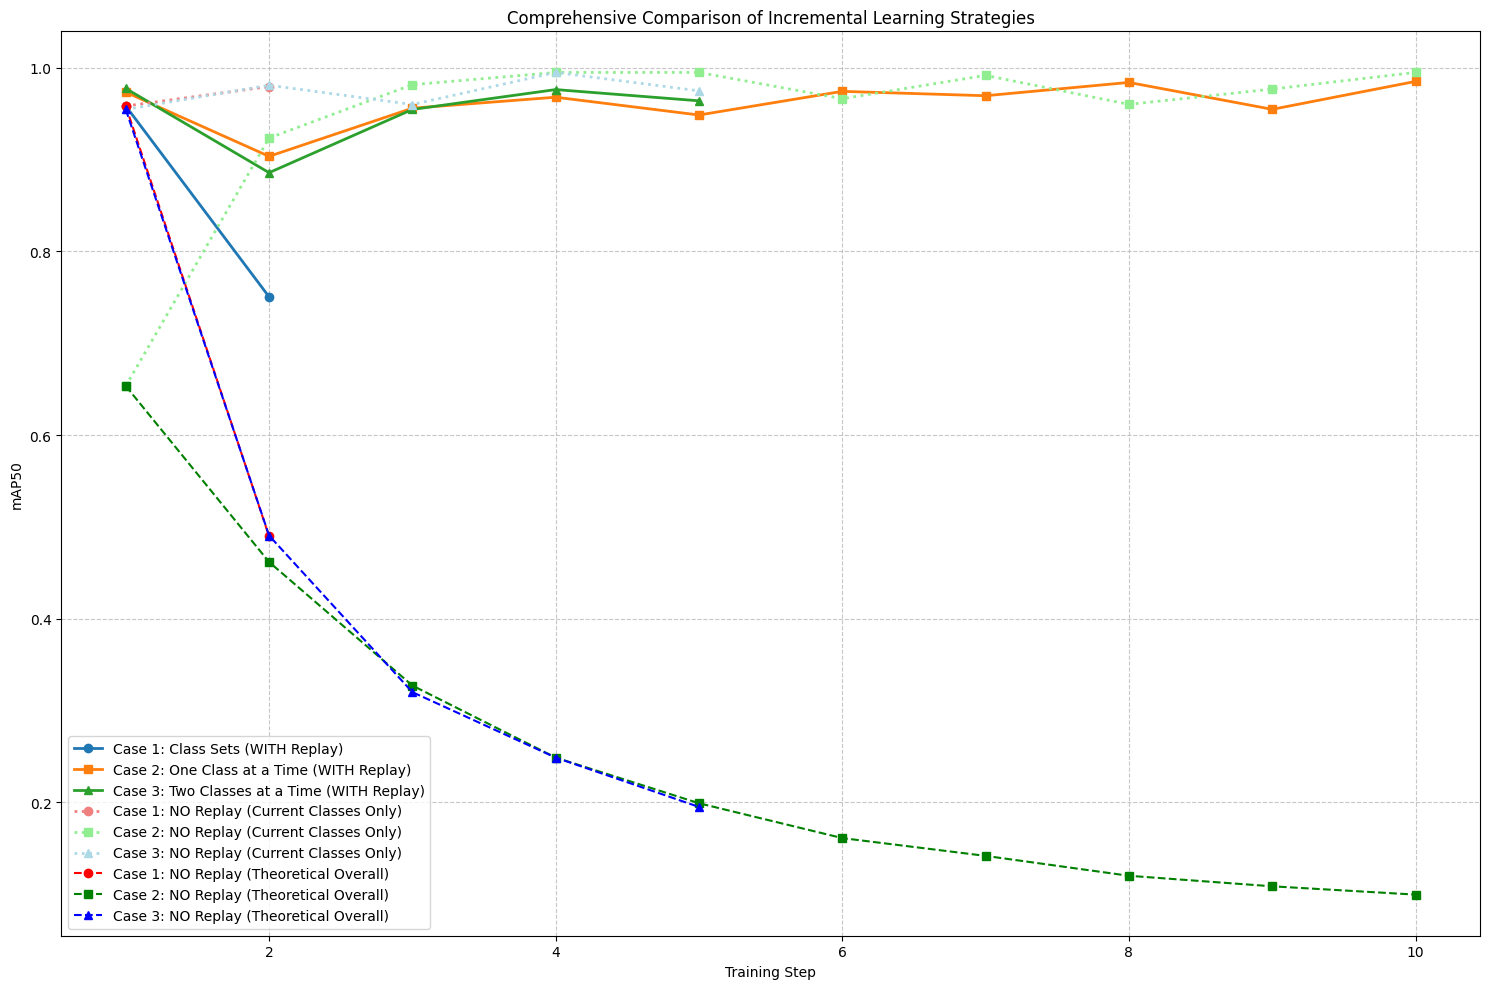

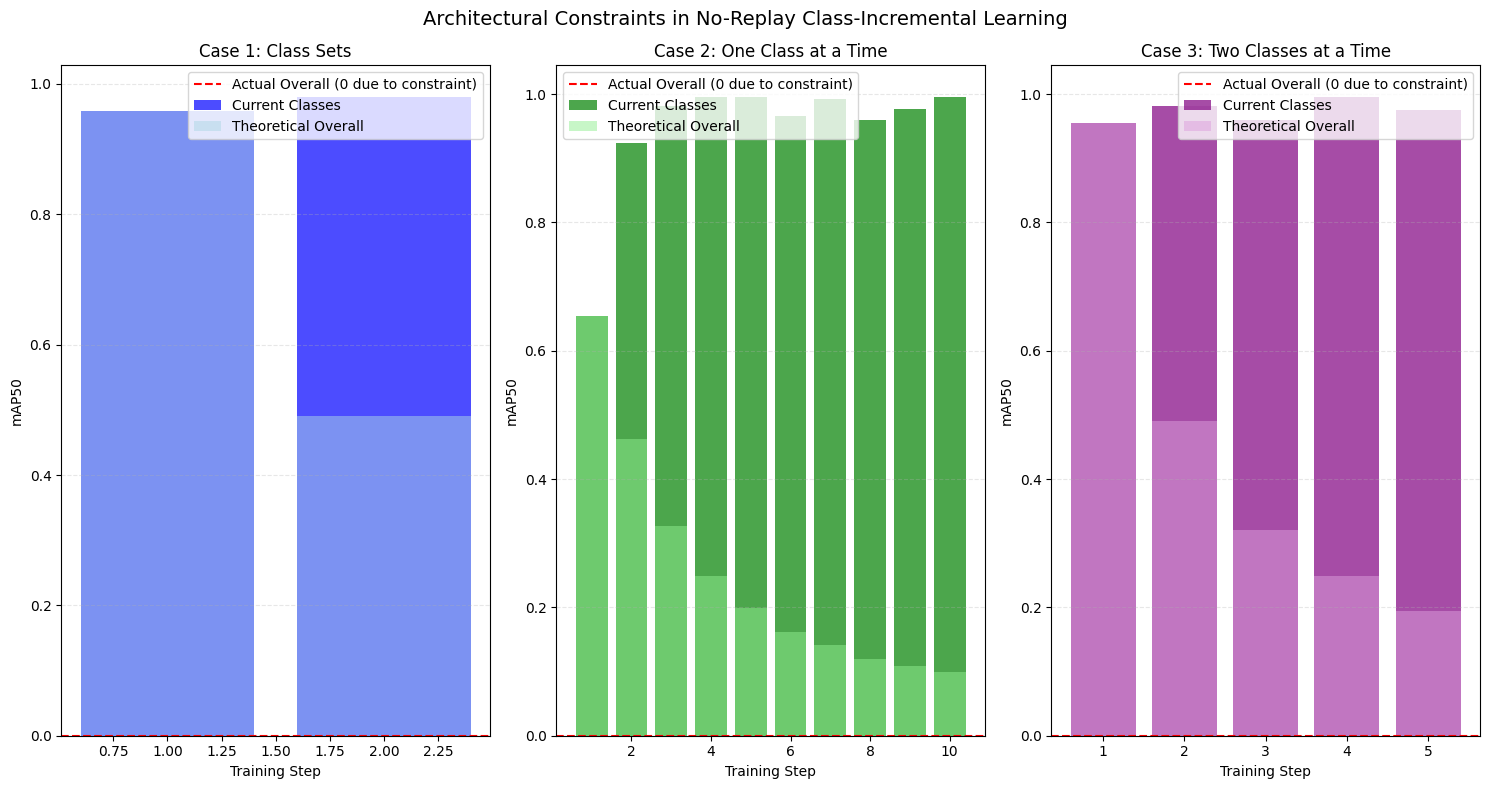

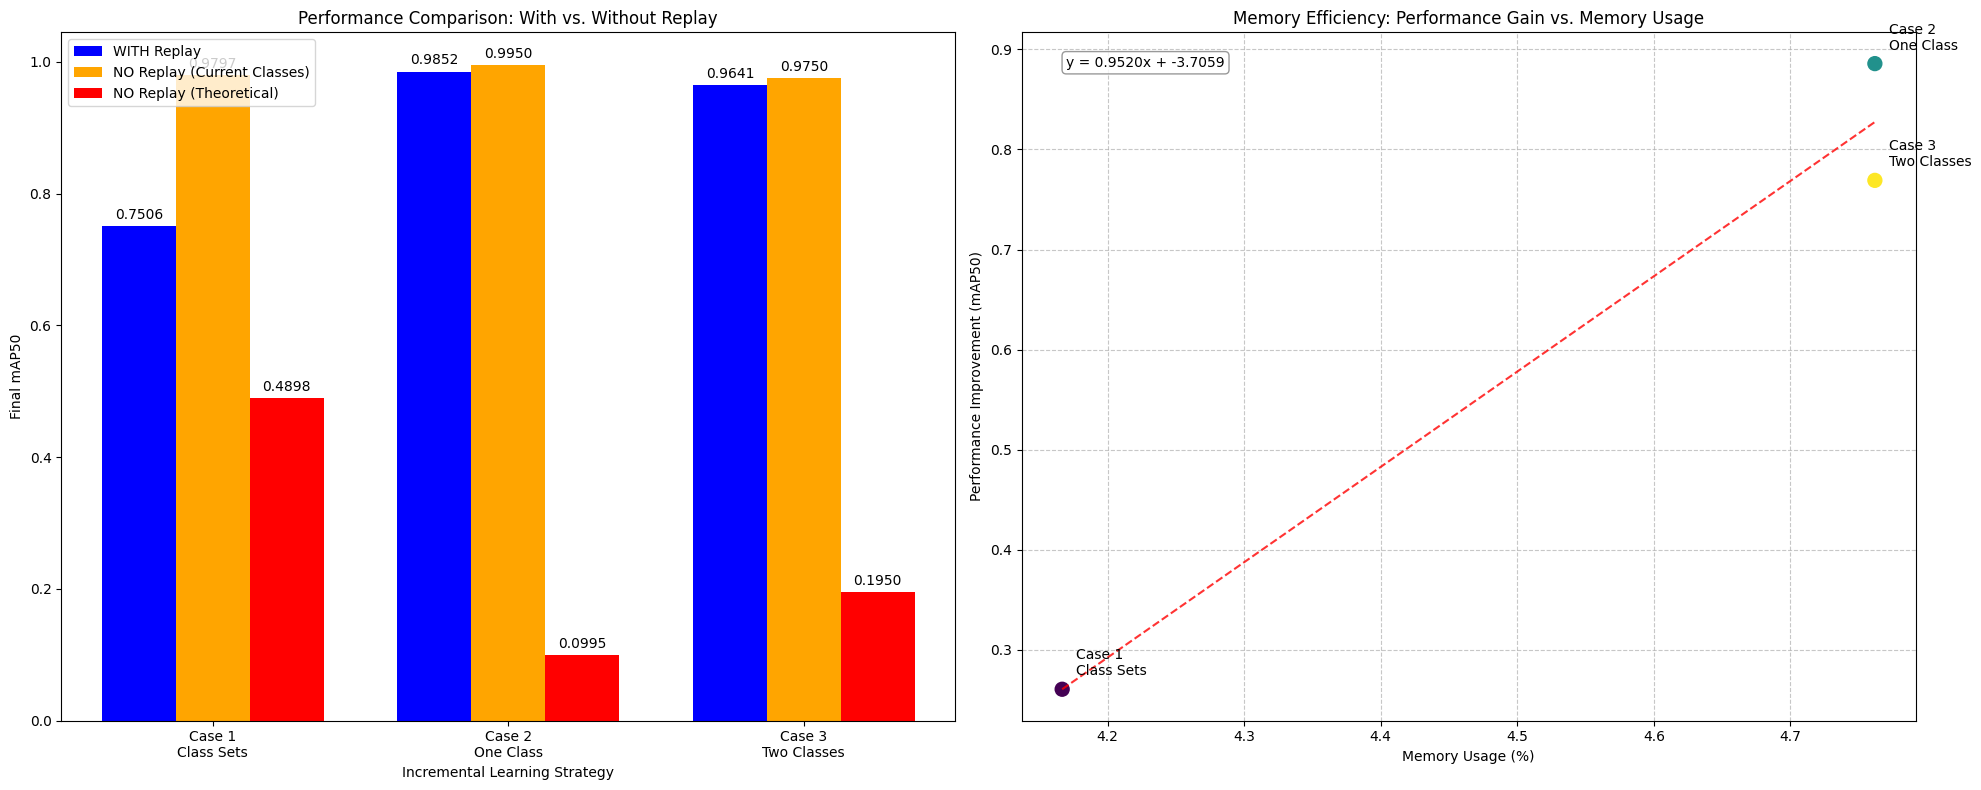

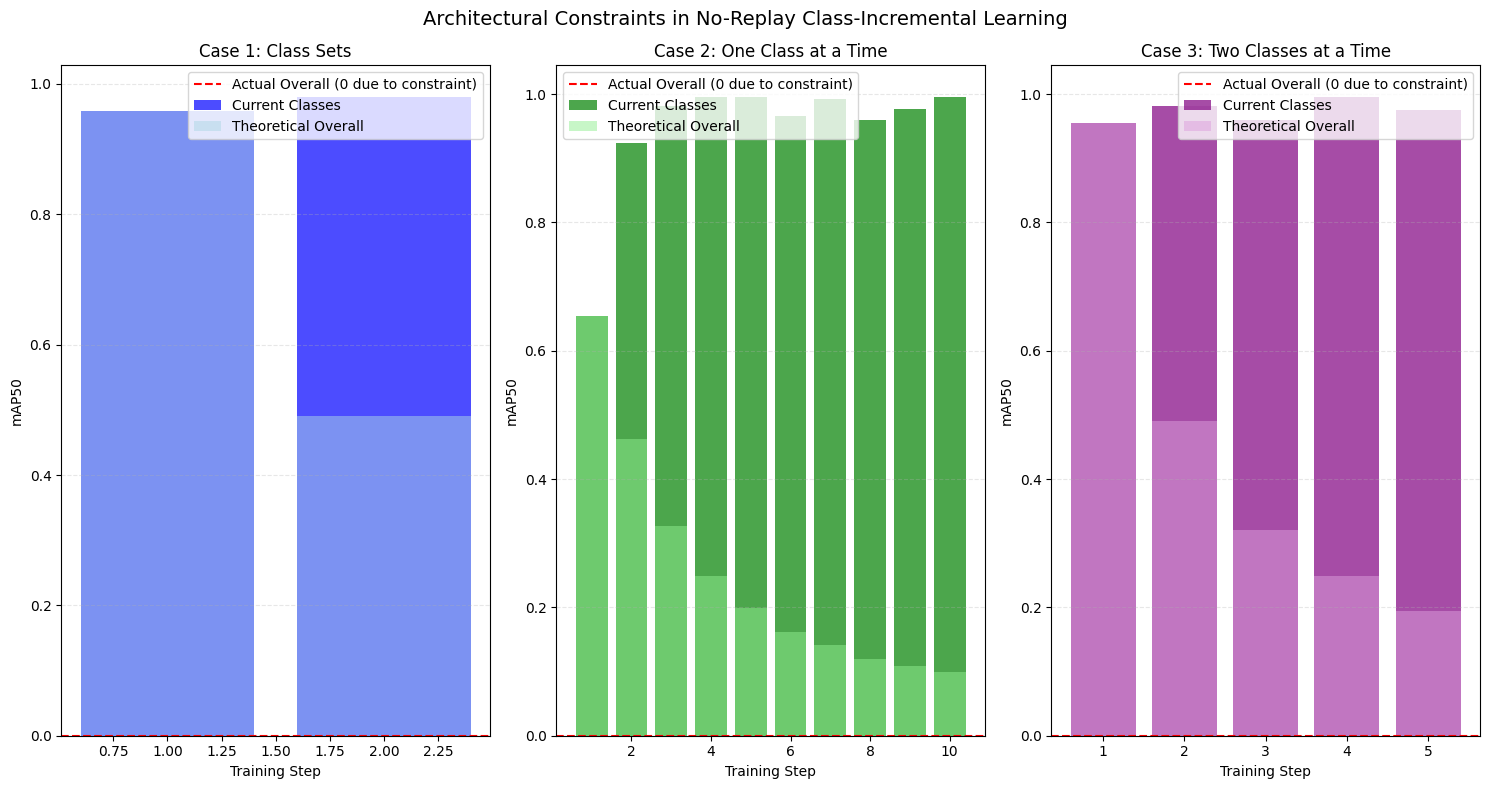

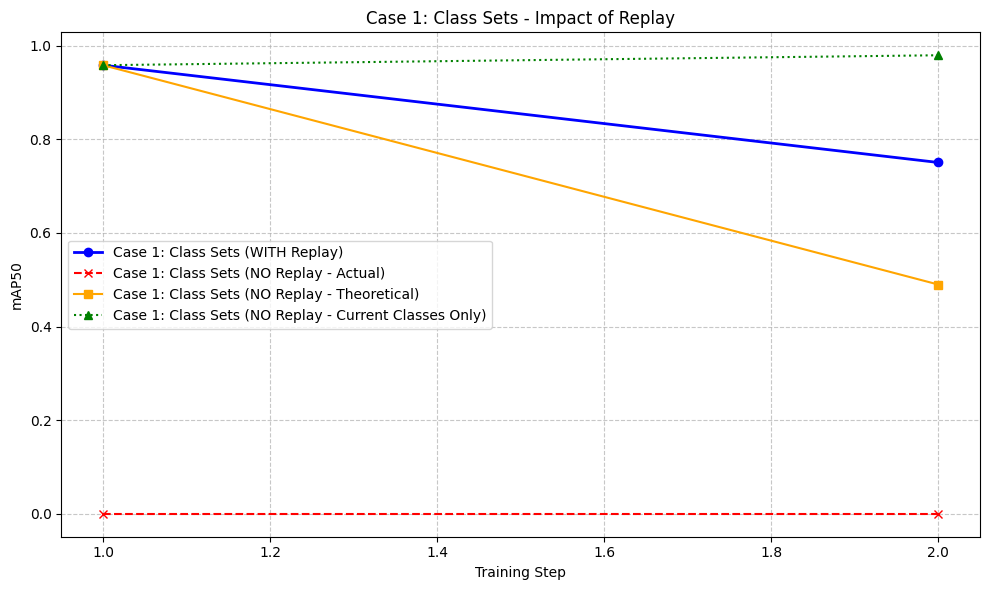

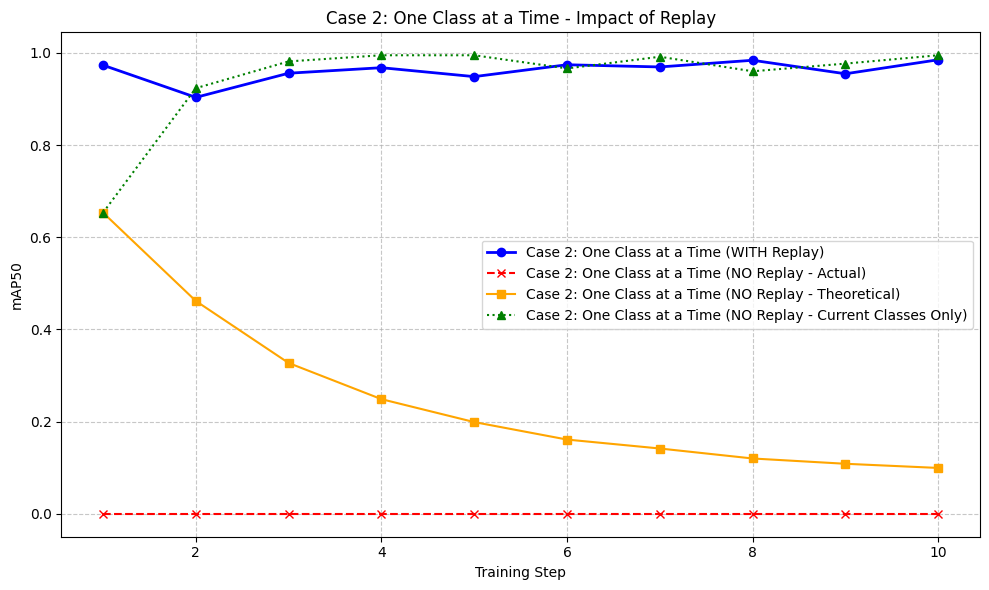

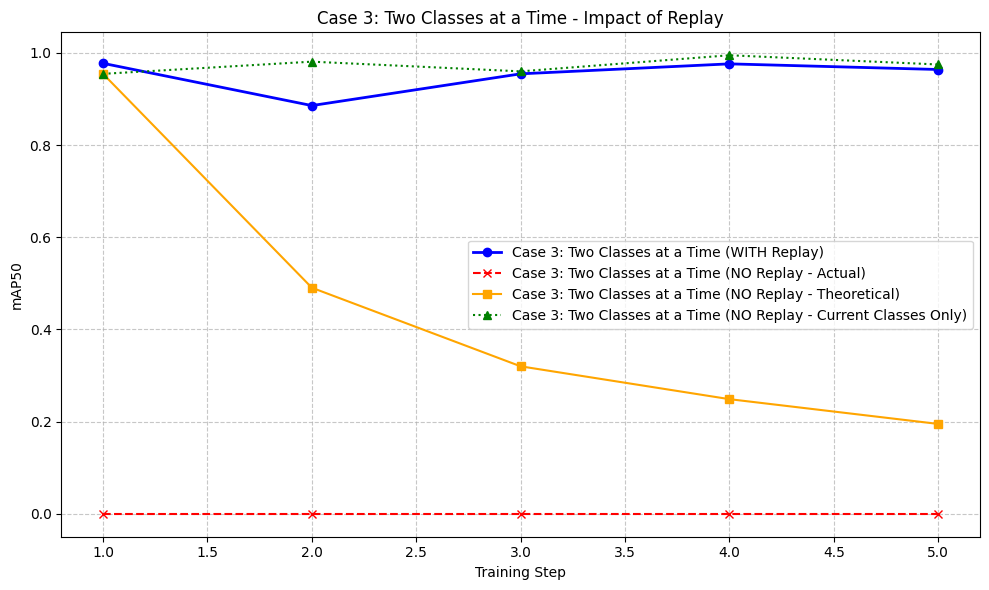

========== FINAL EXPERIMENT SUMMARY ==========
=== WITH REPLAY ===
Case 1: Class Sets (with Replay)
Final mAP50: 0.7506
Memory buffer size: 10 classes
Estimated memory percentage: 4.17%
Case 2: One Class at a Time (with Replay)
Final mAP50: 0.9852
Memory buffer size: 10 classes
Estimated memory percentage: 4.76%
Case 3: Two Classes at a Time (with Replay)
Final mAP50: 0.9641
Memory buffer size: 10 classes
Estimated memory percentage: 4.76%

=== WITHOUT REPLAY ===
Case 1: Class Sets (NO Replay)
Final mAP50 (overall): 0.0000 (constrained by model architecture)
Final mAP50 (current classes only): 0.9797
Final mAP50 (theoretical overall): 0.4898
Memory buffer size: 0 classes
Memory percentage: 0.00%
Case 2: One Class at a Time (NO Replay)
Final mAP50 (overall): 0.0000 (constrained by model architecture)
Final mAP50 (current classes only): 0.9950
Final mAP50 (theoretical overall): 0.0995
Memory buffer size: 0 classes
Memory percentage: 0.00%
Case 3: Two Classes at a Time (NO Replay)
Final m

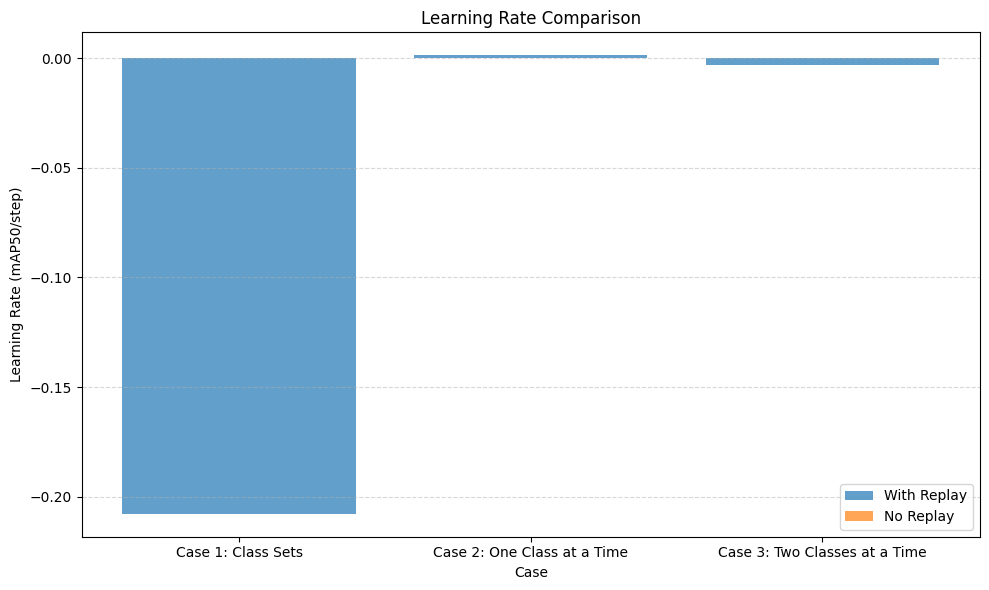

Learning rates plot saved to: csv_results/learning_rates_20250729_154338.png

===== COMPREHENSIVE CLASS INFLUENCE ANALYSIS =====


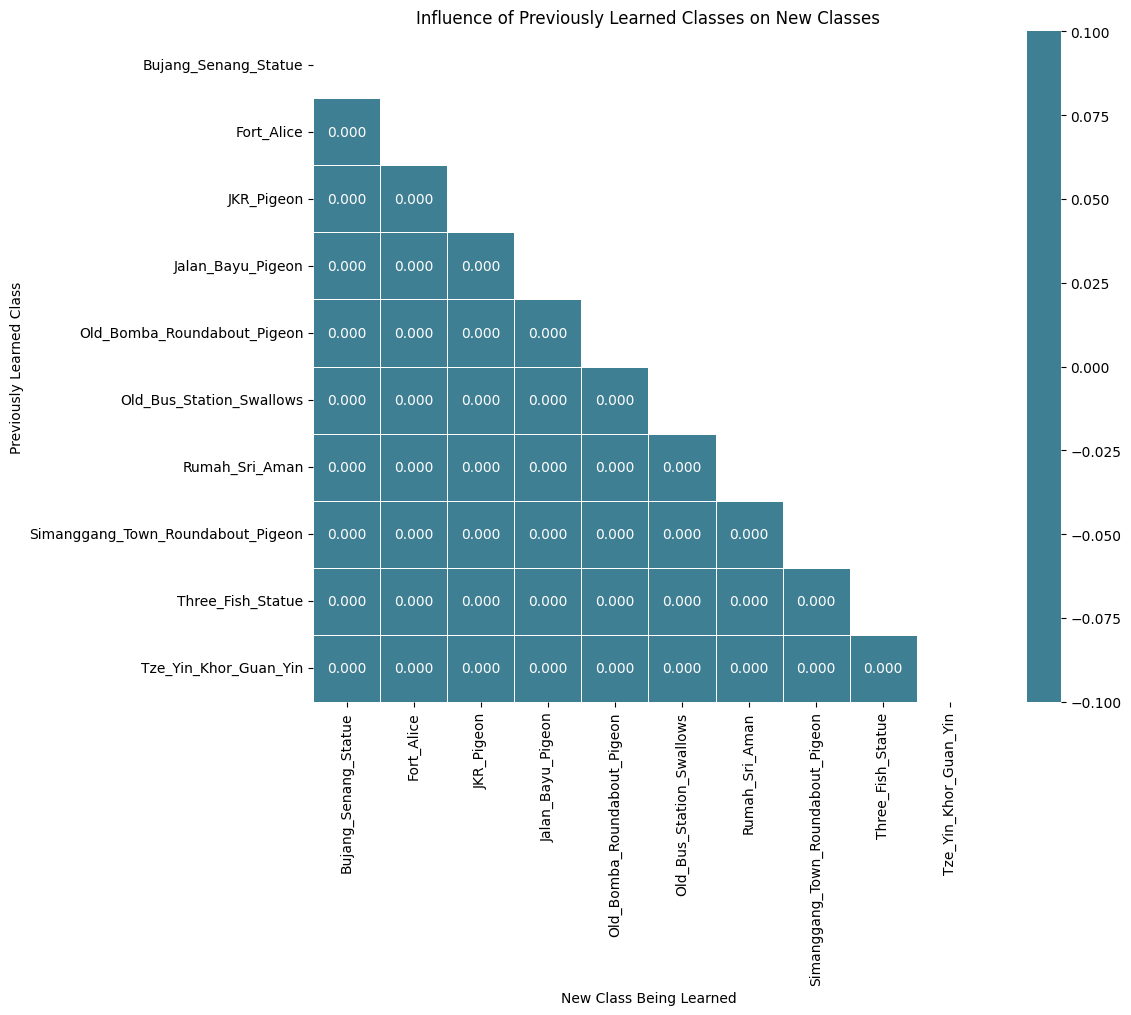

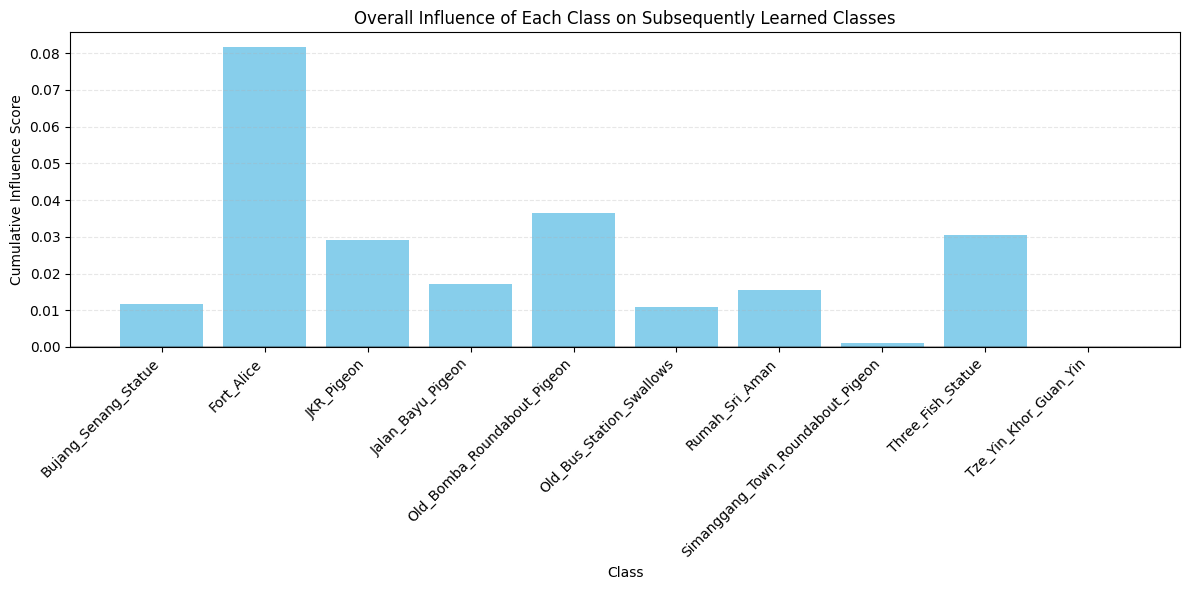


===== CLASS INFLUENCE ANALYSIS =====
Classes with highest positive influence (facilitating learning of new classes):
  Fort_Alice: 0.0816
  Old_Bomba_Roundabout_Pigeon: 0.0366
  Three_Fish_Statue: 0.0304

Classes with strongest negative influence (interfering with learning of new classes):


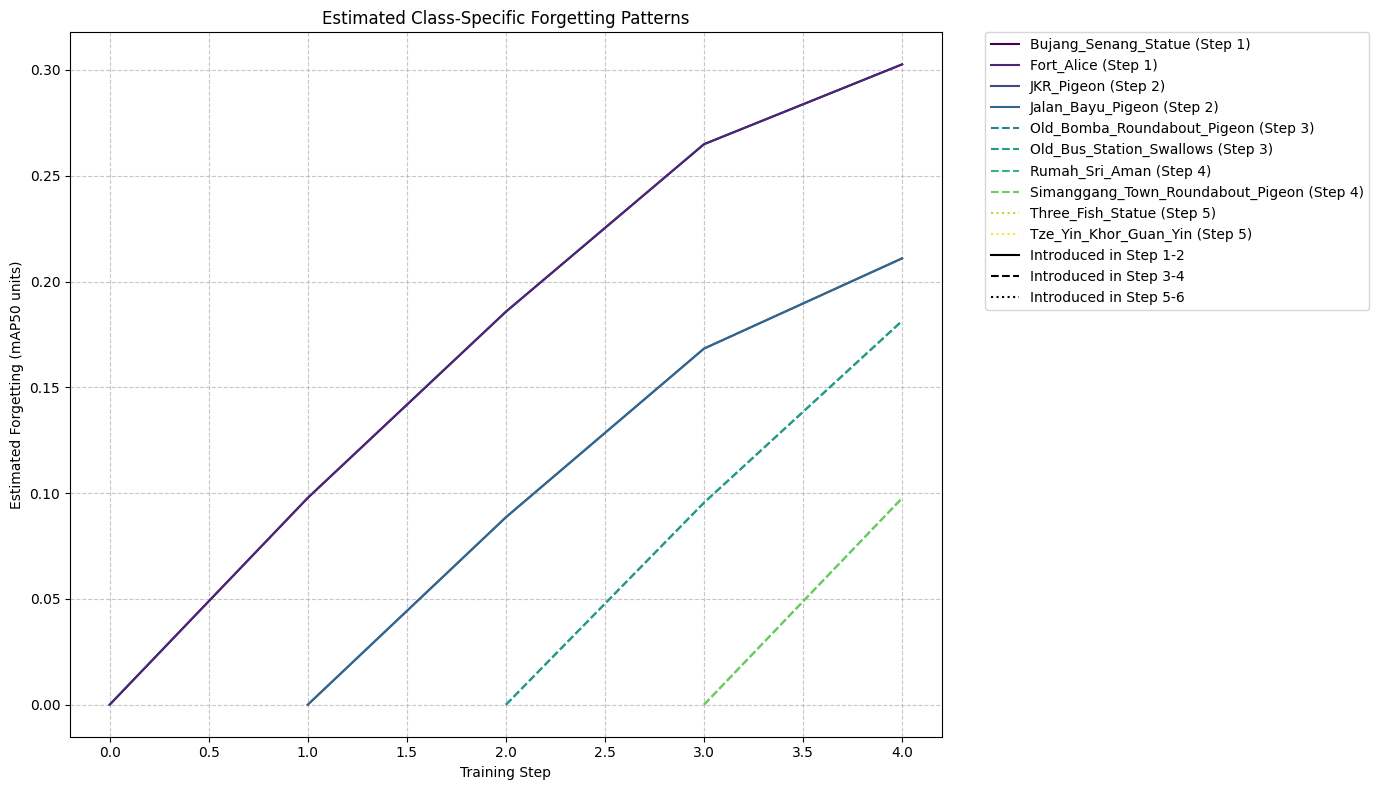

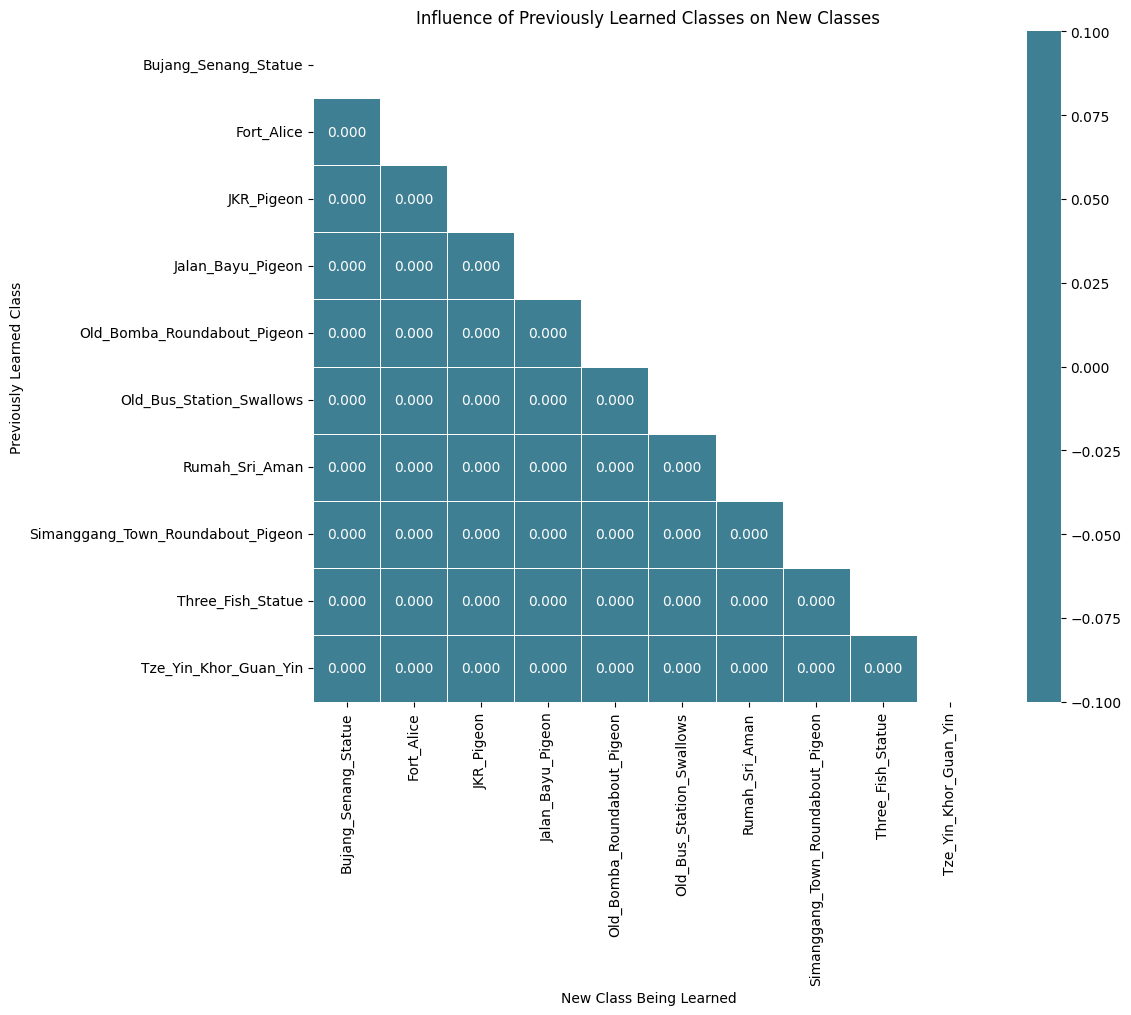

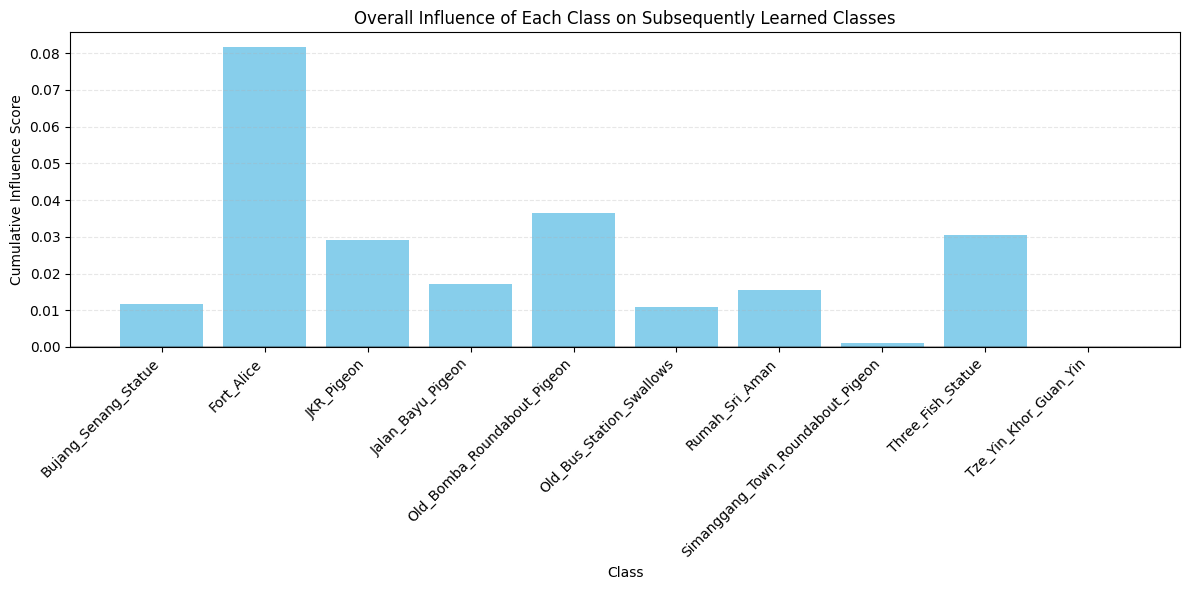


===== CLASS INFLUENCE ANALYSIS =====
Classes with highest positive influence (facilitating learning of new classes):
  Fort_Alice: 0.0816
  Old_Bomba_Roundabout_Pigeon: 0.0366
  Three_Fish_Statue: 0.0304

Classes with strongest negative influence (interfering with learning of new classes):


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


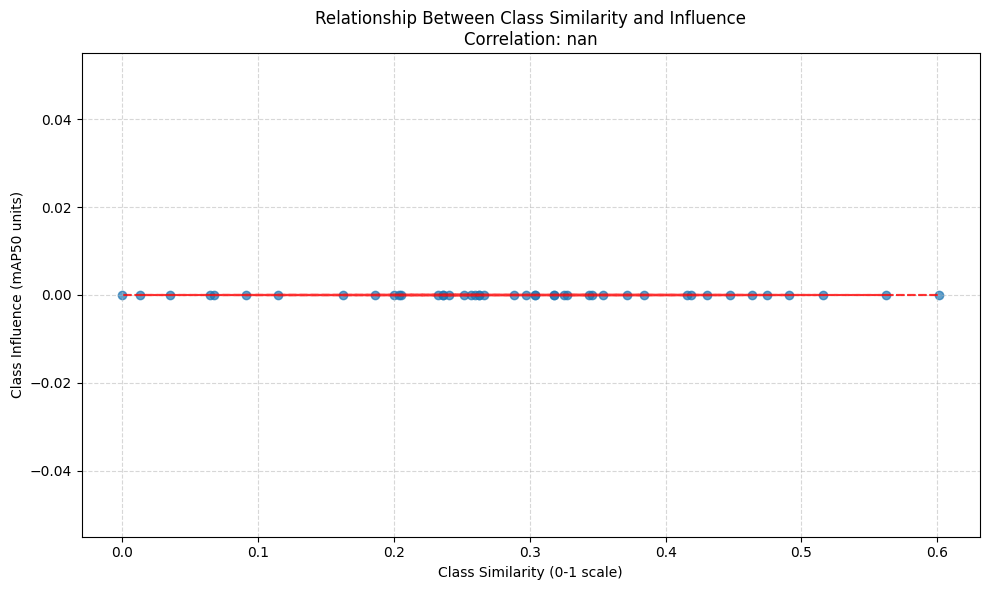


===== CLASS SIMILARITY AND INFLUENCE ANALYSIS =====
Overall correlation between class similarity and influence: nan

Top class pairs with high similarity and positive influence:
  Fort_Alice & Tze_Yin_Khor_Guan_Yin: Similarity=0.491, Influence=0.030, Score=0.015
  Fort_Alice & JKR_Pigeon: Similarity=0.263, Influence=0.052, Score=0.014
  Bujang_Senang_Statue & JKR_Pigeon: Similarity=0.236, Influence=0.052, Score=0.012
  Old_Bomba_Roundabout_Pigeon & Tze_Yin_Khor_Guan_Yin: Similarity=0.384, Influence=0.030, Score=0.012
  Old_Bus_Station_Swallows & Tze_Yin_Khor_Guan_Yin: Similarity=0.372, Influence=0.030, Score=0.011


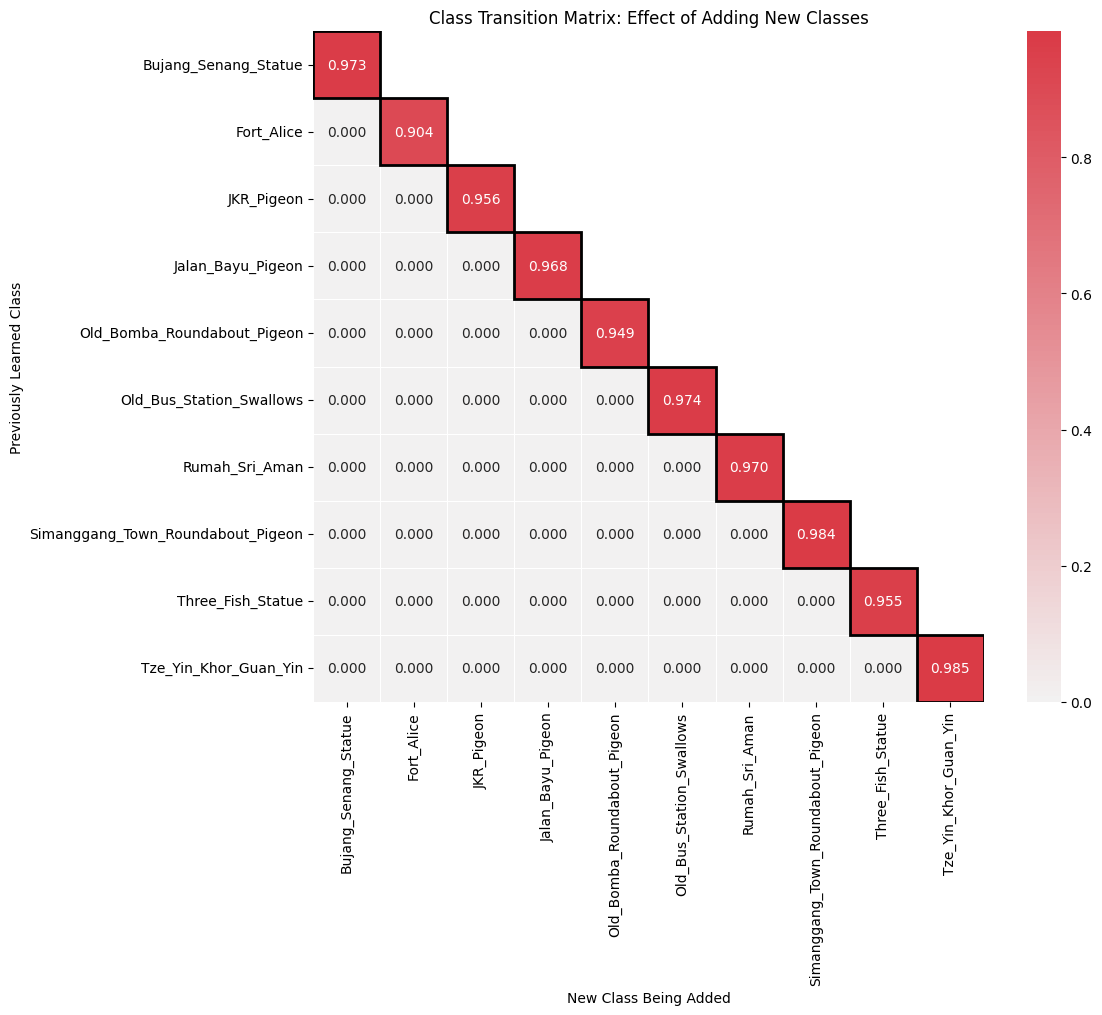


===== CLASS TRANSITION ANALYSIS =====
Positive transitions: 36 (65.5%)
Negative transitions: 19 (34.5%)

Classes with most positive influence when added:
  JKR_Pigeon: 0.0524
  Tze_Yin_Khor_Guan_Yin: 0.0304
  Old_Bus_Station_Swallows: 0.0258

Classes with most negative influence when added:
  Fort_Alice: -0.0699
  Three_Fish_Statue: -0.0293
  Old_Bomba_Roundabout_Pigeon: -0.0194

Analysis complete! All visualizations saved.

=========== Exporting Comprehensive Analysis ===========
Starting comprehensive analysis export...

1. Exporting class transition analysis...
Class transition matrix exported to: csv_results/class_transition_matrix_20250729_154338.csv
Class transition statistics exported to: csv_results/class_transition_statistics_20250729_154338.csv
Transition summary exported to: csv_results/transition_summary_20250729_154338.csv

2. Exporting class influence analysis...
Class influence matrix exported to: csv_results/class_influence_matrix_20250729_154338.csv
Class influence sc

In [ ]:
if __name__ == "__main__":
  main()

Debugging

In [ ]:
import os
import yaml
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO

# 1. First, let's check all label files for potential issues
def check_labels(labels_dir, num_classes):
    """
    Thoroughly check label files for potential issues
    """
    print(f"Checking label files in {labels_dir}")
    if not os.path.exists(labels_dir):
        print(f"  Directory not found: {labels_dir}")
        return False

    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    print(f"  Found {len(label_files)} label files")

    issues_found = 0
    max_class_id = -1
    problematic_files = []

    for label_file in label_files:
        file_path = os.path.join(labels_dir, label_file)
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()

            file_has_issue = False
            for i, line in enumerate(lines):
                parts = line.strip().split()

                # Check for empty lines
                if not parts:
                    print(f"  Empty line in {label_file}:line {i+1}")
                    file_has_issue = True
                    continue

                # Check class ID
                try:
                    class_id = int(parts[0])
                    max_class_id = max(max_class_id, class_id)

                    if class_id < 0 or class_id >= num_classes:
                        print(f"  Invalid class ID {class_id} in {label_file}:line {i+1}")
                        file_has_issue = True
                except ValueError:
                    print(f"  Non-integer class ID '{parts[0]}' in {label_file}:line {i+1}")
                    file_has_issue = True

                # Check if there are 5 values (class_id, x, y, w, h)
                if len(parts) != 5:
                    print(f"  Wrong number of values in {label_file}:line {i+1}: expected 5, got {len(parts)}")
                    file_has_issue = True
                    continue

                # Check coordinate values
                for j in range(1, 5):
                    try:
                        val = float(parts[j])
                        if val < 0 or val > 1:
                            print(f"  Coordinate out of range in {label_file}:line {i+1}: {parts[j]}")
                            file_has_issue = True
                    except ValueError:
                        print(f"  Non-float coordinate '{parts[j]}' in {label_file}:line {i+1}")
                        file_has_issue = True

            if file_has_issue:
                problematic_files.append(file_path)
                issues_found += 1

        except Exception as e:
            print(f"  Error reading {file_path}: {e}")
            problematic_files.append(file_path)
            issues_found += 1

    print(f"  Maximum class ID found: {max_class_id}")
    print(f"  Found {issues_found} files with issues out of {len(label_files)}")

    return issues_found == 0, max_class_id, problematic_files

# 2. Let's try a basic YOLO validation run first to see if it works
def test_basic_yolo():
    """
    Try a basic YOLO validation run to check if the model works with the dataset
    """
    print("\nTesting basic YOLO validation...")

    try:
        # Load a model
        model = YOLO('yolov8n.pt')

        # Run validation on the data
        results = model.val(data='/content/data/data_ver2_(include_null)/data.yaml', device='cpu')
        print("Basic validation successful!")
        return True
    except Exception as e:
        print(f"Basic validation failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# 3. Let's fix any label issues we find
def fix_label_issues(labels_dir, num_classes, problematic_files):
    """
    Fix label issues in problematic files
    """
    print(f"\nFixing {len(problematic_files)} problematic label files...")

    for file_path in problematic_files:
        try:
            fixed_lines = []
            with open(file_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                # Skip empty lines
                if not parts:
                    continue

                try:
                    # Fix class ID
                    class_id = int(parts[0])
                    if class_id < 0 or class_id >= num_classes:
                        class_id = class_id % num_classes  # Wrap around to valid range

                    # Fix coordinates
                    coords = []
                    for i in range(1, min(5, len(parts))):
                        try:
                            val = float(parts[i])
                            val = max(0.001, min(0.999, val))  # Clamp to valid range
                            coords.append(val)
                        except ValueError:
                            coords.append(0.5)  # Default to center

                    # Ensure we have all 4 coordinates
                    while len(coords) < 4:
                        coords.append(0.5)

                    # Create fixed line
                    fixed_line = f"{class_id} {coords[0]:.6f} {coords[1]:.6f} {coords[2]:.6f} {coords[3]:.6f}\n"
                    fixed_lines.append(fixed_line)
                except Exception:
                    continue  # Skip lines that can't be fixed

            # Write fixed lines back to file
            with open(file_path, 'w') as f:
                f.writelines(fixed_lines)

            print(f"  Fixed {file_path}")
        except Exception as e:
            print(f"  Error fixing {file_path}: {e}")

    print("Label fixing complete!")

# 4. Let's create a simple test case for incremental learning
def test_simple_incremental_training():
    """
    Try a simplified version of incremental training
    """
    print("\nTesting simplified incremental training...")

    try:
        # Create a simple data.yaml with just one class
        simplified_yaml = {
            'train': '/content/data/data_ver2_(include_null)/train/train/images',
            'val': '/content/data/data_ver2_(include_null)/train/val/images',
            'nc': 1,
            'names': ['Landmark']  # Generic class name
        }

        yaml_path = '/content/data/simplified_data.yaml'
        with open(yaml_path, 'w') as f:
            yaml.dump(simplified_yaml, f, sort_keys=False)

        print("Created simplified data.yaml")

        # Try to train the model
        model = YOLO('yolov8n.pt')

        # Run training with reduced complexity
        results = model.train(
            data=yaml_path,
            epochs=1,  # Just 1 epoch for testing
            imgsz=640,
            batch=8,
            device='cpu'  # Use CPU to avoid CUDA issues
        )

        print("Simplified training successful!")
        return True
    except Exception as e:
        print(f"Simplified training failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# 5. Main function to run all checks and fixes
def main():
    # Define paths
    data_yaml_path = '/content/data/data_ver2_(include_null)/data.yaml'
    train_labels_dir = '/content/data/data_ver2_(include_null)/train/train/labels'
    val_labels_dir = '/content/data/data_ver2_(include_null)/train/val/labels'

    # Make sure data.yaml exists and has correct format
    try:
        with open(data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)

        num_classes = data_yaml.get('nc', 10)
        print(f"Found {num_classes} classes in data.yaml")

        # Update paths if needed
        data_yaml['train'] = '/content/data/data_ver2_(include_null)/train/train/images'
        data_yaml['val'] = '/content/data/data_ver2_(include_null)/train/val/images'

        # Save the updated yaml
        with open(data_yaml_path, 'w') as f:
            yaml.dump(data_yaml, f, sort_keys=False)

        print(f"Updated {data_yaml_path} with correct paths")
    except Exception as e:
        print(f"Error processing data.yaml: {e}")
        return

    # Check training labels
    train_labels_ok, train_max_class, train_problematic = check_labels(train_labels_dir, num_classes)

    # Check validation labels
    val_labels_ok, val_max_class, val_problematic = check_labels(val_labels_dir, num_classes)

    # Fix any issues in the label files
    if not train_labels_ok:
        fix_label_issues(train_labels_dir, num_classes, train_problematic)

    if not val_labels_ok:
        fix_label_issues(val_labels_dir, num_classes, val_problematic)

    # Check if max class ID is consistent with nc in data.yaml
    max_class_id = max(train_max_class, val_max_class)
    if max_class_id >= num_classes:
        print(f"Warning: Maximum class ID {max_class_id} is >= num_classes {num_classes}")
        print(f"Updating nc in data.yaml to {max_class_id + 1}")

        # Update nc in data.yaml
        data_yaml['nc'] = max_class_id + 1

        # Make sure names list is long enough
        if isinstance(data_yaml['names'], list) and len(data_yaml['names']) < data_yaml['nc']:
            # Extend the names list
            current_len = len(data_yaml['names'])
            data_yaml['names'].extend([f'class_{i}' for i in range(current_len, data_yaml['nc'])])

        # Save the updated yaml
        with open(data_yaml_path, 'w') as f:
            yaml.dump(data_yaml, f, sort_keys=False)

    # Try a basic YOLO validation
    basic_ok = test_basic_yolo()

    # If basic validation fails, try a simplified training
    if not basic_ok:
        simplified_ok = test_simple_incremental_training()

        if simplified_ok:
            print("\nSimplified training worked! The issue is likely with your incremental learning code.")
            print("Try running your incremental learning code with CPU instead of CUDA and with simplified settings.")
        else:
            print("\nBoth basic and simplified training failed. There may be deeper issues with your dataset.")
            print("Consider regenerating your dataset from scratch or using a pre-built YOLO dataset for testing.")
    else:
        print("\nBasic validation worked! The issue is likely with your incremental learning code.")
        print("Try running your incremental learning code with CPU instead of CUDA.")

if __name__ == "__main__":
    main()

export


In [ ]:
import os
import zipfile
import glob
from google.colab import files
import datetime

def create_and_download_zip(root_dirs=None, include_patterns=None, exclude_patterns=None, zip_name=None):
    """
    Create a zip file of specified directories and files from your Colab runtime and download it.

    Args:
        root_dirs: List of root directories to include (default: ['/content'])
        include_patterns: List of glob patterns to include (default: ['*'])
        exclude_patterns: List of glob patterns to exclude (default: [])
        zip_name: Name of the output zip file (default: 'colab_files_YYYY-MM-DD.zip')
    """
    # Default parameters
    if root_dirs is None:
        root_dirs = ['/content']
    if include_patterns is None:
        include_patterns = ['*']
    if exclude_patterns is None:
        exclude_patterns = ['*.zip']  # Don't include previous zip files
    if zip_name is None:
        date_str = datetime.datetime.now().strftime('%Y-%m-%d')
        zip_name = f'colab_files_{date_str}.zip'

    # Create a temporary list to track files
    files_to_zip = []

    # Collect all files matching the patterns
    for root_dir in root_dirs:
        for pattern in include_patterns:
            path_pattern = os.path.join(root_dir, pattern)
            files_to_zip.extend(glob.glob(path_pattern, recursive=True))

    # Filter out excluded patterns
    for exclude in exclude_patterns:
        files_to_zip = [f for f in files_to_zip if not glob.fnmatch.fnmatch(f, exclude)]

    # Remove directories from the list (we only want files)
    files_to_zip = [f for f in files_to_zip if os.path.isfile(f)]

    # Sort files by path for better organization
    files_to_zip.sort()

    # Print stats
    print(f"Found {len(files_to_zip)} files to zip")

    # Create zip file
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in files_to_zip:
            # Get the relative path within the zip file
            arcname = file.replace('/content/', '')
            try:
                zipf.write(file, arcname=arcname)
                print(f"Added: {arcname}")
            except Exception as e:
                print(f"Error adding {file}: {e}")

    print(f"\nZip file created: {zip_name}")
    # Calculate zip file size
    zip_size = os.path.getsize(zip_name) / (1024 * 1024)  # Size in MB
    print(f"Zip file size: {zip_size:.2f} MB")

    # Download the zip file
    print("\nDownloading zip file...")
    files.download(zip_name)

    return zip_name

# Create a specific zip file for your project
def zip_yolo_project():
    """Create a zip file specifically for your YOLOv8 incremental learning project"""
    # Define what to include
    root_dirs = ['/content']

    # Include patterns for your project
    include_patterns = [
        # Code and results
        '*.py',
        '*.ipynb',
        '*.yaml',
        '*.png',
        '*.jpg',
        # YOLOv8 output directories
        'runs/**/*',
        # Dataset metadata
        'data/**/*.yaml',
        # Temporary datasets created during training
        'temp_dataset*/**/*',
        # Any other project files
        'incremental_learning_results.png',
        '*.txt',
        '*.md',
        # Include Google Drive mounted files if needed
        'csv_results/*'
    ]

    # Exclude patterns
    exclude_patterns = [
        # Exclude large files and directories
        '*.zip',
        '*.pt',
        '**/images/*',  # Exclude the actual dataset images to save space
        '**/labels/*'    # Exclude label files to save space
    ]

    # Create a descriptive name
    zip_name = f'yolov8_incremental_learning_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}.zip'

    # Create and download the zip
    return create_and_download_zip(root_dirs, include_patterns, exclude_patterns, zip_name)

# Run the function
zip_yolo_project()

# If you want to include the datasets too (which could be large), run this instead:
# create_and_download_zip(
#     root_dirs=['/content'],
#     include_patterns=['**/*'],
#     exclude_patterns=['*.zip', '*.pyc', '__pycache__/**/*'],
#     zip_name='yolov8_project_with_datasets.zip'
# )

Found 1096 files to zip
Added: all_strategies_comparison.png
Added: case1_replay_comparison.png
Added: case2_replay_comparison.png
Added: case3_replay_comparison.png
Added: class_influence_heatmap.png
Added: class_influence_scores.png
Added: class_similarity_influence.png
Added: class_specific_forgetting.png
Added: class_transition_matrix.png
Added: csv_results/all_results_20250729_154338.csv
Added: csv_results/case1_no_replay_20250729_154338.csv
Added: csv_results/case1_with_replay_20250729_154338.csv
Added: csv_results/case2_no_replay_20250729_154338.csv
Added: csv_results/case2_with_replay_20250729_154338.csv
Added: csv_results/case3_no_replay_20250729_154338.csv
Added: csv_results/case3_with_replay_20250729_154338.csv
Added: csv_results/class_influence_matrix_20250729_154338.csv
Added: csv_results/class_influence_scores_20250729_154338.csv
Added: csv_results/class_transition_matrix_20250729_154338.csv
Added: csv_results/class_transition_statistics_20250729_154338.csv
Added: csv_res

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'yolov8_incremental_learning_20250729_1616.zip'

## Resources

1. YOLOv5 GitHub repository: https://github.com/ultralytics/yolov5
2. Joseph Redmon's original YOLO paper: https://arxiv.org/abs/1506.02640
3. YOLO v4 paper: https://arxiv.org/abs/2004.10934
4. YOLOR paper: https://arxiv.org/abs/2105.04206
5. YOLOX paper: https://arxiv.org/abs/2107.08430
6. YOLOv7 paper: https://arxiv.org/abs/2207.02696